<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/BM_10layer_Thermal_history_18_06_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [2]:
!pip install GitPython

In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

Cloning into 'BM'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (469/469), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 1100 (delta 344), reused 225 (delta 225), pack-reused 631 (from 1)
Receiving objects: 100% (1100/1100), 122.94 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (605/605), done.
Updating files: 100% (174/174), done.


### Step 0. Data preparation

In [4]:
# import pandas as pd

# Allen & Allne - Data (10 layers)
# df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
# df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs.csv', delimiter=';', header=0)

# Test Data-1
df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs_test1.csv', delimiter=';', header=0)

# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
# df_well = pd.read_csv('/content/BM/Well_parametrs_A13.csv', delimiter=';', header=0) ### Geoterm test - Appendix 13

df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [5]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.00,0,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN


In [6]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


### DataBase

In [7]:
import pandas as pd

file_path = '/content/BM/Initial data/Literature database from PM for all rock lithotypes.xlsx'

database = pd.ExcelFile(file_path)
print("Available sheets:", database.sheet_names)

for sheet_name in database.sheet_names:
    clean_name = sheet_name.replace(" ", "_").replace("-", "_")
    var_name = f"Database_{clean_name}"

    # Assign the DataFrame to a dynamically named variable
    globals()[var_name] = pd.read_excel(
        file_path,
        sheet_name=sheet_name,
        header=0
    )
    print(f"Created variable: {var_name}")

Available sheets: ['Lithotypes', 'Kinetics all', 'Secondary cracking', 'Geochronology', 'SWIT_Map', 'SWIT_coordinates ', 'Global eustatic curve']
Created variable: Database_Lithotypes
Created variable: Database_Kinetics_all
Created variable: Database_Secondary_cracking
Created variable: Database_Geochronology
Created variable: Database_SWIT_Map
Created variable: Database_SWIT_coordinates_
Created variable: Database_Global_eustatic_curve


#### Lithology

In [8]:
from pandas.api.types import is_scalar

Database_Lithotypes.columns = Database_Lithotypes.iloc[0]
Database_Lithotypes = Database_Lithotypes.drop([0, 1]).reset_index(drop=True)

current_columns = Database_Lithotypes.columns
if is_scalar(current_columns[0]) and pd.isna(current_columns[0]):
    new_columns = list(current_columns)
    new_columns[0] = "Lithology type"
    Database_Lithotypes.columns = new_columns

Database_Lithotypes.head(7)
# Database_Lithotypes.head(7).iloc[:, :6]

,Lithology type,Density,Initial porosity,Minimum porosity,Compaction model Key,Compressibility MAX,Compressibility MIN,Athy factor k (stress),Schneider Factor ka,Schneider factor kb,...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
0,Sandstone (typical),2720,41,1,Athy's law (depth),27.47,1.15,26.6,41.56,17.81,...,23.2,0.0,0,0,0,0,0,0,0,NaN
1,Sandstone (clay rich),2760,40,1,Athy's law (depth),26.54,1.11,26.61,40,18.12,...,23.2,0.0,0,0,0,0,0,0,0,NaN
2,Sandstone (clay poor),2700,42,1,Athy's law (depth),28.05,1.18,26.27,40.47,17.34,...,23.2,0.0,0,0,0,0,0,0,0,NaN
3,"Sandstone (quartzite, typical)",2640,42,1,Athy's law (depth),29.1,1.22,27.26,42.81,17.81,...,23.2,0.0,0,0,0,0,0,0,0,NaN
4,"Sandstone (quartzite, very quartz rich)",2640,42,1,Athy's law (depth),25.26,1.18,24.61,16.15,39.77,...,23.2,0.0,0,0,0,0,0,0,0,NaN
5,"Sandstone (subarkose, typical)",2680,41,1,Athy's law (depth),24.48,1.14,24.68,16.31,38.74,...,23.2,0.0,0,0,0,0,0,0,0,NaN
6,"Sandstone (subarkose, quartz rich)",2650,42,1,Athy's law (depth),26.34,1.19,25.33,39.84,16.41,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [9]:
Database_Lithotypes.head(7).iloc[:, :6]

,Lithology type,Density,Initial porosity,Minimum porosity,Compaction model Key,Compressibility MAX
0,Sandstone (typical),2720,41,1,Athy's law (depth),27.47
1,Sandstone (clay rich),2760,40,1,Athy's law (depth),26.54
2,Sandstone (clay poor),2700,42,1,Athy's law (depth),28.05
3,"Sandstone (quartzite, typical)",2640,42,1,Athy's law (depth),29.1
4,"Sandstone (quartzite, very quartz rich)",2640,42,1,Athy's law (depth),25.26
5,"Sandstone (subarkose, typical)",2680,41,1,Athy's law (depth),24.48
6,"Sandstone (subarkose, quartz rich)",2650,42,1,Athy's law (depth),26.34


In [10]:
print("Current columns:")
for idx, col in enumerate(Database_Lithotypes.columns, 1):
    print(f"{idx}. {col}")

Current columns:
1. Lithology type
2. Density
3. Initial porosity
4. Minimum porosity
5. Compaction model Key
6. Compressibility MAX
7. Compressibility MIN
8. Athy factor k (stress)
9. Schneider Factor ka
10. Schneider factor kb
11. Schneider factor phi
12. Athy factor k (depth)
13. Multipoint curve
14. Curve flag
15. Depth curve
16. Effective stress curve
17. Compaction formula
18. Thermal conductivity model key
19. Thermal conductivity at 20 oC
20. Thermal conductivity at 100 oC
21. Thermal conductivity minimum temperature
22. Thermal conductivity max temperature
23. Thermal conductivity conductivity multi-point model
24. Anisotropy factor thermal conductivity
25. Depositional anisotropy
26. Depositional anisotropy
27. Thermal expansion coefficient 
28. Radiogenic model key
29. Uranium
30. Thorium
31. Potassium
32. Porosity
33. Gamma Ray
34. Time correction
35. HeatFlow Production value
36. Half Depth Value
37. Heat capacity model key
38. Heat capacity at 20 oC
39. Heat capacity at 1

In [11]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Sandstone (quartzite, very quartz rich)']
sandstone_row

,Lithology type,Density,Initial porosity,Minimum porosity,Compaction model Key,Compressibility MAX,Compressibility MIN,Athy factor k (stress),Schneider Factor ka,Schneider factor kb,...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
4,"Sandstone (quartzite, very quartz rich)",2640,42,1,Athy's law (depth),25.26,1.18,24.61,16.15,39.77,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [12]:
sandstone_row["Compressibility MIN"]

,Compressibility MIN
4,1.18


Check name of lithology to name in Database_Lithotypes

In [13]:
# Database_Lithotypes['Lithology type'].values
if 'Anhydrite' in Database_Lithotypes['Lithology type'].values:
    print("✅ found (case-sensitive match)")
else:
    print("❌ NOT found (case-sensitive match)")

✅ found (case-sensitive match)


In [14]:
df_well["Lithology_type"] = df_well["Lithology_type"].replace({
    "Sandstones": "Sandstone (typical)",
    "Shales": "Shale (typical)",
    "Limestones": "Limestone (organic rich - typical)",
    "Dolomite": "Dolomite (typical)",
    "Chalk": "Chalk (typical)",
    "Anhydrite": "Anhydrite",
    "Quartzite": "Quartzite",
    # "Fundament": "Basement"

})

In [15]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.00,0,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestone (organic rich - typical),125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN


In [16]:
df_well.to_csv('initial_well_data.csv', index=False)

In [17]:
df_constast["Lithology_type"] = df_constast["Lithology_type"].replace({
    "Sandstones": "Sandstone (typical)",
    "Shales": "Shale (typical)",
    "Limestones": "Limestone (organic rich - typical)",
    "Dolomite": "Dolomite (typical)",
    "Chalk": "Chalk (typical)",
    "Anhydrite": "Anhydrite",
    "Quartzite": "Quartzite",
    # "Fundament": "Basement"
})

In [18]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shale (typical),0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstone (typical),0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk (typical),0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestone (organic rich - typical),0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite (typical),0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


#### SWIT Map

In [19]:
Database_SWIT_Map.head(5)

,Unnamed: 0,Time,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 712,Unnamed: 713,Unnamed: 714,Unnamed: 715,Unnamed: 716,Unnamed: 717,Unnamed: 718,Unnamed: 719,Unnamed: 720,Unnamed: 721
0,Latitude,360.0000,359.5000,359.0000,358.5000,358.0000,357.5000,357.0000,356.5000,356.0000,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
1,-90,9.2507,9.2344,9.2180,9.2015,9.1849,9.1679,9.1504,9.1323,9.1133,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,-89.5,9.2547,9.2381,9.2214,9.2047,9.1878,9.1705,9.1528,9.1344,9.1153,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,-89,9.2596,9.2426,9.2256,9.2087,9.1915,9.1740,9.1561,9.1375,9.1182,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,-88.5,9.2654,9.2480,9.2308,9.2135,9.1960,9.1784,9.1602,9.1415,9.1220,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [20]:
# Extract latitude
latitude = Database_SWIT_Map.iloc[1:, 0].astype(float).values
# Extract longitude
longitude = Database_SWIT_Map.iloc[0, 1:].astype(float).values
# Extract data values
data_values = Database_SWIT_Map.iloc[1:, 1:].astype(float).values

In [21]:
Database_SWIT_Map.head(5)

,Unnamed: 0,Time,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 712,Unnamed: 713,Unnamed: 714,Unnamed: 715,Unnamed: 716,Unnamed: 717,Unnamed: 718,Unnamed: 719,Unnamed: 720,Unnamed: 721
0,Latitude,360.0000,359.5000,359.0000,358.5000,358.0000,357.5000,357.0000,356.5000,356.0000,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
1,-90,9.2507,9.2344,9.2180,9.2015,9.1849,9.1679,9.1504,9.1323,9.1133,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,-89.5,9.2547,9.2381,9.2214,9.2047,9.1878,9.1705,9.1528,9.1344,9.1153,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,-89,9.2596,9.2426,9.2256,9.2087,9.1915,9.1740,9.1561,9.1375,9.1182,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,-88.5,9.2654,9.2480,9.2308,9.2135,9.1960,9.1784,9.1602,9.1415,9.1220,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


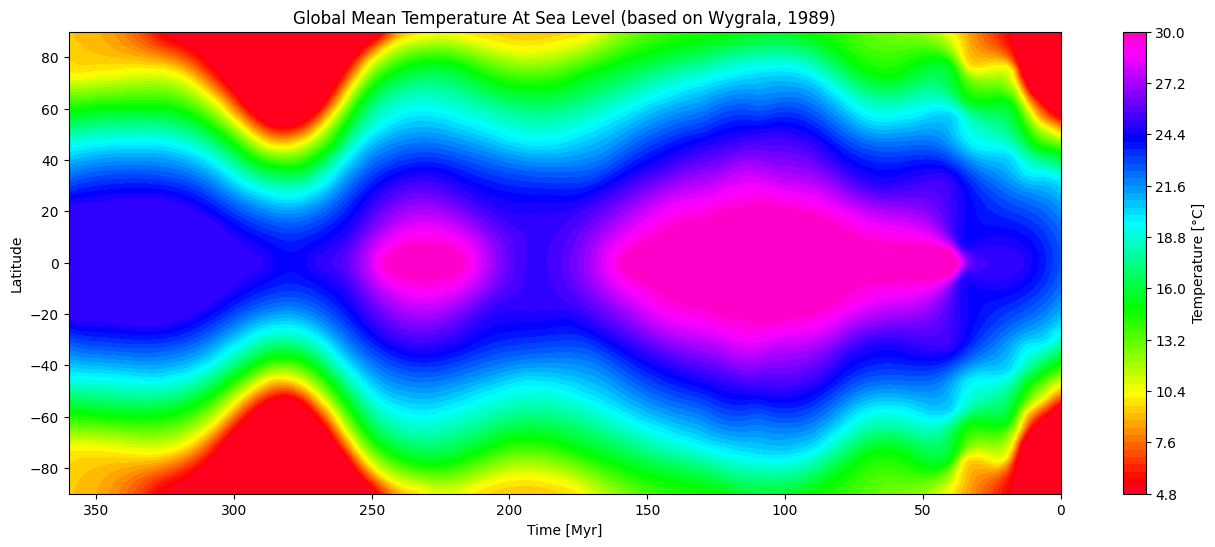

In [22]:
Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 6))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.colorbar(contour, label="Temperature [°C]")

plt.xlabel("Time [Myr]")
plt.ylabel("Latitude")
plt.title("Global Mean Temperature At Sea Level (based on Wygrala, 1989)")

plt.gca().invert_xaxis()
plt.show()

#### SWIT coordinates

In [23]:
import pandas as pd
import numpy as np


def process_paleolatitude_data(
    df: pd.DataFrame,
    reference_latitude: float
) -> pd.DataFrame:
    """
    Process paleolatitude data according to specified rules for northern and southern hemispheres.

    Args:
        df: Input DataFrame containing paleolatitude data
        reference_latitude: The reference latitude value (K) to match against current latitudes

    Returns:
        A processed DataFrame containing paleolatitude calculations with columns:
        - Continent
        - Hemisphere
        - Current_Latitude
        - Time
        - Paleolatitude
    """
    # Constants
    MAX_LATITUDE = 90
    MIN_LATITUDE = -90

    # Clean the input data
    cleaned_df = _clean_input_data(df)

    # Extract data components
    current_lats, hemispheres, continents, time_values, paleo_profiles = _extract_data_components(cleaned_df)

    # Process data according to hemisphere rules
    results = _process_hemisphere_data(
        current_lats=current_lats,
        hemispheres=hemispheres,
        continents=continents,
        time_values=time_values,
        paleo_profiles=paleo_profiles,
        reference_latitude=reference_latitude,
        max_lat=MAX_LATITUDE,
        min_lat=MIN_LATITUDE
    )

    # Format and return results
    return _format_results(results) if results else pd.DataFrame()


def _clean_input_data(df: pd.DataFrame) -> pd.DataFrame:
    """Remove rows containing explanatory text from the input DataFrame."""
    return df[~df.iloc[:, 0].str.contains('Adjusting|If Current Latitude', na=False)]


def _extract_data_components(df: pd.DataFrame) -> tuple:
    """
    Extract key data components from cleaned DataFrame.

    Returns:
        Tuple containing:
        - current_lats: Series of current latitude values
        - hemispheres: Series of hemisphere labels
        - continents: Series of continent names
        - time_values: Array of time values
        - paleo_profiles: DataFrame of paleolatitude profiles
    """
    current_lats = pd.to_numeric(df.iloc[1:, 1], errors='coerce').dropna()
    hemispheres = df.iloc[1:, 2]
    continents = df.iloc[1:, 3]
    time_values = pd.to_numeric(df.iloc[0, 4:], errors='coerce').dropna().values
    paleo_profiles = df.iloc[1:, 4:].apply(pd.to_numeric, errors='coerce')

    return current_lats, hemispheres, continents, time_values, paleo_profiles


def _process_hemisphere_data(
    current_lats: pd.Series,
    hemispheres: pd.Series,
    continents: pd.Series,
    time_values: np.ndarray,
    paleo_profiles: pd.DataFrame,
    reference_latitude: float,
    max_lat: float,
    min_lat: float
) -> list:
    """Process data according to hemisphere-specific rules."""
    results = []

    for idx, (current_lat, hemisphere, continent) in enumerate(zip(current_lats, hemispheres, continents)):
        profile = paleo_profiles.iloc[idx].dropna().values

        if len(profile) != len(time_values):
            continue

        if hemisphere == 'North' and np.isclose(current_lat, reference_latitude):
            adjusted = _calculate_adjusted_latitudes(
                profile,
                adjustment=reference_latitude,
                upper_bound=max_lat
            )
            results.append(_create_result_record(
                continent, hemisphere, current_lat, time_values, adjusted
            ))

        elif hemisphere == 'South' and np.isclose(current_lat, -reference_latitude):
            adjusted = _calculate_adjusted_latitudes(
                profile,
                adjustment=-reference_latitude,
                lower_bound=min_lat
            )
            results.append(_create_result_record(
                continent, hemisphere, current_lat, time_values, adjusted
            ))

    return results


def _calculate_adjusted_latitudes(
    profile: np.ndarray,
    adjustment: float,
    upper_bound: float = None,
    lower_bound: float = None
) -> np.ndarray:
    """
    Calculate adjusted latitudes with bounds checking.

    Args:
        profile: Array of paleolatitude values
        adjustment: Value to add to each latitude
        upper_bound: Maximum allowed latitude (optional)
        lower_bound: Minimum allowed latitude (optional)

    Returns:
        Array of adjusted latitudes respecting bounds
    """
    adjusted = profile + adjustment

    if upper_bound is not None:
        adjusted = np.where(adjusted > upper_bound, upper_bound, adjusted)
    if lower_bound is not None:
        adjusted = np.where(adjusted < lower_bound, lower_bound, adjusted)

    return adjusted


def _create_result_record(
    continent: str,
    hemisphere: str,
    current_lat: float,
    time_values: np.ndarray,
    adjusted_lats: np.ndarray
) -> dict:
    """Create a standardized result record dictionary."""
    return {
        'Continent': continent,
        'Hemisphere': hemisphere,
        'Current_Latitude': current_lat,
        'Time': time_values,
        'Paleolatitude': adjusted_lats
    }


def _format_results(results: list) -> pd.DataFrame:
    """Convert results list to properly formatted DataFrame."""
    result_df = pd.DataFrame(results)
    return result_df.explode(['Time', 'Paleolatitude'])


def analyze_results(result_df: pd.DataFrame) -> None:
    """Display analysis of processed results."""
    if result_df.empty:
        print("No matching data found for the given reference latitude")
        return

    print("\n=== Analysis Results ===")
    print(f"Total records: {len(result_df)}")
    print("\nBy Hemisphere:")
    print(result_df['Hemisphere'].value_counts())
    print("\nBy Continent:")
    print(result_df['Continent'].value_counts())
    print("\nSample Data:")
    print(result_df.head())


# Example usage
if __name__ == "__main__":
    REFERENCE_LATITUDE = 90  # The K value in the problem statement

    try:
        # Process the data
        paleo_results = process_paleolatitude_data(
            df=Database_SWIT_coordinates_,
            reference_latitude=REFERENCE_LATITUDE
        )

        # Analyze and display results
        analyze_results(paleo_results)

        # Access specific data subsets if needed
        if not paleo_results.empty:
            north_data = paleo_results[paleo_results['Hemisphere'] == 'North']
            # south_data = paleo_results[paleo_results['Hemisphere'] == 'South']
            europe_data = paleo_results[paleo_results['Continent'] == 'Central Asia'] # The main variable to choose

    except Exception as e:
        print(f"Error processing data: {str(e)}")


=== Analysis Results ===
Total records: 361

By Hemisphere:
Hemisphere
North    361
Name: count, dtype: int64

By Continent:
Continent
Europe    361
Name: count, dtype: int64

Sample Data:
  Continent Hemisphere  Current_Latitude Time Paleolatitude
0    Europe      North              90.0  0.0          90.0
0    Europe      North              90.0  1.0          89.6
0    Europe      North              90.0  2.0          89.2
0    Europe      North              90.0  3.0          89.0
0    Europe      North              90.0  4.0          88.6


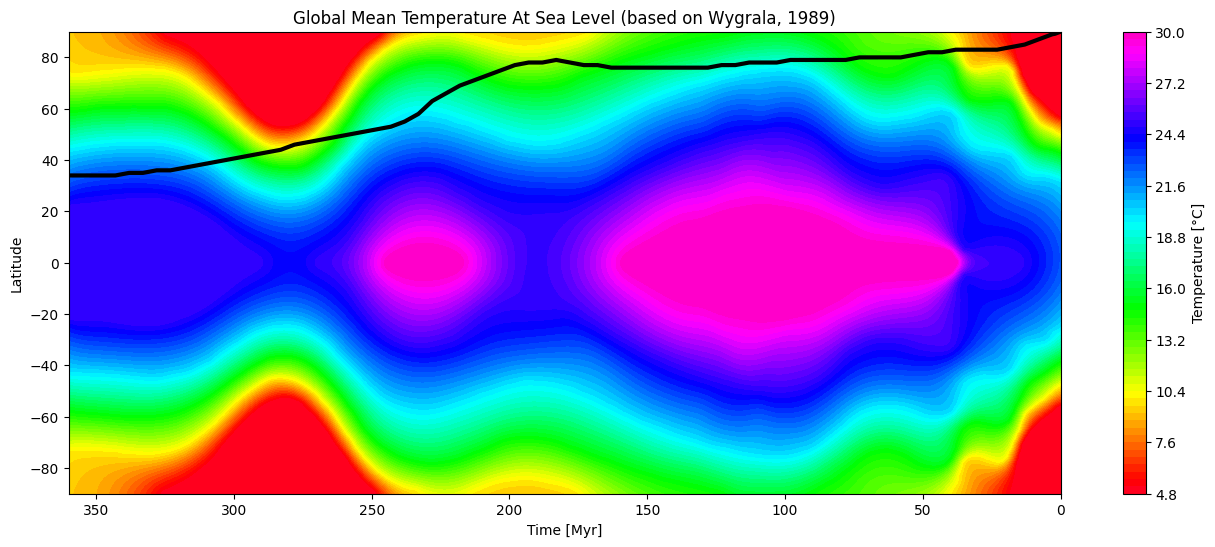

In [24]:
Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 6))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.plot(paleo_results["Time"], paleo_results["Paleolatitude"], color='black', lw=3)

plt.colorbar(contour, label="Temperature [°C]")

plt.xlabel("Time [Myr]")
plt.ylabel("Latitude")
plt.title("Global Mean Temperature At Sea Level (based on Wygrala, 1989)")

plt.gca().invert_xaxis()
plt.show()

#### Global eustatic curve

In [25]:
Database_Global_eustatic_curve.head(5)

,"Haq, 2005 (compiled)",Unnamed: 1,Unnamed: 2,"Haq, 1987 (long)",Unnamed: 4,Unnamed: 5,"Haq, 1987 (short)",Unnamed: 7,Unnamed: 8,"Watts, 1979",...,Unnamed: 40,Rescaled datasets used,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,Time,Relative sea level,NaN,Time,Relative sea level,NaN,Time,Relative sea level,NaN,Time,...,NaN,Time,"Haq, 2005 (compiled)","Haq, 1987 (long)","Watts, 1979","Watts, 1984","Pitman, 1978","Vail, 1978","Miller, 2005 (long)","Miller, 2008 (average)"
1,0,0,NaN,0,50,NaN,0,0,NaN,0,...,NaN,0,0,50,0,-0.5001,-0.10582,0,0,50
2,0.1,-0.92542,NaN,0.1,56.70335,NaN,0.2,72.33343,NaN,0.1,...,NaN,0.1,-0.92542,56.70335,-0.5288,-0.38433,-0.10552,0,-6.79067,54.92094
3,0.2,-0.81927,NaN,1.1,64.62095,NaN,0.3,78.56332,NaN,0.2,...,NaN,0.2,-0.81927,57.49511,-0.5285,-0.26856,-0.10522,0,-9.606015,54.92124
4,0.3,-0.71312,NaN,2.1,71.95887,NaN,0.4,82.0459,NaN,0.3,...,NaN,0.3,-0.71312,58.28687,-0.52819,-0.15279,-0.10491,0.0,-12.42136,54.92154


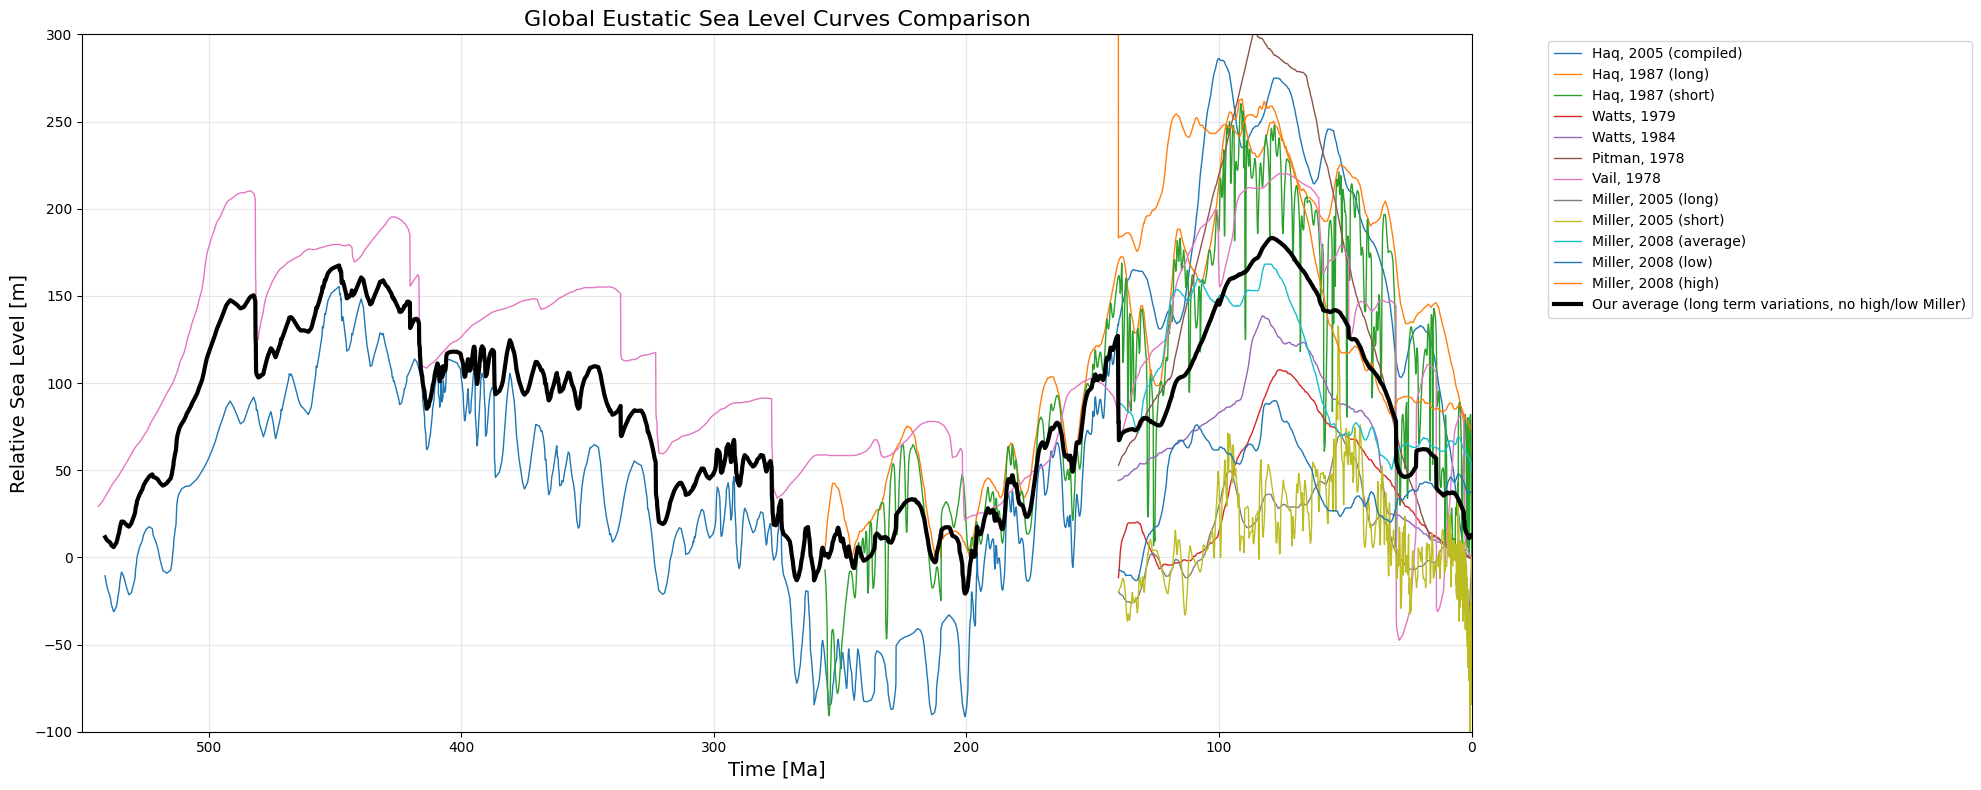

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = Database_Global_eustatic_curve

model_headers = [col for col in df.columns
                if not str(col).startswith('Unnamed')
                and "Rescaled datasets used" not in str(col)]
model_data = {}

for model in model_headers:
    start_col = df.columns.get_loc(model)

    # Extract data ensuring list format
    time = df.iloc[1:, start_col].dropna().astype(float).values
    sea_level = df.iloc[1:, start_col + 1].dropna().astype(float).values

    if len(time) == 0 or len(sea_level) == 0:
        continue

    model_df = pd.DataFrame({
        'Time': time.tolist(),
        'Relative sea level': sea_level.tolist()
    })

    if not model_df.empty:
        model_data[model] = model_df


plt.figure(figsize=(20, 8))
for model_name, data in model_data.items():
    plot_args = {
        'linewidth': 3 if "Our average" in model_name else 1,
        'color': 'black' if "Our average" in model_name else None,
        'label': model_name
    }
    plt.plot(data['Time'], data['Relative sea level'], **plot_args)


plt.xlabel('Time [Ma]', fontsize=14)
plt.ylabel('Relative Sea Level [m]', fontsize=14)
plt.title('Global Eustatic Sea Level Curves Comparison', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 550)
plt.ylim(-100, 300)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

# Layers Subdivision

In [27]:
# Кол-во слоев по которым будет проходит расчет.
# Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [28]:
# work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers = df_well[1:df_well.shape[0]] ### Слои, по которым идет расчет
work_layers_initial = work_layers.copy()
work_layers_initial

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestone (organic rich - typical),125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,0.0,NaN,NaN,NaN,NaN


In [29]:
work_layers['Sublayers'] = 'On'
work_layers['N sublayers'] = int(1)
# work_layers.loc[work_layers['Event_name'] == 'Layer 7', 'Sublayers'] = 'On'
# work_layers.loc[work_layers['Event_name'] == 'Layer 7', 'N sublayers'] = int(1)

<ipython-input-29-2496218272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_layers['Sublayers'] = 'On'
<ipython-input-29-2496218272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_layers['N sublayers'] = int(1)


In [30]:
work_layers[0:]

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.00,0.20,200,NaN,300,0,On,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.20,0.45,250,NaN,325,40,On,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.45,1.20,750,NaN,350,50,On,1,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.20,2.50,1300,NaN,300,100,On,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.50,3.40,900,NaN,200,80,On,1,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestone (organic rich - typical),125,3.40,3.60,200,NaN,20,70,On,1,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.60,4.00,400,NaN,20,-40,On,1,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.00,4.25,250,NaN,10,-20,On,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,1,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,1,NaN,NaN,NaN,NaN


In [31]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

In [32]:
df_well.iloc[-1]

,11
Well,Test_well
Event_name,Fundament
Event_type,Deposition
Lithology_type,NaN
Age (Ma),260
"Depth top, m",5.4
"Depth bottom, m",5.4
"Thickness, m",0
"D Thickness (erosion), m",NaN
"Paleobathymetry, Ma",-20


In [33]:
def layers_subdivision(work_layers, on=True):

  df_repeated = pd.DataFrame()

  if on == False:
    return work_layers

  else:

    result_df = pd.DataFrame()
    work_layers_copy = work_layers[0:].copy()

    for index, row in work_layers_copy.iterrows():
        if not pd.isnull(row['N sublayers']):
            # Calculate the interval value
            print(row['Depth bottom, m'], row['Depth top, m'], int(row['N sublayers']))
            interval = (row['Depth bottom, m'] - row['Depth top, m']) / int(row['N sublayers'])
            interval_thickness = row['Thickness, m'] / (int(row['N sublayers']))

            interval_age = 0
            next_index = index + 1
            if next_index < len(work_layers_copy):
              next_row = work_layers_copy.loc[next_index]
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))
            else:
              last_row= df_well.iloc[-1]
              next_row = last_row
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))

            # Repeat the row 'div' times and append to the new DataFrame
            repeated_rows = [row.copy() for _ in range(int(row['N sublayers']))]
            for i, r in enumerate(repeated_rows):
                r['Event_name'] = row['Event_name'] + f'_{i+1}'
                r['Depth top, m'] = row['Depth top, m'] + i * interval
                r['Depth bottom, m'] = row['Depth top, m'] + (i + 1) * interval
                r['Thickness, m'] = interval_thickness
                r['Age (Ma)'] = row['Age (Ma)'] + i*interval_age
            df_repeated = pd.concat([df_repeated, pd.DataFrame(repeated_rows)], ignore_index=True)
        else:
            df_repeated = pd.concat([df_repeated, pd.DataFrame([row])], ignore_index=True)

    return df_repeated

In [34]:
work_layers = layers_subdivision(work_layers, on=True)
# work_layers = layers_subdivision(work_layers, on=True)
###
  # on = True make subdivision
###

0.2 0.0 1
0.45 0.2 1
1.2 0.45 1
2.5 1.2 1
3.4 2.5 1
3.6 3.4 1
4.0 3.6 1
4.25 4.0 1
5.0 4.25 1
5.4 5.0 1
5.4 5.4 1


In [35]:
work_layers_copy_initial = work_layers.copy()

In [36]:
work_layers_copy_initial

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Layer 10_1,Erosion,Shale (typical),0.0,0.00,0.20,200.0,NaN,300,0,On,1,NaN,NaN,NaN,NaN
1,Test_well,Layer 9_1,Deposition,Sandstone (typical),45.0,0.20,0.45,250.0,NaN,325,40,On,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 8_1,Deposition,Shale (typical),55.0,0.45,1.20,750.0,NaN,350,50,On,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 7_1,Deposition,Chalk (typical),80.0,1.20,2.50,1300.0,NaN,300,100,On,1,NaN,NaN,NaN,NaN
4,Test_well,Layer 6_1,Deposition,Sandstone (typical),100.0,2.50,3.40,900.0,NaN,200,80,On,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 5_1,Deposition,Limestone (organic rich - typical),125.0,3.40,3.60,200.0,NaN,20,70,On,1,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
6,Test_well,Layer 4_1,Deposition,Dolomite (typical),145.0,3.60,4.00,400.0,NaN,20,-40,On,1,NaN,NaN,NaN,NaN
7,Test_well,Layer 3_1,Deposition,Sandstone (typical),160.0,4.00,4.25,250.0,NaN,10,-20,On,1,NaN,NaN,NaN,NaN
8,Test_well,Layer 2_1,Deposition,Anhydrite,210.0,4.25,5.00,750.0,NaN,20,0,On,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 1_1,Deposition,Quartzite,245.0,5.00,5.40,400.0,NaN,0,0,On,1,NaN,NaN,NaN,NaN


### Lithology

In [37]:
df_well["Lithology_type"].tolist()

[nan,
 'Shale (typical)',
 'Sandstone (typical)',
 'Shale (typical)',
 'Chalk (typical)',
 'Sandstone (typical)',
 'Limestone (organic rich - typical)',
 'Dolomite (typical)',
 'Sandstone (typical)',
 'Anhydrite',
 'Quartzite',
 nan]

In [38]:

lithology_numbers = {30000: {'lith':'Sandstone (typical)', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone (typical)', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shale (typical)', 'lith_num':3, 'hatch':'-.. ', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite (typical)', 'lith_num':5, 'hatch':'-\\', 'color':'blue'},
                 70000: {'lith':'Limestone (organic rich - typical)', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk (typical)', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'-/', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'oo', 'color':'#ffe119'},
                 93000: {'lith':'nan', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [39]:
# lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
#                  65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
#                  65000: {'lith':'Shales', 'lith_num':3, 'hatch':'-.. ', 'color':'#bebebe'},
#                  80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
#                  74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-\\', 'color':'blue'},
#                  70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
#                  70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
#                  88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
#                  86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'-/', 'color':'#ff80ff'},
#                  99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
#                  90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'oo', 'color':'#ffe119'},
#                  93000: {'lith':'nan', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [40]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.reset_index(inplace=True)

df_lith

,index,lith,lith_num,hatch,color
0,30000,Sandstone (typical),1,..,#ffff00
1,65030,Sandstone (typical),2,-.,#ffe119
2,65000,Shale (typical),3,-..,#bebebe
3,80000,Marl,4,,#7cfc00
4,74000,Dolomite (typical),5,-\,blue
5,70000,Limestone (organic rich - typical),6,+,#80ffff
6,70032,Chalk (typical),7,..,#80ffff
7,88000,Halite,8,x,#7ddfbe
8,86000,Anhydrite,9,-/,#ff80ff
9,99000,Tuff,10,||,#ff8c00


In [41]:
lithology_array = []
hatch_array = []
color_array = []

for row_index, row in enumerate(work_layers.itertuples()):

    lithology = work_layers.at[row.Index, 'Lithology_type']
    layers_name = work_layers.at[row.Index, 'Event_name']
    # print(lithology)

    lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
    lithology_array.append(lit_num)


    hatch_val = df_lith.loc[df_lith['lith'] == str(lithology), 'hatch'].iloc[0]
    hatch_array.append(hatch_val)

    color_val = df_lith.loc[df_lith['lith'] == str(lithology), 'color'].iloc[0]
    color_array.append(color_val)

work_layers_initial["Lithology"] = lithology_array
work_layers_initial["Index"] = hatch_array
work_layers_initial["Color"] = color_array
work_layers_initial # для построения графиков с литологией

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %",Lithology,Index,Color
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN,65000,-..,#bebebe
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN,30000,..,#ffff00
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN,65000,-..,#bebebe
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN,70032,..,#80ffff
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN,30000,..,#ffff00
6,Test_well,Layer 5,Deposition,Limestone (organic rich - typical),125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0,70000,+,#80ffff
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN,74000,-\,blue
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN,30000,..,#ffff00
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN,86000,-/,#ff80ff
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,0.0,NaN,NaN,NaN,NaN,90000,oo,#ffe119


In [42]:
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Layer 10_1,Erosion,Shale (typical),0.0,0.00,0.20,200.0,NaN,300,0,On,1,NaN,NaN,NaN,NaN
1,Test_well,Layer 9_1,Deposition,Sandstone (typical),45.0,0.20,0.45,250.0,NaN,325,40,On,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 8_1,Deposition,Shale (typical),55.0,0.45,1.20,750.0,NaN,350,50,On,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 7_1,Deposition,Chalk (typical),80.0,1.20,2.50,1300.0,NaN,300,100,On,1,NaN,NaN,NaN,NaN
4,Test_well,Layer 6_1,Deposition,Sandstone (typical),100.0,2.50,3.40,900.0,NaN,200,80,On,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 5_1,Deposition,Limestone (organic rich - typical),125.0,3.40,3.60,200.0,NaN,20,70,On,1,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
6,Test_well,Layer 4_1,Deposition,Dolomite (typical),145.0,3.60,4.00,400.0,NaN,20,-40,On,1,NaN,NaN,NaN,NaN
7,Test_well,Layer 3_1,Deposition,Sandstone (typical),160.0,4.00,4.25,250.0,NaN,10,-20,On,1,NaN,NaN,NaN,NaN
8,Test_well,Layer 2_1,Deposition,Anhydrite,210.0,4.25,5.00,750.0,NaN,20,0,On,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 1_1,Deposition,Quartzite,245.0,5.00,5.40,400.0,NaN,0,0,On,1,NaN,NaN,NaN,NaN


In [43]:
lithology_array = []
hatch_array = []
color_array = []

for row_index, row in enumerate(work_layers_initial.itertuples()):

    lithology = work_layers_initial.at[row.Index, 'Lithology_type']
    layers_name = work_layers_initial.at[row.Index, 'Event_name']
    # print(lithology)

    lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
    lithology_array.append(lit_num)


    hatch_val = df_lith.loc[df_lith['lith'] == str(lithology), 'hatch'].iloc[0]
    hatch_array.append(hatch_val)

    color_val = df_lith.loc[df_lith['lith'] == str(lithology), 'color'].iloc[0]
    color_array.append(color_val)

work_layers["Lithology"] = lithology_array
work_layers["Index"] = hatch_array
work_layers["Color"] = color_array
work_layers_with_color = work_layers.copy()
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %",Lithology,Index,Color
0,Test_well,Layer 10_1,Erosion,Shale (typical),0.0,0.00,0.20,200.0,NaN,300,0,On,1,NaN,NaN,NaN,NaN,65000,-..,#bebebe
1,Test_well,Layer 9_1,Deposition,Sandstone (typical),45.0,0.20,0.45,250.0,NaN,325,40,On,1,NaN,NaN,NaN,NaN,30000,..,#ffff00
2,Test_well,Layer 8_1,Deposition,Shale (typical),55.0,0.45,1.20,750.0,NaN,350,50,On,1,NaN,NaN,NaN,NaN,65000,-..,#bebebe
3,Test_well,Layer 7_1,Deposition,Chalk (typical),80.0,1.20,2.50,1300.0,NaN,300,100,On,1,NaN,NaN,NaN,NaN,70032,..,#80ffff
4,Test_well,Layer 6_1,Deposition,Sandstone (typical),100.0,2.50,3.40,900.0,NaN,200,80,On,1,NaN,NaN,NaN,NaN,30000,..,#ffff00
5,Test_well,Layer 5_1,Deposition,Limestone (organic rich - typical),125.0,3.40,3.60,200.0,NaN,20,70,On,1,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0,70000,+,#80ffff
6,Test_well,Layer 4_1,Deposition,Dolomite (typical),145.0,3.60,4.00,400.0,NaN,20,-40,On,1,NaN,NaN,NaN,NaN,74000,-\,blue
7,Test_well,Layer 3_1,Deposition,Sandstone (typical),160.0,4.00,4.25,250.0,NaN,10,-20,On,1,NaN,NaN,NaN,NaN,30000,..,#ffff00
8,Test_well,Layer 2_1,Deposition,Anhydrite,210.0,4.25,5.00,750.0,NaN,20,0,On,1,NaN,NaN,NaN,NaN,86000,-/,#ff80ff
9,Test_well,Layer 1_1,Deposition,Quartzite,245.0,5.00,5.40,400.0,NaN,0,0,On,1,NaN,NaN,NaN,NaN,90000,oo,#ffe119


<ipython-input-44-1546355783>:14: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.fill_betweenx(y, 0, 1, facecolor='none',


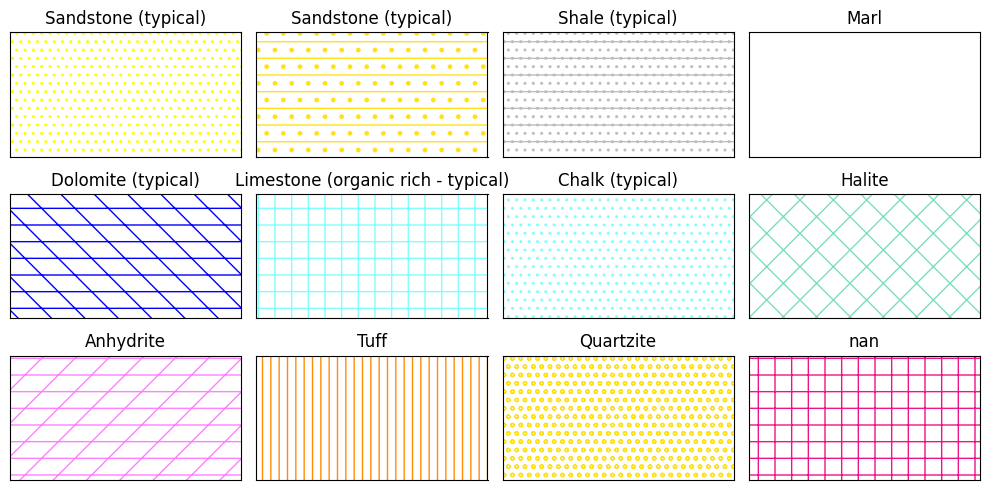

In [44]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
  ax.plot(x, y)
  if lithology_numbers[key]['lith'] == 'Shales':
    ax.fill_betweenx(y, 0, 1, facecolor='none', edgecolor='gray', hatch='_-_')

  else:
      # ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.fill_betweenx(y, 0, 1, facecolor='none',
                    edgecolor=lithology_numbers[key]['color'],         # Hatch color
                    hatch=lithology_numbers[key]['hatch'],  # e.g., '--', '..', 'xx'
                    linewidth=0.5              # Controls hatch thickness
  )

  ax.set_xlim(0, 0.1)
  ax.set_ylim(0, 1)
  ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

## Decompacted Thickness, Porosity \& Permeability, Density



Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, permeability density).




In [45]:
import numpy as np
from scipy.special import lambertw

def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [46]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [47]:
### the average porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [48]:
def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [49]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [50]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [51]:
def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, S, k):
    phi_corrected = phi - 3.1 * 10e-10
    if phi_corrected < 0.1:
        return 2 * 10**16 * k * (phi_corrected**5 / (S**2 * (1 - phi_corrected)**2))
    else:
        return 2 * 10**14 * k * (phi_corrected**3 / (S**2 * (1 - phi_corrected)**2))

In [52]:
def sedimentaiton_rate(depth, years):
  return depth / (age if age != 0 else 1e20)

In [53]:
def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=1040):

    """
    Calculate cumulative hydrostatic pressures for each layer.

    Parameters:
    - depths: List or array of bottom depth of each layer (m)
    - water_depth: Depth of water (m)
    - sediment_surface: Depth of sediment surface (m)
    - rho_water: Constant value of sea water density (kg/m^3)

    Returns:
    - List of cumulative pressures (MPa) for each layer and depth array
    """

    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [quad(lambda z: rho_water * g, sea_level, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa

    return pressures

In [54]:
def lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level,
                          water_depth, sediment_surface):
    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)
    - water_depth: Constant value of a water depth (m)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0

    if sediment_surface < 0:

      filtered_depths = np.insert(layer_bottom_depth, 0, sediment_surface)
      rock_densities = np.insert(rock_densities, 0, 0)
      porosities = np.insert(porosities, 0, 0)    # Add sediment porosity at the start


      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):
        total_pressure = 0
        effective_density = density * (1 - porosity) + rho_sea*porosity

        water_pressure = rho_sea * g * water_depth
        pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
        total_pressure += water_pressure
        total_pressure += pressure_increment

        pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

    else:

      filtered_depths = [depth for depth in layer_bottom_depth if depth > sediment_surface]
      filtered_depths.insert(0, sediment_surface)

      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):

          total_pressure = 0
          effective_density = density * (1 - porosity) + rho_sea*porosity

          water_pressure = rho_sea * g * water_depth
          pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
          total_pressure += water_pressure
          total_pressure += pressure_increment

          pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

Chech parametrs for lithology in **Database_Lithotypes**

In [55]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Anhydrite']
sandstone_row.columns

# Find all columns containing 'exp' (case-insensitive)
exp_columns = [
    col for col in sandstone_row.columns
    if pd.notna(col) and 'adiogenic' in str(col).lower()
]

if exp_columns:
    print("✅ Columns containing :")
    for col in exp_columns:
        print(f"- {col}")
else:
    print("❌ No columns contain")

✅ Columns containing :
- Radiogenic model key


Reference

In [56]:
import numpy as np
import pandas as pd


# Initialize result DataFrames
decompaction_df = pd.DataFrame()
decompaction_corrected_df = pd.DataFrame()
porosity_df = pd.DataFrame()
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()
permeability_df = pd.DataFrame()
sedimentation_rate_df = pd.DataFrame()
vp_df = pd.DataFrame()
vs_df = pd.DataFrame()

# Add these constants at the top with your other constants
DEFAULT_R = 1e6    # Grain radius
DEFAULT_TAU = 1.5  # Tortuosity factor
DEFAULT_S = 1e6    # Specific surface area (m²/m³)
DEFAULT_K = 1      # Permeability factor

LITHOLOGY_S_VALUES = {
    "Shale (typical)": 1e10,          # High S for shales (organic-rich, fine-grained)
    "Sandstone (typical)": 1e5,      # Moderate S for sandstones
    "Chalk (typical)": 1e20,         # Extremely high S (nanoporous)
    "Limestone (organic rich - typical)": 1e6,  # High S due to organic content
    "Dolomite (typical)": 1e10,      # Very high S (crystalline porosity)
    "Anhydrite": 1e20,               # Extremely low permeability
    "Quartzite": 1e20                # Dense, low-permeability
}

# Prepare age list
age_list = list(work_layers['Age (Ma)'].unique())
# age_list.append(df_well['Age (Ma)'].iloc[-1])
# print(age_list)

# Constants
RoWater, RoMantle = 1000, 3300

for i, age in enumerate(age_list):
    print(f'\nProcessing age {i}: {age} Ma')

    # Make a copy of work layers for this iteration
    work_layers_copy = work_layers[:10]

    # Initialize lists for this age
    thickness_list = []
    thickness_corrected_list = []
    porosity_list = []
    density_list = []
    density_column_values = []
    permeability_list = []
    sedimentaiton_rate_list = []
    vp_list, vs_list = [], []

    # Process each layer
    for row_index, row in work_layers_copy.iloc[i:].iterrows():
        try:
            lithology = row['Lithology_type']
            layers_name = row['Event_name']

            # Safely get lithology parameters with defaults
            lith_mask = (work_layers_copy['Lithology_type'] == str(lithology))
            PWD = work_layers_copy.loc[lith_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if lith_mask.any() else 0
            eustatic = work_layers_copy.loc[lith_mask, 'Sea level, m'].iloc[0]/1000 if lith_mask.any() else 0
#---------------
            # # const_mask = (df_constast['Lithology_type'] == str(lithology))
            # const_mask = (Database_Lithotypes['Lithology_type'] == str(lithology))
            # if const_mask.any():
            # #     # phi0 = df_constast.loc[const_mask, 'Porosity'].values[0]
            # #     # c = df_constast.loc[const_mask, 'Exp_decay, km-1'].values[0]
            # #     # RoGrain = df_constast.loc[const_mask, 'Grain density'].values[0]

            #     phi0 = Database_Lithotypes.loc[const_mask, "Initial porosity"]
            #     c = Database_Lithotypes.loc[const_mask, "Athy factor k (depth)"].values[0]
            #     RoGrain = Database_Lithotypes.loc[const_mask, "Density"].values[0]

            #     print(lithology, phi0, c, RoGrain)

#---------------
# Find matching lithology in Database_Lithotypes
            lithology_match = Database_Lithotypes[Database_Lithotypes['Lithology type'] == str(lithology)]
            phi0 = lithology_match['Initial porosity'].iloc[0]/100
            c = lithology_match['Athy factor k (depth)'].iloc[0]
            c = 1e-10 if c == 0 else c  # Handle zero porosity case
            RoGrain = lithology_match['Density'].iloc[0]

            try:
                # Grain radius
                r = lithology_match['Grain radius (m)'].iloc[0] if 'Grain radius (m)' in lithology_match.columns else DEFAULT_R

                # Tortuosity
                tau = lithology_match['Tortuosity'].iloc[0] if 'Tortuosity' in lithology_match.columns and not pd.isna(lithology_match['Tortuosity'].iloc[0]) else DEFAULT_TAU


                # Corrected specific surface assignment
                # NOT ASSIGN IN LITHOLOGY DATABASE !!!!
                if lithology in LITHOLOGY_S_VALUES:
                    S = LITHOLOGY_S_VALUES[lithology]
                elif 'Specific surface' in lithology_match.columns:
                    S_value = lithology_match['Specific surface'].iloc[0]
                    S = DEFAULT_S if pd.isna(S_value) else (1e20 if S_value == 0 else S_value)
                else:
                    S = DEFAULT_S

                # Permeability factor
                k_factor = lithology_match['Permeability factor'].iloc[0] if 'Permeability factor' in lithology_match.columns else DEFAULT_K

                # Bulk modulus
                K = lithology_match['Constant Value 2'].iloc[0]  # in MPa Bulk modulus
                G = lithology_match['Shear Modulus'].iloc[0]  # in MPa


            except Exception as e:
                print(f"Warning: Using default permeability parameters for {lithology}")
                r, tau, S, k_factor = DEFAULT_R, DEFAULT_TAU, DEFAULT_S, DEFAULT_K
#--------------
            y1 = row['Depth top, m']
            y2 = row['Depth bottom, m']

            # Decompaction calculations
            if row_index == i:  # First layer
                y1_d = 0
                if age != 0:
                    y1_d_corrected = corrected(y1_d, RoMantle, RoWater, PWD, eustatic)
                    # thickness_corrected_list.append(y1_d_corrected) # ---> добавление крови слоя
            else:  # Subsequent layers
                y1_d = y2_d
                y1_d_corrected = y2_d_corrected

            # Core calculations
            if age == 0:
                age_mask = (work_layers_copy['Age (Ma)'] == int(age))
                PWD = work_layers_copy.loc[age_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if age_mask.any() else 0
                y2_d = y2 + PWD
                thickness = y2_d - y1_d
                thickness_list.append(np.round(thickness, 3))

                y2_d_corrected = y2_d
                thickness_corrected_list.append(np.round(y2_d_corrected, 3))

            # elif age == age_list[-1]:
            elif age == 260:
              depth = 0
              depth = 0.3
              # y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, 0, 0), 3))
              y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, PWD, eustatic), 3))
              thickness_corrected_list.append(y2_d_corrected)

            else:
                y2_d = decomp_func(y1, y2, y1_d, phi0, c)
                thickness = y2_d - y1_d
                thickness_list.append(np.round(thickness, 3))

                y2_d_corrected = corrected(y2_d, RoMantle, RoWater, PWD, eustatic)
                thickness_corrected_list.append(np.round(y2_d_corrected, 3))

            # float_values = [x.item() for x in thickness_corrected_list]
            # print(float_values )

            porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thickness), 3)
            porosity_list.append(porosity)

            density = int(np.round(bulk_density(porosity, RoGrain, RoWater), 2))
            density_list.append(density)

            density_column = (porosity*RoWater + (1-porosity)*RoGrain)*thickness
            density_column_values.append(density_column)

            # Calculate permeability

            # # Determine k_factor based on conditions
            # # Apply porosity-based adjustments
            # if porosity < 0.1:  # Very low porosity
            #     k_factor = 0.05
            # elif 0.1 <= phi0 < 0.2:  # Medium porosity
            #     porosity = 0.5
            # else:  # High porosity (phi0 >= 0.5)
            #     porosity = 10

            kc2 = Kozeny_Carman_lithology(porosity, S, k_factor)
            permeability = kc2
            permeability_list.append(permeability)

            ### Sedimentation rate
            SD_value = sedimentaiton_rate(y2_d, age)
            sedimentaiton_rate_list.append(SD_value)

            ### Calculation of P-wave velocity (Vp) and S-wave velocity (Vs)

            if density > 0:
                v_p = np.sqrt((K*1e6 + (4/3)*G*1e6) / density)
                v_s = np.sqrt(G*1e6 / density)
            else:
                v_p, v_s = 0, 0

            # Convert to km/s and round
            v_p = np.round(v_p / 1000, 3)  # m/s to km/s
            v_s = np.round(v_s / 1000, 3)  # m/s to km/s

            vp_list.append(v_p)
            vs_list.append(v_s)

            # print(lithology, K, G, density, v_p, v_s)


        except Exception as ex:
            print(f"Error processing row {row_index} (Lithology: {lithology}): {str(ex)}")
            continue

    # Calculate average density for the column
    if age != age_list[-1] and thickness_list:
        density_col = sum(density_column_values)/sum(thickness_list)
        density_column_total = np.round(density_col, 3)
    else:
        density_col = 0
        density_column_total = 0

    # Store results in the desired format
    new_col_name = f'{age}'

    # Decompaction results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(thickness_list):] = thickness_list
    decompaction_df[new_col_name] = resized_list

    # Corrected decompaction
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(thickness_corrected_list):] = thickness_corrected_list
    decompaction_corrected_df[new_col_name] = resized_list

    # Porosity
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_list):] = porosity_list
    porosity_df[new_col_name] = resized_list

    # Density
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    density_df[new_col_name] = resized_list

    # Column density
    density_column_df[new_col_name] = [density_column_total]

    # Store permeability results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(permeability_list):] = permeability_list
    permeability_df[new_col_name] = resized_list

    # Store sedomentatin rate results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(sedimentaiton_rate_list):] = sedimentaiton_rate_list
    sedimentation_rate_df[new_col_name] = resized_list

    # Store Vp results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = vp_list
    vp_df[new_col_name] = resized_list

    # Store Vs results
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = vs_list
    vs_df[new_col_name] = resized_list


Processing age 0: 0.0 Ma

Processing age 1: 45.0 Ma

Processing age 2: 55.0 Ma

Processing age 3: 80.0 Ma

Processing age 4: 100.0 Ma

Processing age 5: 125.0 Ma

Processing age 6: 145.0 Ma

Processing age 7: 160.0 Ma

Processing age 8: 210.0 Ma

Processing age 9: 245.0 Ma

Processing age 10: 260.0 Ma


## Function to save to csv

In [57]:
# File save
def save_to_csv(pd_name, work_layers, output_filename):
    work_layers.reset_index(drop=True, inplace=True)
    pd_name['Event_name'] = work_layers['Event_name']
    pd_name['Lithology_type'] = work_layers['Lithology_type']
    pd_name = pd_name[pd_name.columns[::-1]]

    return pd_name.to_csv(str(output_filename), index=True)

In [58]:
save_to_csv(porosity_df, work_layers, "Porosity-2.csv")

In [59]:
save_to_csv(np.round(vp_df, 2), work_layers, "Vp.csv")
save_to_csv(np.round(vs_df, 2), work_layers, "Vs.csv")

## Permeability Results & Visualization

In [60]:
save_to_csv(permeability_df, work_layers, "Permeability.csv")

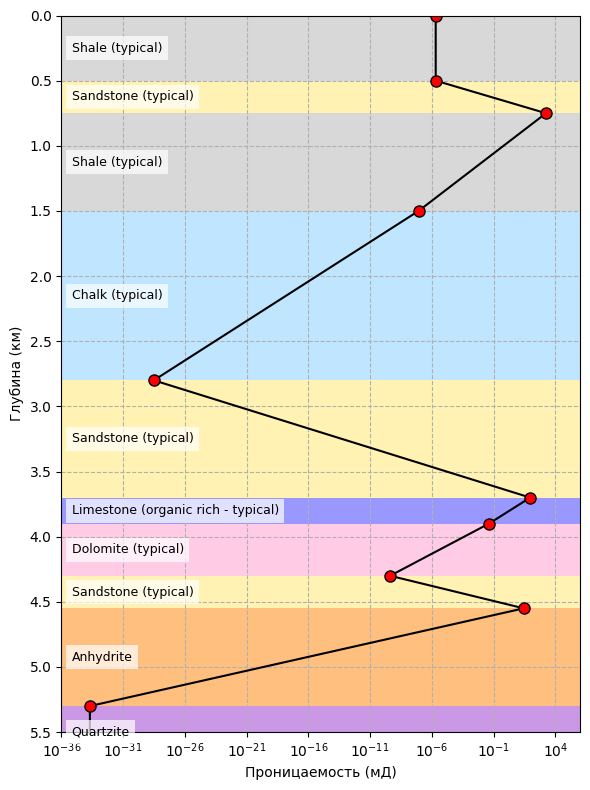

In [61]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

def plot_permeability_depth_profile(
    permeability_df,
    decompaction_corrected_df,
    ylim=None,
    yticks=None,
    xlim=None,
    xticks=None
):
    # Get data for age 0
    age_0_col = '0.0'
    permeability_age_0 = permeability_df[age_0_col].values
    depths = decompaction_corrected_df[age_0_col].values  # Depth values in km

    # Ensure the first depth starts at 0
    if depths[0] != 0:
        depths = np.insert(depths, 0, 0)
        permeability_age_0 = np.insert(permeability_age_0, 0, permeability_age_0[0])

    # Geological layers data
    geological_layer_names = [
        'Shale (typical)',
        'Sandstone (typical)',
        'Shale (typical)',
        'Chalk (typical)',
        'Sandstone (typical)',
        'Limestone (organic rich - typical)',
        'Dolomite (typical)',
        'Sandstone (typical)',
        'Anhydrite',
        'Quartzite'
    ]

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))

    # Define colors
    lithology_colors = {
        'Shale (typical)': (0.7, 0.7, 0.7, 0.5),
        'Sandstone (typical)': (1.0, 0.9, 0.4, 0.5),
        'Chalk (typical)': (0.5, 0.8, 1.0, 0.5),
        'Limestone (organic rich - typical)': (0.2, 0.2, 1.0, 0.5),
        'Dolomite (typical)': (1.0, 0.6, 0.8, 0.5),
        'Anhydrite': (1.0, 0.5, 0.0, 0.5),
        'Quartzite': (0.6, 0.2, 0.8, 0.5)
    }

    # Add geological background starting from 0 depth
    for i in range(len(depths)-1):
        layer_name = geological_layer_names[i % len(geological_layer_names)]
        depth = depths[i]
        next_depth = depths[i+1]

        ax.axhspan(depth, next_depth,
                  facecolor=lithology_colors[layer_name],
                  edgecolor='none')

        # Add layer name in the middle of each band
        midpoint = (depth + next_depth) / 2
        ax.text(0.02, midpoint, layer_name,
                va='center', ha='left', fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                transform=ax.get_yaxis_transform())

    # Plot permeability data
    ax.plot(permeability_age_0, depths, 'ko-',
            markersize=8, linewidth=1.5,
            markerfacecolor='red', markeredgecolor='black')

    # Formatting
    ax.set_xscale('log')
    ax.set_xlabel('Проницаемость (мД)')
    ax.set_ylabel('Глубина (км)')
    ax.grid(True, which="both", ls="--")
    ax.invert_yaxis()

    # Set axis limits and ticks
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim((max(depths), 0))  # Auto scale with 0 at top

    if yticks is not None:
        ax.set_yticks(yticks)

    if xlim is not None:
        ax.set_xlim(xlim)

    if xticks is not None:
        ax.set_xticks(xticks)
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    plt.tight_layout()
    plt.savefig('Permeability0_vs_Depth.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

# Usage example:
plot_permeability_depth_profile(
    permeability_df,
    decompaction_corrected_df,
    ylim=(5, 0),  # From 5 km to surface (0 km)
    yticks=np.arange(0, 6.0, 0.5),  # Ticks every 0.5 km
    xlim=(1e-36, 1e6),  # Permeability range
    # xticks=np.logspace(-36, 6, num=9)  # 9 logarithmic ticks from 1e-36 to 1e6
)

## Hydro & Lithostatic Pressures

In [62]:
import numpy as np
import pandas as pd
from scipy.integrate import quad

# Initialize pressure DataFrames
hydrostatic_pressure_df = pd.DataFrame()
lithostatic_pressure_df = pd.DataFrame()

# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
RoWater = 1000  # density of fresh water in kg/m^3
RoMantle = 3300  # density of mantle material in kg/m^3

sediment_surfaces = []


def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=rho_w):
    """Calculate hydrostatic pressures accounting for sea level and sediment surface"""
    pressures = []
    for depth in depths:
        if sediment_surface >= sea_level:
            # Water column exists
            water_pressure = rho_sea * g * water_depth
            # Sediment pore water pressure
            if depth > sediment_surface:
                sediment_pressure = quad(lambda z: rho_water * g, sediment_surface, depth)[0]
            else:
                sediment_pressure = 0
        else:
            # No water column (sediment surface above sea level)
            water_pressure = 0
            sediment_pressure = quad(lambda z: rho_water * g, sea_level, depth)[0]

        total_pressure = (water_pressure + sediment_pressure) / 1e6  # Convert to MPa
        pressures.append(total_pressure)
    return pressures

def lithostatic_pressures(depths, rock_densities, porosities, sea_level, water_depth, sediment_surface):
    """Calculate lithostatic pressures accounting for sea level and sediment surface"""
    pressures = []
    total_pressure = 0

    # Water column pressure if exists
    if sediment_surface >= sea_level:
        total_pressure += rho_sea * g * water_depth

    for i, (depth, density, porosity) in enumerate(zip(depths, rock_densities, porosities)):
        if i == 0:
            # First layer starts at sediment surface or sea level
            start_depth = max(sediment_surface, sea_level)
        else:
            start_depth = depths[i-1]

        effective_density = density * (1 - porosity) + rho_w * porosity
        pressure_increment = quad(lambda z: effective_density * g, start_depth, depth)[0]
        total_pressure += pressure_increment

        pressures.append(total_pressure / 1e6)  # Convert to MPa

    return pressures

# Prepare age list
age_list = list(work_layers['Age (Ma)'].unique())

for i, age in enumerate(age_list):
    print(f'\nProcessing age {i}: {age} Ma')

    # Make a copy of work layers for this iteration
    work_layers_copy = work_layers[:10].copy()

    # Initialize lists for this age
    hydrostatic_p_list = []
    lithostatic_p_list = []
    depth_list = []
    density_list = []
    porosity_list = []
    y2_d_list = []
    y2_d_corrected_list = []


    # Process each layer
    for row_index, row in work_layers_copy.iloc[i:].iterrows():
        try:
            lithology = row['Lithology_type']
            layers_name = row['Event_name']

            # Get lithology parameters
            lith_mask = (work_layers_copy['Lithology_type'] == str(lithology))
            PWD = work_layers_copy.loc[lith_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if lith_mask.any() else 0
            eustatic = work_layers_copy.loc[lith_mask, 'Sea level, m'].iloc[0]/1000 if lith_mask.any() else 0

            # Get lithology properties
            lithology_match = Database_Lithotypes[Database_Lithotypes['Lithology type'] == str(lithology)]
            phi0 = lithology_match['Initial porosity'].iloc[0]/100
            c = lithology_match['Athy factor k (depth)'].iloc[0]
            c = 1e-10 if c == 0 else c
            RoGrain = lithology_match['Density'].iloc[0]

            y1 = row['Depth top, m']
            y2 = row['Depth bottom, m']

            # Decompaction calculations
            if row_index == i:  # First layer
                y1_d = 0
                if age != 0:
                    y1_d_corrected = corrected(y1_d, RoMantle, RoWater, PWD, eustatic)
            else:
                y1_d = y2_d_list[-1]
                y1_d_corrected = y2_d_corrected_list[-1] if y2_d_corrected_list else 0

            # Core calculations
            if age == 0:
                age_mask = (work_layers_copy['Age (Ma)'] == int(age))
                PWD = work_layers_copy.loc[age_mask, 'Paleobathymetry, Ma'].iloc[0]/1000 if age_mask.any() else 0
                y2_d = y2 + PWD
                y2_d_corrected = y2_d
            elif age == 260:
                depth = 0.3
                y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, PWD, eustatic), 3))
                y2_d = y2_d_corrected
            else:
                y2_d = decomp_func(y1, y2, y1_d, phi0, c)
                y2_d_corrected = corrected(y2_d, RoMantle, RoWater, PWD, eustatic)

            # Store decompacted depths
            y2_d_list.append(y2_d)
            y2_d_corrected_list.append(y2_d_corrected)

            # Calculate porosity and density
            thickness = y2_d - y1_d
            porosity = porosity_func(phi0, c, y1_d, y2_d, thickness)
            density = bulk_density(porosity, RoGrain, RoWater)

            # Store properties for pressure calculations
            depth_list.append(y2_d * 1000)
            density_list.append(density)
            porosity_list.append(porosity)

        except Exception as ex:
            print(f"Error processing row {row_index} (Lithology: {lithology}): {str(ex)}")
            continue

    # Calculate pressures for this age
    if depth_list and density_list:
        # Determine sea level and sediment surface conditions
        SEA_LEVEL = 0
        SEDIMENT_SURFACE = work_layers_copy.iloc[i]['Paleobathymetry, Ma'] if i < len(work_layers_copy) else 0
        sediment_surfaces.append(SEDIMENT_SURFACE)

        if SEDIMENT_SURFACE >= 0:
            WATER_DEPTH = SEDIMENT_SURFACE
        else:
            WATER_DEPTH = SEA_LEVEL

        # Calculate both pressure types
        pressures_hydrostatic = hydrostatic_pressures(
            depth_list,
            sea_level=SEA_LEVEL,
            sediment_surface=SEDIMENT_SURFACE,
            water_depth=WATER_DEPTH
        )

        lith_pressures = lithostatic_pressures(
            depth_list,
            density_list,
            porosity_list,
            sea_level=SEA_LEVEL,
            water_depth=WATER_DEPTH,
            sediment_surface=SEDIMENT_SURFACE
        )

        hydrostatic_p_list = pressures_hydrostatic
        lithostatic_p_list = lith_pressures

        print(f"Age {age} Ma - Hydrostatic pressures (MPa):", pressures_hydrostatic)
        print(f"Age {age} Ma - Lithostatic pressures (MPa):", lith_pressures)

    # Store results in the DataFrames
    new_col_name = f'{age}'

    # Hydrostatic pressure
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(hydrostatic_p_list):] = hydrostatic_p_list
    hydrostatic_pressure_df[new_col_name] = resized_list

    # Lithostatic pressure
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(lithostatic_p_list):] = lithostatic_p_list
    lithostatic_pressure_df[new_col_name] = resized_list

# Final DataFrames available:
# hydrostatic_pressure_df - contains hydrostatic pressure values for each age
# lithostatic_pressure_df - contains lithostatic pressure values for each age


Processing age 0: 0.0 Ma
Age 0.0 Ma - Hydrostatic pressures (MPa): [np.float64(5.27778), np.float64(7.828379999999999), np.float64(15.480179999999999), np.float64(28.743299999999998), np.float64(37.92545999999999), np.float64(39.96593999999999), np.float64(44.046899999999994), np.float64(46.59749999999999), np.float64(54.24929999999999), np.float64(58.33025999999999)]
Age 0.0 Ma - Lithostatic pressures (MPa): [np.float64(5.852630780665549), np.float64(10.187653661318429), np.float64(24.11834382691704), np.float64(54.01270849524544), np.float64(73.86165382649389), np.float64(78.6755833497624), np.float64(88.675191659106), np.float64(94.5242059693622), np.float64(116.09048787336033), np.float64(126.36181292288313)]

Processing age 1: 45.0 Ma
Age 45.0 Ma - Hydrostatic pressures (MPa): [np.float64(3.507075), np.float64(11.157553763349476), np.float64(24.661908714666364), np.float64(33.900798391815215), np.float64(35.95068114046358), np.float64(40.04491470377063), np.float64(42.60519074554

<ipython-input-63-2078791619>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')  # Changed from get_cmap to cm.get_cmap


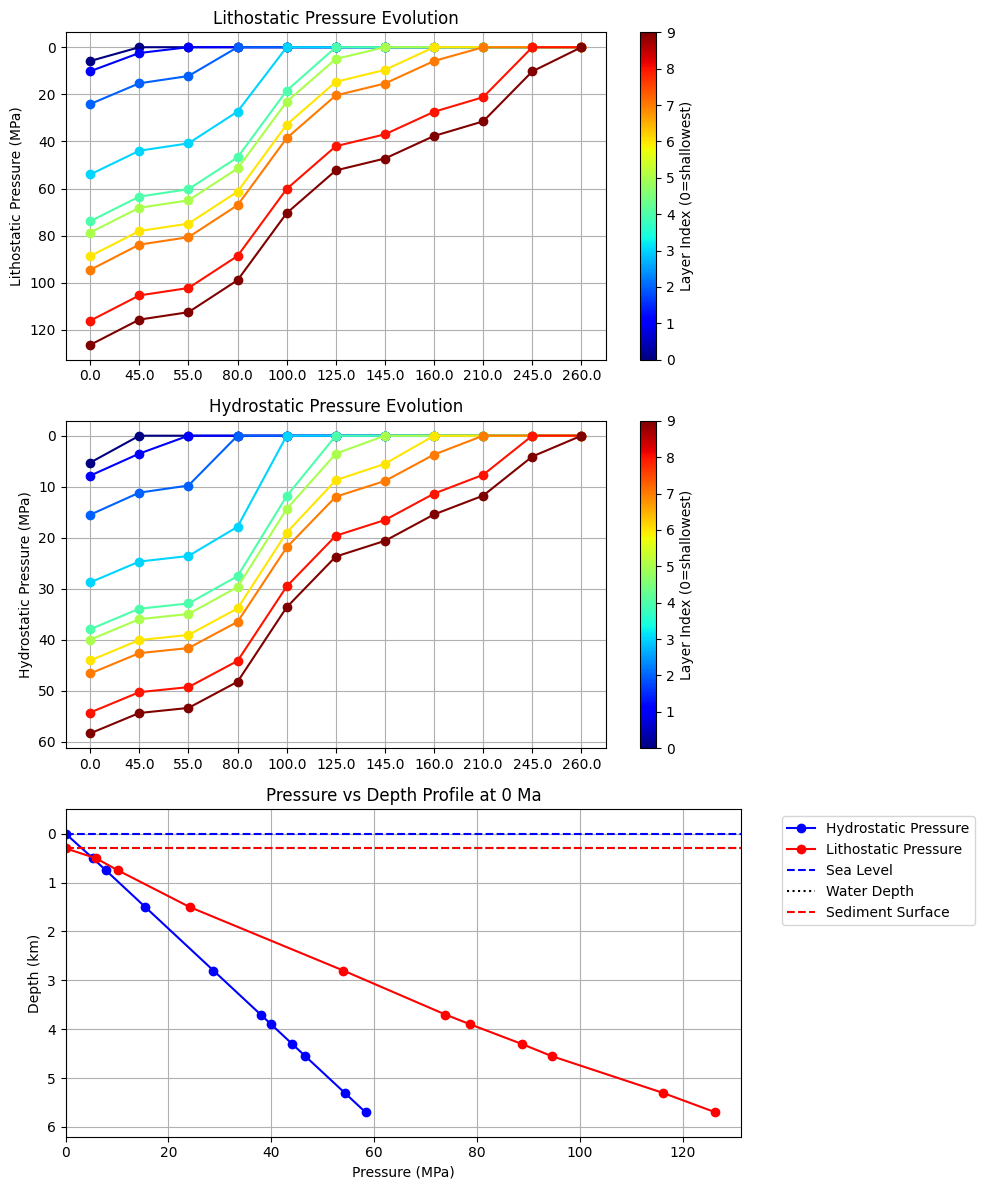

In [63]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np

def plot_pressure_profiles(lithostatic_pressure_df, hydrostatic_pressure_df, decompaction_corrected_df, sediment_surfaces):
    ages = lithostatic_pressure_df.columns.values

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=False)

    # --- Plot 1: Lithostatic Pressure vs Age ---
    colormap = cm.get_cmap('jet')  # Changed from get_cmap to cm.get_cmap
    norm_lith = Normalize(vmin=0, vmax=len(lithostatic_pressure_df)-1)

    # Plot layers in natural order (Layer 0 at top) with colormap
    for idx, (index, row) in enumerate(lithostatic_pressure_df.iterrows()):
        color = colormap(norm_lith(idx))
        ax1.plot(ages, row, color=color, lw=1.5, marker='o', markersize=6, label=f'Layer {index}')

    ax1.set_ylabel('Lithostatic Pressure (MPa)')
    ax1.set_title('Lithostatic Pressure Evolution')
    ax1.invert_yaxis()
    ax1.grid(True)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add colorbar for lithostatic plot
    sm_lith = cm.ScalarMappable(cmap=colormap, norm=norm_lith)
    sm_lith.set_array([])
    cbar_lith = plt.colorbar(sm_lith, ax=ax1, ticks=range(len(lithostatic_pressure_df)))
    cbar_lith.set_label("Layer Index (0=shallowest)")

    # --- Plot 2: Hydrostatic Pressure vs Age ---
    norm_hydro = Normalize(vmin=0, vmax=len(hydrostatic_pressure_df)-1)

    # Plot layers in natural order (Layer 0 at top) with colormap
    for idx, (index, row) in enumerate(hydrostatic_pressure_df.iterrows()):
        color = colormap(norm_hydro(idx))
        ax2.plot(ages, row, color=color, lw=1.5, marker='o', markersize=6, label=f'Layer {index}')

    ax2.set_ylabel('Hydrostatic Pressure (MPa)')
    ax2.set_title('Hydrostatic Pressure Evolution')
    ax2.invert_yaxis()
    ax2.grid(True)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add colorbar for hydrostatic plot
    sm_hydro = cm.ScalarMappable(cmap=colormap, norm=norm_hydro)
    sm_hydro.set_array([])
    cbar_hydro = plt.colorbar(sm_hydro, ax=ax2, ticks=range(len(hydrostatic_pressure_df)))
    cbar_hydro.set_label("Layer Index (0=shallowest)")

    # --- Plot 3: Pressure vs Depth Profile at Age 0 ---
    age_0_col = '0.0'
    age_0_lithostatic = lithostatic_pressure_df[age_0_col].values
    age_0_hydrostatic = hydrostatic_pressure_df[age_0_col].values
    age_0_depths = decompaction_corrected_df[age_0_col].values
    depths_km = age_0_depths
    SEA_LEVEL = 0
    SEDIMENT_SURFACE = sediment_surfaces[0] / 1000
    WATER_DEPTH = SEDIMENT_SURFACE if SEDIMENT_SURFACE >= 0 else SEA_LEVEL

    # Hydrostatic pressure plot
    hydro_depths = np.concatenate([[SEA_LEVEL], depths_km[depths_km >= SEA_LEVEL]])
    hydro_pressures = np.concatenate([[0], age_0_hydrostatic[depths_km >= SEA_LEVEL]])
    ax3.plot(hydro_pressures, hydro_depths, 'b-', marker='o', label='Hydrostatic Pressure')

    # Lithostatic pressure plot
    if SEDIMENT_SURFACE < 0:
        litho_depths = np.concatenate([[SEDIMENT_SURFACE], depths_km[depths_km >= SEDIMENT_SURFACE]])
        litho_pressures = np.concatenate([[0], age_0_lithostatic[depths_km >= SEDIMENT_SURFACE]])
    else:
        litho_depths = np.concatenate([[SEDIMENT_SURFACE], depths_km[depths_km > SEDIMENT_SURFACE]])
        litho_pressures = np.concatenate([[0], age_0_lithostatic[depths_km > SEDIMENT_SURFACE]])
    ax3.plot(litho_pressures, litho_depths, 'r-', marker='o', label='Lithostatic Pressure')

    # Reference lines and formatting
    x_min = min(np.min(hydro_pressures), np.min(litho_pressures))
    x_max = max(np.max(hydro_pressures), np.max(litho_pressures))
    ax3.axhline(y=SEA_LEVEL, color='blue', linestyle='--', label='Sea Level')
    if SEDIMENT_SURFACE > SEA_LEVEL:
        ax3.axhline(y=WATER_DEPTH, color='black', linestyle=':', label='Water Depth')
    ax3.axhline(y=SEDIMENT_SURFACE, color='red', linestyle='--', label='Sediment Surface')
    ax3.set_title('Pressure vs Depth Profile at 0 Ma')
    ax3.set_xlabel('Pressure (MPa)')
    ax3.set_ylabel('Depth (km)')
    ax3.invert_yaxis()
    ax3.set_ylim(max(depths_km.max(), abs(SEDIMENT_SURFACE)) + 0.5,
                min(-0.5, SEDIMENT_SURFACE - 0.5))
    ax3.set_xlim(0, x_max + 5)
    ax3.grid(True)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Usage:
plot_pressure_profiles(lithostatic_pressure_df, hydrostatic_pressure_df, decompaction_corrected_df, sediment_surfaces)

### Save to .csv

In [64]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [65]:
decompaction_corrected_df

,Lithology_type,Event_name,260.0,245.0,210.0,160.0,145.0,125.0,100.0,80.0,55.0,45.0,0.0
0,Shale (typical),Layer 10_1,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.50
1,Sandstone (typical),Layer 9_1,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.527,0.75
2,Shale (typical),Layer 8_1,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.237,1.375,1.50
3,Chalk (typical),Layer 7_1,0.0,0.0,0.00,0.000,0.000,0.000,0.000,1.889,2.447,2.555,2.80
4,Sandstone (typical),Layer 6_1,0.0,0.0,0.00,0.000,0.000,0.000,1.415,2.948,3.470,3.572,3.70
5,Limestone (organic rich - typical),Layer 5_1,0.0,0.0,0.00,0.000,0.000,0.264,1.316,2.809,3.324,3.425,3.90
6,Dolomite (typical),Layer 4_1,0.0,0.0,0.00,0.000,0.615,0.931,1.926,3.378,3.884,3.984,4.30
7,Sandstone (typical),Layer 3_1,0.0,0.0,0.00,0.629,1.136,1.438,2.401,3.826,4.326,4.425,4.55
8,Anhydrite,Layer 2_1,0.0,0.0,0.77,1.132,1.638,1.940,2.903,4.328,4.829,4.927,5.30
9,Quartzite,Layer 1_1,0.0,0.4,1.15,1.512,2.018,2.320,3.283,4.708,5.209,5.307,5.70


In [66]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [67]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [68]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [69]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

In [70]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
permeability_df['Event_name'] = work_layers['Event_name']
permeability_df['Lithology_type'] = work_layers['Lithology_type']
permeability_df = permeability_df[permeability_df.columns[::-1]]

permeability_df.to_csv('/content/Permeability.csv', index=True)

## Tectonic driving subsidence

In [71]:
import numpy as np

def tectonic_subsidence(RoMantle, RoWater, RoColumn, depth):
    """Calculate tectonic subsidence (vectorized)."""
    RoMantle = np.array(RoMantle, dtype=float)
    RoWater = np.array(RoWater, dtype=float)
    RoColumn = np.array(RoColumn, dtype=float)
    depth = np.array(depth, dtype=float)

    return depth * ((RoMantle - RoColumn) / (RoMantle - RoWater))

In [72]:
# Get numeric columns only (excluding 'Event_name' and 'Lithology_type')
numeric_cols_thickness = [col for col in decompaction_corrected_df.columns
                         if col.replace('.', '').isdigit()]
numeric_cols_density = [col for col in density_column_df.columns
                       if col.replace('.', '').isdigit()]

# Sort columns numerically (as float values)
numeric_cols_thickness = sorted(numeric_cols_thickness, key=lambda x: float(x))
numeric_cols_density = sorted(numeric_cols_density, key=lambda x: float(x))

# Verify columns are aligned (should be reverse order of each other)
print("Thickness columns:", numeric_cols_thickness)
print("Density columns:", numeric_cols_density)

output_values = []

# Process each age column
for age_col in numeric_cols_thickness:
    # Find matching density column (reverse order)
    density_col = age_col  # They should be the same values

    # Get values as numpy arrays
    depths = pd.to_numeric(decompaction_corrected_df[age_col], errors='coerce').values
    densities = pd.to_numeric(density_column_df[density_col], errors='coerce').values

    # Calculate subsidence
    y = tectonic_subsidence(RoMantle, RoWater, densities, depths)
    output_values.append(y)

# Create output dataframe
tectonic_subsidence_df = pd.DataFrame(output_values,
                                     index=numeric_cols_thickness).T

# Reverse rows to match geological order (youngest at top)
tectonic_subsidence_df = tectonic_subsidence_df.iloc[::-1]
tectonic_subsidence_df

Thickness columns: ['0.0', '45.0', '55.0', '80.0', '100.0', '125.0', '145.0', '160.0', '210.0', '245.0', '260.0']
Density columns: ['0.0', '45.0', '55.0', '80.0', '100.0', '125.0', '145.0', '160.0', '210.0', '245.0', '260.0']


,0.0,45.0,55.0,80.0,100.0,125.0,145.0,160.0,210.0,245.0,260.0
9,2.086768,1.949769,1.970288,1.823947,1.214375,0.814039,0.645757,0.426475,0.229946,0.115913,0.0
8,1.940328,1.810158,1.826555,1.676729,1.073813,0.680705,0.524158,0.319292,0.153964,0.000000,0.0
7,1.665753,1.625726,1.636296,1.482247,0.888125,0.504564,0.363519,0.177416,0.000000,0.000000,0.0
6,1.574228,1.463704,1.469111,1.308686,0.712423,0.326668,0.196799,0.000000,0.000000,0.000000,0.0
5,1.427788,1.258330,1.257293,1.088247,0.486786,0.092632,0.000000,0.000000,0.000000,0.000000,0.0
4,1.354568,1.312337,1.312517,1.142097,0.523405,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,1.025079,0.938696,0.925570,0.731826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.549149,0.505169,0.467891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.274575,0.193618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.183050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Step 4: Thermal conductivity of the basin-fill

In [73]:
def bulk_thermal_conductivity(tc_matrix, tc_inclusion, porosity):
  return tc_matrix*(1-porosity) + tc_inclusion*porosity

In [74]:
def bulk_thermal_conductivity_geomean(tc_matrix, tc_inclusion, porosity):
  return tc_inclusion**porosity * tc_matrix**(1-porosity)

In [75]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [76]:
# Prepare age list - ensure sorted chronologically (oldest first)
age_list = sorted(work_layers['Age (Ma)'].unique())
print("Age list to process:", age_list)

# Constants (use uppercase naming convention)
WATER_DENSITY = 1000
MANTLE_DENSITY = 3300
TC_WATER = 0.60
DEFAULT_TC = 3.00

# Pre-compute lithology matches to avoid repeated lookups
lithology_tc_map = Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()

# Initialize results DataFrame with same index as work_layers
thermal_conductivity_bulk_df = pd.DataFrame(index=work_layers.index)

for age in age_list:
    print(f'\nProcessing age: {age} Ma')

    thermal_conductivity_values = []

    for idx, row in work_layers.iterrows():
        lithology = row['Lithology_type']
        layer_name = row['Event_name']

        # Get paleobathymetry and eustatic data
        PWD = row['Paleobathymetry, Ma'] / 1000 if pd.notna(row['Paleobathymetry, Ma']) else 0
        eustatic = row['Sea level, m'] / 1000 if pd.notna(row['Sea level, m']) else 0

        # Get thermal conductivity with default fallback
        tc_matrix = lithology_tc_map.get(lithology, DEFAULT_TC)

        # Get porosity - ensure proper error handling if not found
        try:
            porosity = porosity_df.loc[
                (porosity_df['Lithology_type'] == lithology) &
                (porosity_df['Event_name'] == layer_name),
                str(age)
            ].iloc[0]
        except IndexError:
            print(f"Warning: No porosity data found for {lithology} - {layer_name} at {age} Ma")
            porosity = 0  # or some reasonable default

        # Calculate bulk thermal conductivity
        tc_bulk = bulk_thermal_conductivity_geomean(tc_matrix, TC_WATER, porosity)
        thermal_conductivity_values.append(tc_bulk)

    # Store results for this age
    thermal_conductivity_bulk_df[str(age)] = thermal_conductivity_values

Age list to process: [np.float64(0.0), np.float64(45.0), np.float64(55.0), np.float64(80.0), np.float64(100.0), np.float64(125.0), np.float64(145.0), np.float64(160.0), np.float64(210.0), np.float64(245.0), np.float64(260.0)]

Processing age: 0.0 Ma

Processing age: 45.0 Ma

Processing age: 55.0 Ma

Processing age: 80.0 Ma

Processing age: 100.0 Ma

Processing age: 125.0 Ma

Processing age: 145.0 Ma

Processing age: 160.0 Ma

Processing age: 210.0 Ma

Processing age: 245.0 Ma

Processing age: 260.0 Ma


In [77]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
thermal_conductivity_bulk_df['Event_name'] = work_layers['Event_name']
thermal_conductivity_bulk_df['Lithology_type'] = work_layers['Lithology_type']
thermal_conductivity_bulk_df = thermal_conductivity_bulk_df[thermal_conductivity_bulk_df.columns[::-1]]

thermal_conductivity_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [78]:
thermal_conductivity_bulk_df

,Lithology_type,Event_name,260.0,245.0,210.0,160.0,145.0,125.0,100.0,80.0,55.0,45.0,0.0
0,Shale (typical),Layer 10_1,1.64,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,0.921762
1,Sandstone (typical),Layer 9_1,3.95,3.950000,3.950000,3.950000,3.950000,3.950000,3.950000,3.950000,3.950000,1.879877,2.089115
2,Shale (typical),Layer 8_1,1.64,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,1.005020,1.085925,1.237570
3,Chalk (typical),Layer 7_1,2.90,2.900000,2.900000,2.900000,2.900000,2.900000,2.900000,1.657641,2.204647,2.271641,2.450099
4,Sandstone (typical),Layer 6_1,3.95,3.950000,3.950000,3.950000,3.950000,3.950000,2.061737,2.669072,2.834984,2.867222,2.977352
5,Limestone (organic rich - typical),Layer 5_1,2.00,2.000000,2.000000,2.000000,2.000000,1.139845,1.457179,1.730950,1.790297,1.801107,1.836139
6,Dolomite (typical),Layer 4_1,4.20,4.200000,4.200000,4.200000,2.270902,2.445187,2.924563,3.423844,3.552801,3.573602,3.658031
7,Sandstone (typical),Layer 3_1,3.95,3.950000,3.950000,1.901254,2.120850,2.244209,2.604477,3.022580,3.144598,3.162427,3.246973
8,Anhydrite,Layer 2_1,6.30,6.300000,6.153591,6.153591,6.153591,6.153591,6.153591,6.153591,6.153591,6.153591,6.153591
9,Quartzite,Layer 1_1,5.40,5.282644,5.282644,5.282644,5.282644,5.282644,5.282644,5.282644,5.282644,5.282644,5.282644


## Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)



## Step 6. The radiogenic heat contribution: Eqn. [A58.10]

In [79]:
def linear_geotherm(G, y):
  return G*y

In [80]:
def linear_geotherm_2(T0, Qm, A, yc, depth, K):
  return T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2)

### Ap.13: Effects of variable radiogenic heating and thermal conductivity on the geotherm in the basin-fill - CHECK

Main Function

In [81]:
import pandas as pd

# Constants
T0 = 15  # Surface temperature (°C)
QM_WITH_HEAT = 30e-3  # Heat flow with radiogenic heat (W/m²)
QM_WITHOUT_HEAT = 25e-3  # Heat flow without radiogenic heat (W/m²)
QM_LINEAR = -60e-3    # Heat flow for linear geotherm (W/m²)
DEFAULT_A = 2.5e-6    # Default radiogenic heat production (µW/m³)
DEFAULT_K = 3.0       # Default thermal conductivity (W/m·K)
YC = 30e3             # Crustal thickness for linear geotherm (m)

def initialize_results_dataframes(work_layers):
    """Initialize empty DataFrames for storing results."""
    return (
        pd.DataFrame(index=work_layers.index),  # T_with_rad_heat
        pd.DataFrame(index=work_layers.index),  # T_without_rad_heat
        pd.DataFrame(index=work_layers.index)   # T_linear_geotherm
    )

def create_lithology_maps(df_constast, Database_Lithotypes):
    """Create dictionaries for lithology property lookups."""
    return {
        'heat_prod': df_constast.set_index('Lithology_type')['Radiogenic Heat Production'].apply(lambda x: x * 1e1).to_dict(),
        'thermal_cond': Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()
    }

def calculate_layer_temperature(T_top, Q, K, A, thickness, cumulative_depth):
    """Calculate temperature at bottom of a layer."""
    if K <= 0:
        return T_top
    term1 = ((Q + A * cumulative_depth) / K) * thickness
    term2 = (A / (2 * K)) * thickness**2
    return T_top + term1 - term2

def get_surface_temperature(age, SWIT_data):
    """Get surface temperature for given age from SWIT data."""
    return SWIT_data.loc[SWIT_data['Time'] == age, 'Paleolatitude'].values[0]

def store_results(results, temp_data, total_layers, age_str):
    """Store results for a specific age in the results DataFrames."""
    for result_type in ['with_rad', 'without_rad', 'linear']:
        if result_type in temp_data and temp_data[result_type]['values']:
            resized = np.zeros(total_layers)
            values = temp_data[result_type]['values']
            resized[len(resized) - len(values):] = values
            results[result_type][age_str] = resized

In [82]:
def radiogenic_heat_production(database, lithology, porosity_df, layer_name, age):
    """
    Calculate radiogenic heat production for a specific lithology.

    Args:
        database: Database_Lithotypes DataFrame
        lithology: Lithology type name
        porosity_df: DataFrame with porosity data
        layer_name: Name of the layer
        age: Age in Ma

    Returns:
        Radiogenic heat production (QrBulk) in µW/m³
    """
    try:
        # Find lithology match
        lithology_match = database[database['Lithology type'] == str(lithology)]
        if lithology_match.empty:
            print(f"Warning: No lithology match found for {lithology}")
            return DEFAULT_A

        # Get density and radioactive elements
        RoGrain = lithology_match['Density'].iloc[0]
        U, Th, K = lithology_match[["Uranium", "Thorium", "Potassium"]].iloc[0]

        # Get porosity for this layer and age
        porosity = porosity_df.loc[
            (porosity_df['Lithology_type'] == lithology) &
            (porosity_df['Event_name'] == layer_name),
            str(age)
        ].iloc[0]

        # Calculate radiogenic heat production
        QrBulk = 0.01 * RoGrain * (9.25 * U + 2.56 * Th + 3.49 * K) * (1 - porosity)

        return QrBulk

    except Exception as e:
        print(f"Error calculating radiogenic heat for {lithology}: {str(e)}")
        return DEFAULT_A

def process_age(current_age, work_layers, lithology_maps, SWIT_, porosity_df):
    """Process all layers for a specific age with dynamic T0 and A."""
    current_T0 = get_surface_temperature(current_age, SWIT_)

    T_rad_values, T_no_rad_values, T_linear_values = [], [], []
    T_cumulative_rad = T_cumulative_no_rad = current_T0
    cumulative_depth = 0

    sorted_layers = work_layers.sort_values('Depth bottom, m', ascending=False)

    for idx, row in sorted_layers.iterrows():
        layer_age = row['Age (Ma)']
        lithology = row['Lithology_type']
        layer_name = row['Event_name']
        thickness = row['Thickness, m']
        depth_bottom = row['Depth bottom, m']

        if layer_age > current_age:
            T_rad_values.append(0.0)
            T_no_rad_values.append(0.0)
            T_linear_values.append(0.0)
            continue

        # Calculate radiogenic heat production for this layer
        A = radiogenic_heat_production(
            Database_Lithotypes,
            lithology,
            porosity_df,
            layer_name,
            current_age
        )*1e-6

        K = lithology_maps['thermal_cond'].get(lithology, DEFAULT_K)
        cumulative_depth += thickness

        # Calculate temperatures
        T_rad = calculate_layer_temperature(T_cumulative_rad, QM_WITH_HEAT, K, A, thickness, cumulative_depth)
        T_no_rad = calculate_layer_temperature(T_cumulative_no_rad, QM_WITHOUT_HEAT, K, 0, thickness, 0)

        T_rad_values.append(T_rad)
        T_no_rad_values.append(T_no_rad)
        T_linear_values.append(linear_geotherm_2(current_T0, QM_LINEAR, 0, YC, depth_bottom * 1000, DEFAULT_K))

        T_cumulative_rad, T_cumulative_no_rad = T_rad, T_no_rad

    return T_rad_values, T_no_rad_values, T_linear_values

def main(valid_layers, df_constast, Database_Lithotypes, SWIT_, porosity):
    """Main function with dynamic T0 and A."""
    T_with_rad_heat, T_without_rad_heat, T_linear_geotherm = initialize_results_dataframes(valid_layers)
    lithology_maps = create_lithology_maps(df_constast, Database_Lithotypes)

    age_list = sorted(valid_layers['Age (Ma)'].unique(), reverse=True)
    print("Age list to process:", age_list)

    for age, age_reversed in zip(age_list, sorted(age_list, reverse=False)):
        print(f'\nProcessing age: {age} Ma')
        rad, no_rad, linear = process_age(
            age, valid_layers, lithology_maps,
            SWIT_, porosity_df
        )

        T_with_rad_heat[str(age_reversed)] = rad
        T_without_rad_heat[str(age_reversed)] = no_rad
        T_linear_geotherm[str(age_reversed)] = linear

    return T_with_rad_heat, T_without_rad_heat, T_linear_geotherm

# Example usage:

valid_layers = work_layers_copy[
    work_layers_copy['Lithology_type'].notna() &
    (work_layers_copy['Lithology_type'].astype(str).str.lower() != "nan")].copy() # Layers Selection with out fundament (=last layer)

age_list = sorted(valid_layers['Age (Ma)'].unique())

paleo_results = process_paleolatitude_data(
    df=Database_SWIT_coordinates_,
    reference_latitude=90
)

results = main(
    valid_layers=valid_layers,
    df_constast=df_constast,
    Database_Lithotypes=Database_Lithotypes,
    SWIT_=paleo_results,
    porosity=porosity_df
)

Age list to process: [np.float64(245.0), np.float64(210.0), np.float64(160.0), np.float64(145.0), np.float64(125.0), np.float64(100.0), np.float64(80.0), np.float64(55.0), np.float64(45.0), np.float64(0.0)]

Processing age: 245.0 Ma

Processing age: 210.0 Ma

Processing age: 160.0 Ma

Processing age: 145.0 Ma

Processing age: 125.0 Ma

Processing age: 100.0 Ma

Processing age: 80.0 Ma

Processing age: 55.0 Ma

Processing age: 45.0 Ma

Processing age: 0.0 Ma


Visualization Function

In [83]:
def plot_temperature_profiles(t_with_rad, t_without_rad, t_linear, depths, SWIT_, age='0'):
    """
    Plot temperature-depth profiles for three different thermal models.

    Parameters:
        t_with_rad (DataFrame): Temperatures with radiogenic heat
        t_without_rad (DataFrame): Temperatures without radiogenic heat
        t_linear (DataFrame): Linear geotherm temperatures
        depths (Series): Depth values for each layer
        age (str): Age column to plot (default '0')
    """
    # Validate input data
    if age not in t_with_rad.columns:
        raise ValueError(f"Age {age} not found in temperature DataFrames")

    depths = depths[0:t_with_rad.shape[1]]
    if len(depths) != len(t_with_rad):
        raise ValueError("Depth and temperature arrays must be same length")

    # Prepare data - convert to km and add surface point
    y_values = [0] + (depths).tolist()  # Convert to km

    def prepare_profile(temp_df, age_col):
        """Helper to prepare temperature profile with surface temp"""
        current_age = float(0)
        current_T0 = get_surface_temperature(current_age, SWIT_)
        return [current_T0] + temp_df[age_col].tolist()

    # Prepare all profiles
    linear_profile = prepare_profile(t_linear, age)
    no_rad_profile = prepare_profile(t_without_rad, age)
    with_rad_profile = prepare_profile(t_with_rad, age)

    # Create plot
    plt.figure(figsize=(6, 8))

    # Plot profiles with improved styling
    plt.plot(no_rad_profile, y_values,
             label='Constant A (no radiogenic heat)',
             marker='o', markersize=5, color='green', linestyle='-')

    plt.plot(linear_profile, y_values,
             label='Linear Geotherm',
             marker='s', markersize=5, color='red', linestyle='--')

    plt.plot(with_rad_profile, y_values,
             label='Variable A & K (with radiogenic heat)',
             marker='^', markersize=5, color='blue', linestyle='-.')

    # Format plot
    plt.xlabel('Temperature (°C)', fontsize=12, labelpad=10)
    plt.ylabel('Depth (km)', fontsize=12)
    plt.title(f'Temperature-Depth Profiles (Age = {age} Ma)', pad=20)

    # Configure axes
    # plt.xlim(0, 140)
    plt.ylim(0, 5)
    plt.gca().invert_yaxis()

    # Grid and legend
    plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right', framealpha=1)

    # Customize ticks
    plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.tick_params(axis='y', right=True)

    plt.tight_layout()
    plt.show()

In [84]:
T_with_rad_heat, T_without_rad_heat, T_linear_geotherm = results

In [85]:
T_with_rad_heat

,0.0,45.0,55.0,80.0,100.0,125.0,145.0,160.0,210.0,245.0
0,59.941351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,71.977191,79.826155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,129.895100,120.169421,81.259885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,176.678003,155.970883,96.471148,82.612795,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,439.356764,363.980431,201.975922,153.949311,86.884673,0.000000,0.000000,0.000000,0.000000,0.000000
5,833.713086,695.068039,414.434688,326.865131,196.531777,132.056577,0.000000,0.000000,0.000000,0.000000
6,1786.782045,1542.264245,1063.119483,909.379455,673.173348,555.761771,203.416155,0.000000,0.000000,0.000000
7,6001.556679,5389.733513,4221.891190,3838.585309,3235.073836,2934.009576,1755.226887,270.970437,0.000000,0.000000
8,6226.433697,5597.035888,4396.241109,4001.951076,3380.864960,3071.013379,1852.687743,311.313702,87.226932,0.000000
9,7527.904526,6800.558620,5416.111158,4960.603563,4241.569350,3882.743720,2444.034865,584.329507,176.590054,104.114496


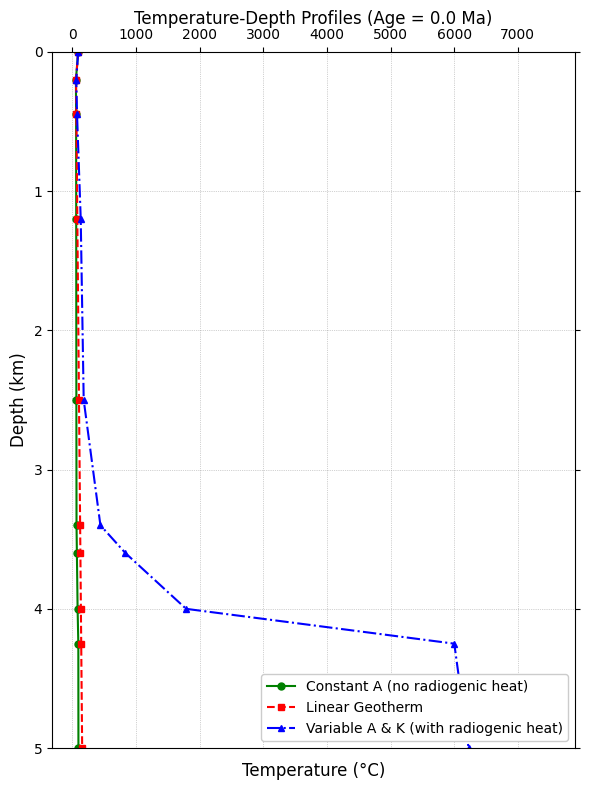

In [86]:
T_with_rad_heat, T_without_rad_heat, T_linear_geotherm = results

try:
    plot_temperature_profiles(
        t_with_rad=T_with_rad_heat,
        t_without_rad=T_without_rad_heat,
        t_linear=T_linear_geotherm[::-1],
        depths=work_layers["Depth bottom, m"],
        SWIT_=paleo_results,
        age=str(0.0)  # Can be changed to any age in your DataFrames
    )
except ValueError as e:
    print(f"Plotting error: {e}")

## Step 7. Calculation of the stretch factor

In [87]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [88]:
from scipy.stats import linregress
from scipy.optimize import fsolve

In [89]:
tectonic_subsidence_df # --> or output_df

,0.0,45.0,55.0,80.0,100.0,125.0,145.0,160.0,210.0,245.0,260.0
9,2.086768,1.949769,1.970288,1.823947,1.214375,0.814039,0.645757,0.426475,0.229946,0.115913,0.0
8,1.940328,1.810158,1.826555,1.676729,1.073813,0.680705,0.524158,0.319292,0.153964,0.000000,0.0
7,1.665753,1.625726,1.636296,1.482247,0.888125,0.504564,0.363519,0.177416,0.000000,0.000000,0.0
6,1.574228,1.463704,1.469111,1.308686,0.712423,0.326668,0.196799,0.000000,0.000000,0.000000,0.0
5,1.427788,1.258330,1.257293,1.088247,0.486786,0.092632,0.000000,0.000000,0.000000,0.000000,0.0
4,1.354568,1.312337,1.312517,1.142097,0.523405,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,1.025079,0.938696,0.925570,0.731826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.549149,0.505169,0.467891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.274575,0.193618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0,0.183050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [90]:
def calculate_stretch_factors(tectonic_subsidence, age_list, work_layers):
    """
    Calculate crustal stretch factors (β) from tectonic subsidence data.

    Parameters:
        tectonic_subsidence (DataFrame): Tectonic subsidence data
        age_list (list): List of age columns to process
        work_layers (DataFrame): Contains age information

    Returns:
        DataFrame: Stretch factors (β) for each age
    """
    # Constants with units and explanations
    TAU = 50  # Thermal time constant (Myr)
    TM = 1330  # Mantle temperature (°C)
    YL = 125  # Lithospheric thickness (km)
    ALPHA_V = 3.28e-5  # Coefficient of thermal expansion (1/°C)
    RHO_WATER = 1030  # Water density (kg/m³)
    RHO_MANTLE = 3300  # Mantle density (kg/m³)

    # Calculate constant E0 once
    E0 = (4 * YL * RHO_MANTLE * ALPHA_V * TM) / \
         (np.pi**2 * (RHO_MANTLE - RHO_WATER)) * 1000  # [m]

    # Initialize results DataFrame
    stretch_factor_df = pd.DataFrame(index=['beta'])

    def stretch_factor(beta, slope):
        """Equation to solve for beta."""
        return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope

    for age in age_list:
        # Get and clean subsidence data
        subsidence_values = tectonic_subsidence_df[age].dropna().values[::-1]
        non_zero_mask = subsidence_values != 0
        non_zero_values = subsidence_values[non_zero_mask]

        if len(non_zero_values) == 0:
            continue

        # Prepare time array
        time_window = work_layers['Age (Ma)'].iloc[:len(non_zero_values)].values
        time = np.array(time_window)

        # Calculate regression variables
        x = 1 - np.exp(-time/TAU)
        y = non_zero_values * 1000  # Convert km to m

        # Perform linear regression
        try:
            slope, _, _, _, _ = linregress(x, y)

            # Solve for beta
            beta_initial_guess = 1.0
            beta = fsolve(stretch_factor, beta_initial_guess, args=(slope))[0]

            # Store result
            stretch_factor_df[age] = [beta]

        except Exception as e:
            print(f"Error processing age {age}: {str(e)}")
            stretch_factor_df[age] = np.nan

    return stretch_factor_df

# Usage example:
stretch_factor_df = calculate_stretch_factors(tectonic_subsidence_df,
                                              tectonic_subsidence_df.columns,
                                              work_layers_with_color)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
<ipython-input-90-3051837100>:55: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  beta = fsolve(stretch_factor, beta_initial_guess, args=(slope))[0]


In [91]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

In [92]:
stretch_factor_df

,0.0,45.0,55.0,80.0,100.0,125.0,145.0,160.0,210.0,245.0
beta,1.861971,1.729746,1.550778,1.361684,1.220861,1.256636,1.163331,1.101558,1.03995,1.0


In [93]:
for age in tectonic_subsidence_df.columns:

  col_list = list(tectonic_subsidence_df[age])
  thermal_subsidence = col_list[::-1]


  if all(item == 0 for item in thermal_subsidence):
      pass
  else:

    tau = 50
    non_zero_values = [value for value in thermal_subsidence if value != 0]

    time_array = tectonic_subsidence_df.columns.astype(float).tolist()
    time = np.array(time_array[0:len(non_zero_values)+1])

In [94]:
beta = stretch_factor_df["0.0"].iloc[0] # Значение, используемое для следующих расчетов
beta

np.float64(1.8619707265608196)

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



#### Heat Flow: Subsiding (right part)

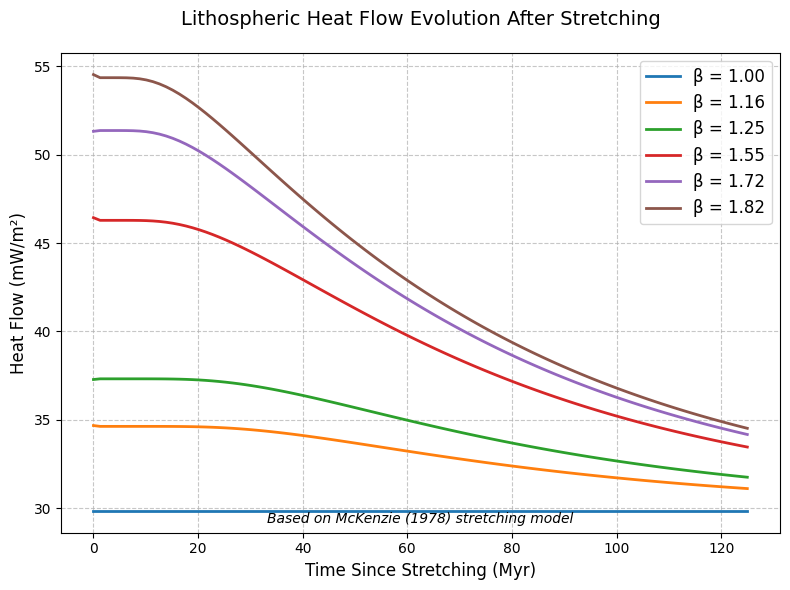

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union

def calculate_heat_flux(
    beta: Union[float, List[float]],
    time_myr: Union[float, np.ndarray],
    lithosphere_thickness_km: float = 125,
    thermal_time_constant_myr: float = 62.8,
    thermal_conductivity_wmk: float = 3.5,
    mantle_temperature_c: float = 1333,
    n_terms: int = 100
) -> np.ndarray:
    """
    Calculate heat flux for lithospheric stretching models using McKenzie's approach.

    Parameters:
        beta: Stretching factor(s) (float or list of floats)
        time_myr: Time since stretching event in million years (float or array)
        lithosphere_thickness_km: Thickness of lithosphere in km (default 125)
        thermal_time_constant_myr: Thermal time constant in Myr (default 62.8)
        thermal_conductivity_wmk: Thermal conductivity in W/m·K (default 3.5)
        mantle_temperature_c: Mantle temperature in °C (default 1333)
        n_terms: Number of terms in the series expansion (default 100)

    Returns:
        Array of heat flux values in mW/m²
    """

    beta_arr = np.atleast_1d(beta)
    time_arr = np.atleast_1d(time_myr)

    heat_flux = np.zeros((len(beta_arr), len(time_arr)))


    for i, b in enumerate(beta_arr):
        series_sum = 0.0
        for n in range(1, n_terms + 1):
            term = (b / (n * np.pi) * np.sin(n * np.pi / b) * np.exp(-n**2 * time_arr / thermal_time_constant_myr))
            series_sum += term

        # Calculate dimensionless temperature ratio
        T_over_Tm = 0.8 * (1 + 2 * series_sum)

        # Convert to heat flux (mW/m²)
        # heat_flux[i] = T_over_Tm * 60 * 697 *1e-3  # W/m² to mW/m², the factor 60*697*1e-3 from the original code
        heat_flux[i] = T_over_Tm * (thermal_conductivity_wmk * mantle_temperature_c /
                                   (lithosphere_thickness_km * 1000)) * 1e3  # W/m² to mW/m²

    return heat_flux.squeeze()  # Remove single-dimensional entries

# Parameters
beta_values = [1, 1.16, 1.25, 1.55, 1.72, 1.82]
time_values = np.linspace(0, 125, 100)

# Calculate heat flux
flux = calculate_heat_flux(beta_values, time_values)

# Plotting
plt.figure(figsize=(8, 6))
for i, b in enumerate(np.atleast_1d(beta_values)):
    plt.plot(time_values, flux[i] if len(np.atleast_1d(beta_values)) > 1 else flux,
             label=f'β = {b:.2f}',
             linewidth=2)
plt.xlabel('Time Since Stretching (Myr)', fontsize=12)
plt.ylabel('Heat Flow (mW/m²)', fontsize=12)
plt.title('Lithospheric Heat Flow Evolution After Stretching', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.annotate('Based on McKenzie (1978) stretching model',
             xy=(0.5, 0.02), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

#### Temperature = f (variable Heat Flow, Time)

In [96]:
import numpy as np
from typing import Union

def heat_flow_fundament_calculation(
    beta: float,
    t: float,
    Q_const: float = 63e-3,
    constant: bool = False,
    a: float = 125e3,
    k: float = 1e-6,
    lam: float = 3.5,
    T1: float = 1333,
    n_terms: int = 100
) -> float:
    """
    Calculate fundamental heat flow for lithospheric stretching models.

    Parameters:
    -----------
    beta : float
        Stretching factor (β > 1)
    t : float
        Time since stretching event (Myr)
    Q_const : float, optional
        Constant heat flow value (W/m²), default=63 mW/m²
    constant : bool, optional
        If True, returns Q_const, default=False
    a : float, optional
        Initial lithosphere thickness (m), default=125 km
    k : float, optional
        Thermal diffusivity (m²/s), default=1e-6
    lam : float, optional
        Thermal conductivity (W/mK), default=3.5
    T1 : float, optional
        Asthenosphere temperature (°C), default=1333
    n_terms : int, optional
        Number of terms in Fourier series, default=100

    Returns:
    --------
    float
        Heat flow in W/m²
    """

    if constant:
        return Q_const

    # Validate inputs
    if beta <= 0:
        raise ValueError("Stretching factor beta must be positive")
    if t < 0:
        raise ValueError("Time t must be non-negative")

    # Calculate lithospheric time constant (converted to Myr)
    tau = (a**2 / (k * np.pi**2)) / (60 * 60 * 24 * 365.25 * 1e6)  # Myr

    # Vectorized computation of Fourier series terms
    n = np.arange(1, n_terms + 1)
    Cn = (beta / (n * np.pi)) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
    F_sum = np.sum(Cn)

    # Calculate heat flow (convert to W/m² from W/m²)
    F = (lam * T1 / a) * (1 + 2 * F_sum)

    return F

Heat flow calcualtion for each age

Processing ages: [np.float64(0.0), np.float64(45.0), np.float64(55.0), np.float64(80.0), np.float64(100.0), np.float64(125.0), np.float64(145.0), np.float64(160.0), np.float64(210.0), np.float64(245.0), np.float64(260.0)]


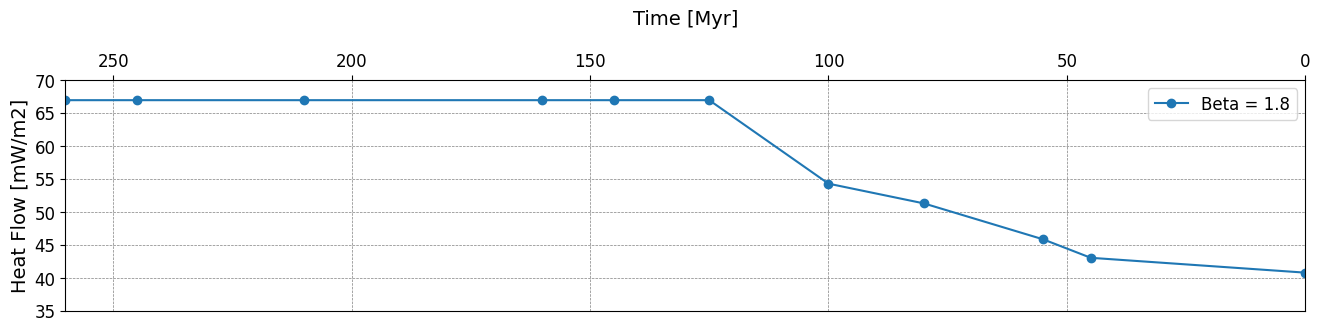

In [97]:
# Constants
T0 = 0  # Surface temperature (°C)
G = 20  # Geothermal gradient (°C/km)

# Prepare age list (sorted chronologically)
age_list = sorted(work_layers_with_color['Age (Ma)'].unique())
print("Processing ages:", age_list)

# Pre-calculate heat flow values for all ages
beta = 1.8  # Stretching factor
Qm_array = []
for t in age_list:
    if t <= 125:
        Qm = heat_flow_fundament_calculation(beta, t, Q_const=53.7e-3, constant=False)
        Qm_array.append(Qm)
    else:
        Qm = heat_flow_fundament_calculation(beta, 0, Q_const=53.7e-3, constant=False)
        Qm_array.insert(0, Qm)

plt.figure(figsize=(16, 3))
plt.plot(age_list, [x * 10**3 for x in Qm_array[::-1]], label=f'Beta = {beta}', marker='o')

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

ax = plt.gca()
ax.xaxis.set_label_position('top')  # Move x-axis label to top
ax.set_xlabel('Time [Myr]', labelpad=20, fontsize=14)
ax.set_ylabel('Heat Flow [mW/m2]', fontsize=14)

plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size

plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 260)
plt.ylim(35, 70)
plt.gca().invert_xaxis()
plt.savefig('HeatFlow.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.ylim(0, 140)

In [98]:
valid_layers = work_layers_copy[
    work_layers_copy['Lithology_type'].notna() &
    (work_layers_copy['Lithology_type'].astype(str).str.lower() != "nan")].copy() # Layers Selection with out fundament (=last layer)

# Create a dictionary for faster lithology property lookups
lithology_heat_prod = df_constast.set_index('Lithology_type')['Radiogenic Heat Production'].to_dict()

# Initialize results DataFrames with proper structure
T_with_rad_heat = pd.DataFrame(index=valid_layers.index)
T_without_rad_heat = pd.DataFrame(index=valid_layers.index)
T_linear_geotherm = pd.DataFrame(index=valid_layers.index)

# Get unique ages from the valid layers (oldest first)
age_list = sorted(valid_layers['Age (Ma)'].unique(), reverse=True)

for age_idx, age in enumerate(age_list):
    print(f"\nProcessing age {age_idx}: {age} Ma")

    # Get current heat flow value (using proper indexing)
    Qm = Qm_array[age_idx]

    # Initialize temperature and depth trackers
    cumulative_depth = 0
    cumulative_depth = T0
    T_cumulative_rad = T0  # Surface temperature
    T_cumulative_no_rad = T0

    T_rad_values = []
    T_no_rad_values = []
    T_linear_values = []

    for layer_idx, layer in valid_layers.iterrows():
        lithology = layer['Lithology_type']
        layer_name = layer['Event_name']

        # Get layer properties
        try:
            A = lithology_heat_prod[lithology]
            K = thermal_conductivity_bulk_df.at[layer_idx, str(age)]
            thickness = decompaction_df.at[layer_idx, str(age)] * 1000  # Convert km to m
            depth = decompaction_corrected_df.at[layer_idx, str(age)] * 1000  # Convert km to m
        except (IndexError, KeyError) as e:
            print(f"Warning: Missing data for {lithology} in {layer_name} at {age} Ma")
            continue

        # 1. Calculate temperature with radiogenic heat
        if K <= 0:
            # Handle zero/negative conductivity (use previous temperature)
            T_rad = T_cumulative_rad
        else:
            term1 = ((Qm + A * cumulative_depth) / K) * thickness
            term2 = (A / (2 * K)) * thickness**2
            T_rad = T_cumulative_rad + term1 - term2

        T_rad_values.append(T_rad)
        T_cumulative_rad = T_rad  # Update cumulative temperature

        # 2. Calculate temperature without radiogenic heat
        if K <= 0:
            T_no_rad = T_cumulative_no_rad
        else:
            term1 = (Qm / K) * thickness
            T_no_rad = T_cumulative_no_rad + term1

        T_no_rad_values.append(T_no_rad)
        T_cumulative_no_rad = T_no_rad  # Update cumulative temperature

        # 3. Calculate linear geotherm (in °C)
        T_linear = linear_geotherm(G, depth/1000)  # Assuming depth is converted back to km
        T_linear_values.append(T_linear)

        # Update cumulative depth for next layer
        cumulative_depth += thickness

    # Store results for this age
    T_with_rad_heat[str(age)] = T_rad_values
    T_without_rad_heat[str(age)] = T_no_rad_values
    T_linear_geotherm[str(age)] = T_linear_values


Processing age 0: 245.0 Ma

Processing age 1: 210.0 Ma

Processing age 2: 160.0 Ma

Processing age 3: 145.0 Ma

Processing age 4: 125.0 Ma

Processing age 5: 100.0 Ma

Processing age 6: 80.0 Ma

Processing age 7: 55.0 Ma

Processing age 8: 45.0 Ma

Processing age 9: 0.0 Ma


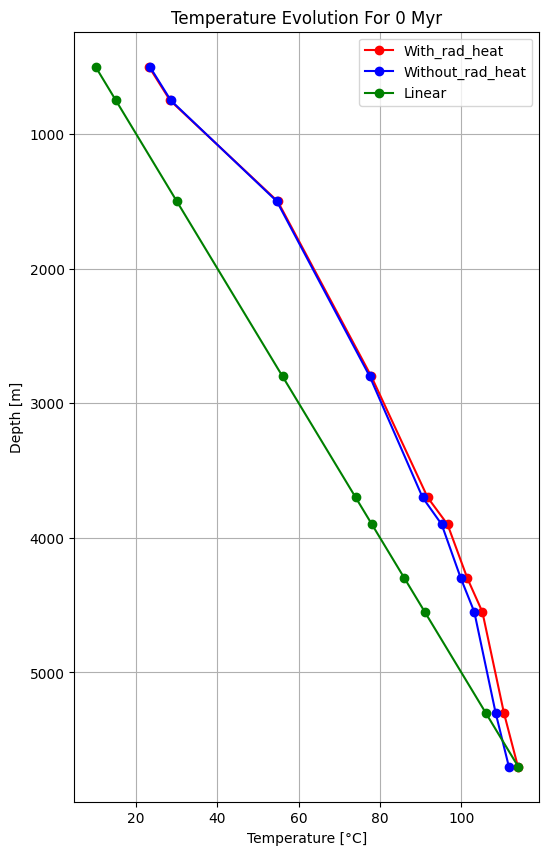

In [99]:
# Plot heat flow curve
plt.figure(figsize=(6, 10))

x_values = decompaction_corrected_df[str(0.0)] * 1000  # Convert km to m

plt.plot(T_with_rad_heat[str(0.0)], x_values, 'r-o', label=f'With_rad_heat')
plt.plot(T_without_rad_heat[str(0.0)], x_values, 'b-o', label=f'Without_rad_heat')
plt.plot(T_linear_geotherm[str(0.0)], x_values, 'g-o', label=f'Linear')
# plt.ylim(0, 5500)
plt.gca().invert_yaxis()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [m]')
plt.title('Temperature Evolution For 0 Myr')
plt.grid(True)
plt.legend()
plt.show()

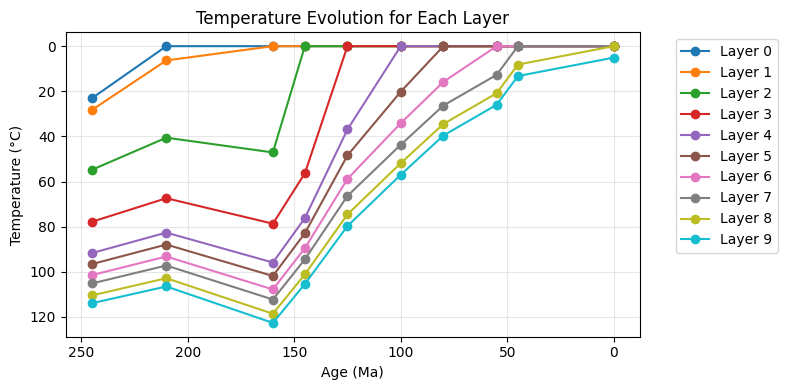

In [100]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))

ages = np.sort(pd.to_numeric(T_with_rad_heat.columns, errors='coerce'))

for layer_idx, layer_row in T_with_rad_heat.iterrows():
    layer_name = f"Layer {layer_idx}" if not isinstance(layer_idx, str) else layer_idx
    plt.plot(ages, layer_row.values, 'o-', label=layer_name)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Evolution for Each Layer')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [101]:
# work_layers = work_layers_with_color
# save_to_csv(T_with_rad_heat, work_layers, "Geotherm_with_A.csv")
# save_to_csv(T_without_rad_heat, work_layers, "Geotherm_without_A.csv")
# save_to_csv(T_linear_geotherm, work_layers, "Linear_Geotherm.csv")

In [102]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_with_rad_heat['Event_name'] = work_layers['Event_name']
# T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

# T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

In [103]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_without_rad_heat['Event_name'] = work_layers['Event_name']
# T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

# T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

###Sekiguchi–Waples Model = f(T, TCm)

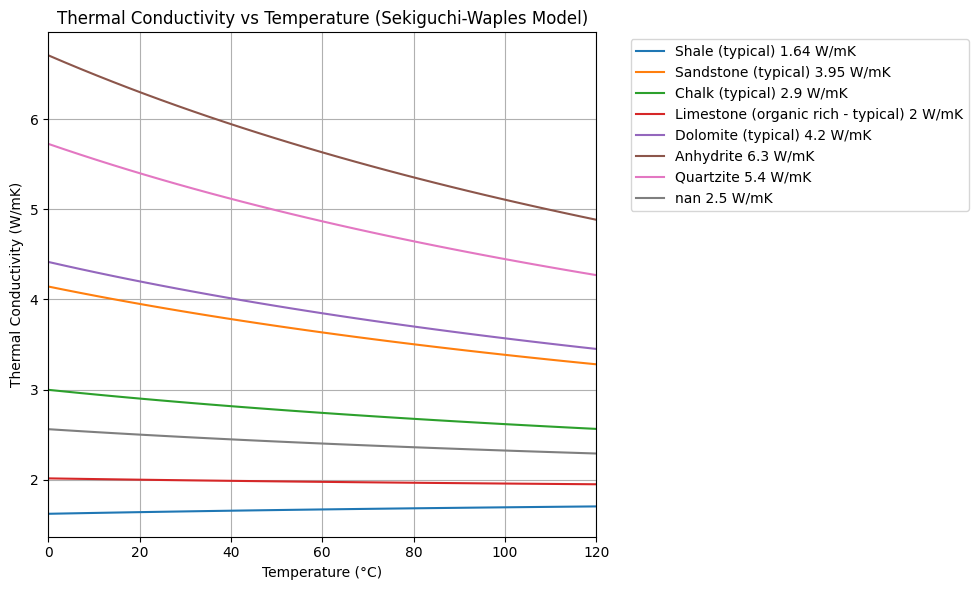

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Dict

def sekiguchi_waples(
    temperature_k: Union[float, np.ndarray],
    lambda_m: float,
    correction: bool = True
) -> Union[float, np.ndarray]:
    """Calculate thermal conductivity using Sekiguchi-Waples model.

    Args:
        temperature_k: Temperature in Kelvin
        lambda_m: Matrix thermal conductivity at 20°C (W/mK)
        correction: Whether to apply correction factor

    Returns:
        Thermal conductivity (W/mK)
    """
    if correction:
        return 358 * (1.0227 * lambda_m - 1.882) * (temperature_k**(-1) - 0.00068) + 1.84
    return 358 * lambda_m * temperature_k**(-1)

def plot_thermal_conductivity(
    df: pd.DataFrame,
    lithology_tc_map: Dict[str, float],
    default_tc: float = 2.5,
    max_temperature: float = 120
) -> None:
    """Plot thermal conductivity vs temperature for different lithologies.

    Args:
        df: DataFrame containing lithology data
        lithology_tc_map: Dictionary mapping lithology types to thermal conductivity values
        default_tc: Default thermal conductivity value for missing lithologies
        max_temperature: Maximum temperature to display (°C)
    """
    # Get unique lithologies and their TC values
    lithologies = df['Lithology_type'].unique()

    fig, ax = plt.subplots(figsize=(10, 6))

    for lithology in lithologies:
        # Get thermal conductivity value from the mapping, use default if not found
        tc_matrix = lithology_tc_map.get(lithology, default_tc)

        temperature_range = np.linspace(0, 350, 100)
        lambda_i_values = [
            sekiguchi_waples(T+273.15, tc_matrix, correction=True)
            for T in temperature_range
        ]

        ax.plot(
            temperature_range,
            lambda_i_values,
            label=f'{lithology} {tc_matrix} W/mK'
        )

    ax.set(
        xlabel='Temperature (°C)',
        ylabel='Thermal Conductivity (W/mK)',
        title='Thermal Conductivity vs Temperature (Sekiguchi-Waples Model)',
        xlim=(0, max_temperature)
    )
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


LITHOLOGY_TC_MAP = Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()

plot_thermal_conductivity(
    df=work_layers,
    lithology_tc_map=LITHOLOGY_TC_MAP,
    default_tc=2.5,
    max_temperature=120
)

In [105]:
def calculate_thermal_models(work_layers_copy, df_constast, Database_Lithotypes, porosity_df,
                           decompaction_df, decompaction_corrected_df, SWIT_, beta=1.8, Q_const=30e-3):
    """
    Calculate thermal models (with/without radiogenic heat) and linear geotherms for geological layers.
    Now includes dynamic surface temperature (T0) and radiogenic heat production calculations.
    """
    # Constants
    G = 5  # Geothermal gradient (°C/km)
    TC_WATER = 0.60  # Thermal conductivity of water (W/m/K)

    # Filter valid layers with lithology information
    valid_layers = work_layers_copy[
        (work_layers_copy['Lithology_type'].notna()) &
        (work_layers_copy['Lithology_type'].astype(str).str.lower() != "nan")].copy()

    # Create thermal conductivity dictionary
    try:
        lithology_tc_map = Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()
    except KeyError as e:
        raise ValueError(f"Missing required column in input data: {str(e)}")

    # Get unique ages (sorted oldest first)
    age_list = sorted(valid_layers['Age (Ma)'].unique())

    # Initialize results DataFrames
    results = {
        'with_rad': pd.DataFrame(index=valid_layers.index),
        'without_rad': pd.DataFrame(index=valid_layers.index),
        'linear': pd.DataFrame(index=valid_layers.index)  # Changed from 'linear'
    }

    # Calculate heat flow array
    # Qm = heat_flow_fundament_calculation(beta, age_list, Q_const, constant=False)

    Qm = calculate_heat_flux(beta, age_list)
    # Qm_array = calculate_heat_flow_array(age_list, beta, Q_const)

    # Process each time period
    for age_idx, age in enumerate(age_list):
        # Get dynamic surface temperature for this age
        T0 = get_surface_temperature(age, SWIT_)
        print(f"\nProcessing age {age} Ma (index {age_idx}) with surface temp {T0:.1f}°C")

        # Initialize temperature calculations
        temp_data = {
            'with_rad': {'sum1': [], 'sum2': [], 'values': [], 'cumulative': T0},
            'without_rad': {'sum1': [], 'values': [], 'cumulative': T0},
            'linear': {'values': []}
        }

        cumulative_depth = 0
        K_list = []

        # Process each layer
        for layer_idx, layer in valid_layers.iterrows():
            lithology = layer['Lithology_type']
            layer_name = layer['Event_name']

            try:
                # Get dynamic radiogenic heat production for this layer
                A = radiogenic_heat_production(
                    Database_Lithotypes,
                    lithology,
                    porosity_df,
                    layer_name,
                    age
                )

                tc_matrix = lithology_tc_map.get(lithology, 0)  # Default to 0 if not found

                try:
                    phi0 = porosity_df.loc[
                        (porosity_df['Lithology_type'] == lithology) &
                        (porosity_df['Event_name'] == layer_name),
                        str(age)
                    ].iloc[0]
                    thickness = decompaction_df.at[layer_idx, str(age)] * 1000
                    depth = decompaction_corrected_df.at[layer_idx, str(age)] * 1000
                except (KeyError, IndexError) as e:
                    print(f"Warning: Missing property data for {lithology} in {layer_name} at {age} Ma")
                    continue

                # Calculate temperature-corrected thermal conductivity
                current_temp = temp_data['with_rad']['cumulative']
                T_sg = current_temp if layer_idx > 0 else T0
                T_sg = max(T_sg, 1e-3)  # Avoid division by zero

                try:
                    K_mtrx_corrected = sekiguchi_waples(T_sg + 273.15, tc_matrix, correction=True)
                    K = bulk_thermal_conductivity_geomean(K_mtrx_corrected, TC_WATER, phi0)
                    K_list.append(K)
                except Exception as e:
                    print(f"Warning: Thermal conductivity calculation failed for {lithology}: {str(e)}")
                    K = 0

                # Update cumulative depth
                cumulative_depth += thickness
                Qm = Qm_array[age_idx]

                # print(lithology, layer_name, T0, A, T_sg, K)

                # Calculate temperatures
                # With radiogenic heat
                if K > 0:
                    term1 = ((Qm + A * cumulative_depth) / K) * thickness
                    term2 = (A / (2 * K)) * thickness**2
                    temp_data['with_rad']['sum1'].append(term1)
                    temp_data['with_rad']['sum2'].append(term2)
                    T_rad = sum(temp_data['with_rad']['sum1']) - sum(temp_data['with_rad']['sum2'])
                else:
                    T_rad = temp_data['with_rad']['cumulative']

                temp_data['with_rad']['values'].append(T_rad)
                temp_data['with_rad']['cumulative'] = T_rad

                # Without radiogenic heat
                if K > 0:
                    term = (Qm / K) * thickness
                    temp_data['without_rad']['sum1'].append(term)
                    T_no_rad = sum(temp_data['without_rad']['sum1'])
                else:
                    T_no_rad = temp_data['without_rad']['cumulative']

                temp_data['without_rad']['values'].append(T_no_rad)
                temp_data['without_rad']['cumulative'] = T_no_rad

                # Linear geotherm
                temp_data['linear']['values'].append(linear_geotherm(G, depth/1000))

            except Exception as e:
                print(f"Error processing {lithology} in {layer_name}: {str(e)}")
                continue

        # Store results for this age
        store_results(results, temp_data, valid_layers.shape[0], str(age))

    return results['with_rad'], results['without_rad'], results['linear']

def radiogenic_heat_production(database, lithology, porosity_df, layer_name, age):
    """
    Calculate radiogenic heat production for a specific lithology.

    Args:
        database: Database_Lithotypes DataFrame
        lithology: Lithology type name
        porosity_df: DataFrame with porosity data
        layer_name: Name of the layer
        age: Age in Ma

    Returns:
        Radiogenic heat production (QrBulk) in µW/m³
    """
    try:
        # Find lithology match
        lithology_match = database[database['Lithology type'] == str(lithology)]
        if lithology_match.empty:
            print(f"Warning: No lithology match found for {lithology}")
            return 0  # Return 0 instead of DEFAULT_A to match original behavior

        # Get density and radioactive elements
        RoGrain = lithology_match['Density'].iloc[0]
        U, Th, K = lithology_match[["Uranium", "Thorium", "Potassium"]].iloc[0]

        # Get porosity for this layer and age
        porosity = porosity_df.loc[
            (porosity_df['Lithology_type'] == lithology) &
            (porosity_df['Event_name'] == layer_name),
            str(age)
        ].iloc[0]

        # Calculate radiogenic heat production (µW/m³)
        QrBulk = 0.01 * RoGrain * (9.25 * U + 2.56 * Th + 3.49 * K) * (1 - porosity) * 1e-8

        return QrBulk

    except Exception as e:
        print(f"Error calculating radiogenic heat for {lithology}: {str(e)}")
        return 0  # Return 0 instead of DEFAULT_A to match original behavior

In [106]:
T_with_rad, T_without_rad, T_linear = calculate_thermal_models(
    work_layers_copy,
    df_constast,
    Database_Lithotypes,
    porosity_df,
    decompaction_df,
    decompaction_corrected_df,
    SWIT_=paleo_results,
    beta=1.8
)


Processing age 0.0 Ma (index 0) with surface temp 90.0°C

Processing age 45.0 Ma (index 1) with surface temp 82.0°C

Processing age 55.0 Ma (index 2) with surface temp 80.6°C

Processing age 80.0 Ma (index 3) with surface temp 79.0°C

Processing age 100.0 Ma (index 4) with surface temp 78.6°C

Processing age 125.0 Ma (index 5) with surface temp 76.6°C

Processing age 145.0 Ma (index 6) with surface temp 76.0°C

Processing age 160.0 Ma (index 7) with surface temp 76.0°C

Processing age 210.0 Ma (index 8) with surface temp 72.2°C

Processing age 245.0 Ma (index 9) with surface temp 52.6°C


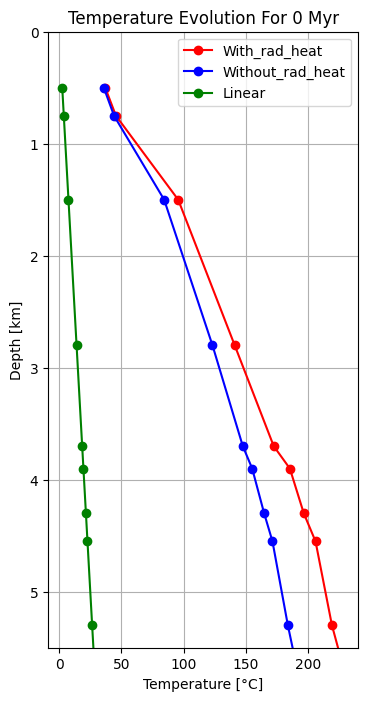

In [113]:
# Plot heat flow curve
plt.figure(figsize=(4, 8))

x_values = decompaction_corrected_df[str(0.0)]

plt.plot(T_with_rad[str(0.0)], x_values, 'r-o', label=f'With_rad_heat')
plt.plot(T_without_rad[str(0.0)], x_values, 'b-o', label=f'Without_rad_heat')
plt.plot(T_linear[str(0.0)], x_values, 'g-o', label=f'Linear')
plt.ylim(0, 5.5)
plt.gca().invert_yaxis()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [km]')
plt.title('Temperature Evolution For 0 Myr')
plt.grid(True)
plt.legend()
plt.show()

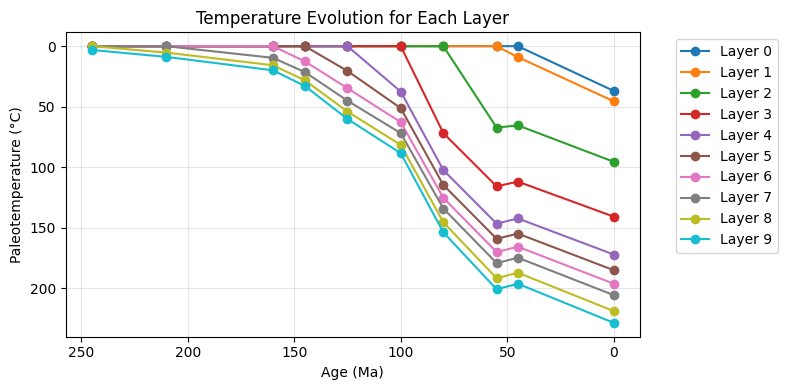

In [114]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))

ages = np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce'))

for layer_idx, layer_row in T_with_rad.iterrows():
    layer_name = f"Layer {layer_idx}" if not isinstance(layer_idx, str) else layer_idx
    plt.plot(ages, layer_row.values, 'o-', label=layer_name)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Paleotemperature (°C)')
plt.title('Temperature Evolution for Each Layer')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

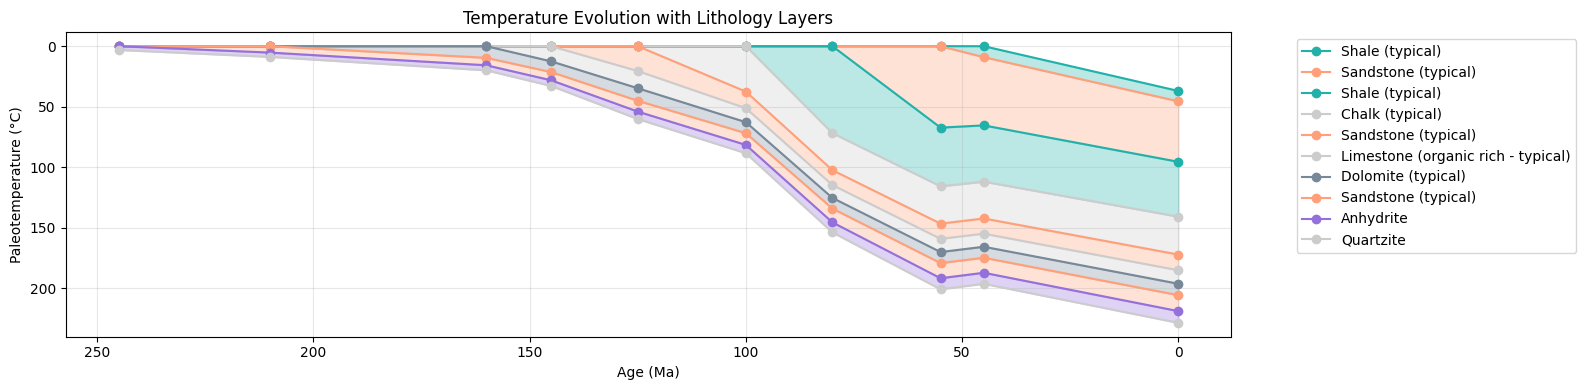

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(16, 4))

ages = np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce'))

# Define a color for each lithology type
lithology_colors = {
    "Sandstone (typical)": "#FFA07A",  # Light Salmon
    "Dolomite (typical)": "#778899",     # Light Slate Gray
    "Shale (typical)": "#20B2AA", # Light Sea Green
    "Anhydrite": "#9370DB",    # Medium Purple
    # Add more lithologies and colors as needed
}

for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    layer_info = valid_layers.loc[layer_idx]
    lithology = layer_info['Lithology_type']

    # Get the color for this lithology (default to gray if not found)
    color = lithology_colors.get(lithology, "#CCCCCC")

    plt.plot(ages, layer_row.values, 'o-', color=color, label=lithology)

    # Fill between this layer and the next one
    if i < len(T_with_rad) - 1:
        next_layer = T_with_rad.iloc[i+1].values
        plt.fill_between(ages, layer_row.values, next_layer, color=color, alpha=0.3)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Paleotemperature (°C)')
plt.title('Temperature Evolution with Lithology Layers')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

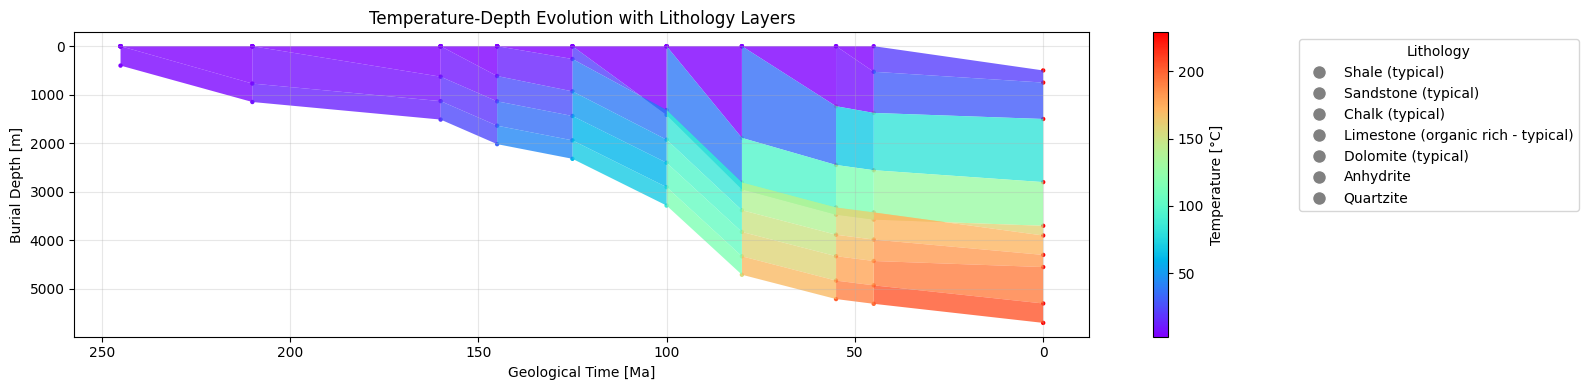

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection

plt.figure(figsize=(16, 4))  # Increased height for better depth representation

ages = np.array(np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce')))  # Ensure numpy array

# Create a colormap for temperature values
temp_cmap = plt.cm.rainbow
norm = plt.Normalize(vmin=T_with_rad.values.min(), vmax=T_with_rad.values.max())

# First plot the scatter points with temperature coloring
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])

    # Plot line with temperature-based coloring
    sc = plt.scatter(ages, depth_values * 1000, c=layer_row.values, cmap=temp_cmap,
                    s=10, edgecolor='none')

# Create filled polygons with temperature-based coloring
for i in range(len(T_with_rad) - 1):
    # Get depth values for current and next layer
    depth_values = np.array([decompaction_corrected_df.loc[T_with_rad.index[i], str(age)]
                          if str(age) in decompaction_corrected_df.columns
                          else np.nan for age in ages])

    depth_values*= 1000
    next_depth_values = np.array([decompaction_corrected_df.loc[T_with_rad.index[i+1], str(age)]
                                if str(age) in decompaction_corrected_df.columns
                                else np.nan for age in ages])
    next_depth_values*=1000


    # Filter out NaN values
    valid_idx = ~np.isnan(depth_values) & ~np.isnan(next_depth_values)
    valid_ages = ages[valid_idx]
    valid_depths = depth_values[valid_idx]
    valid_next_depths = next_depth_values[valid_idx]

    if len(valid_ages) > 1:
        # Create vertices for the polygon
        verts = []
        colors = []
        # Bottom of the layer (next layer's depths)
        for age, depth in zip(valid_ages[::-1], valid_next_depths[::-1]):
            verts.append((age, depth))
        # Top of the layer (current layer's depths)
        for age, depth in zip(valid_ages, valid_depths):
            verts.append((age, depth))

        # Get corresponding temperatures for coloring
        layer_temps = T_with_rad.iloc[i][valid_idx].values
        avg_temps = (layer_temps[:-1] + layer_temps[1:]) / 2  # Average between points

        # Create a PolyCollection with color variation
        polygons = []
        color_values = []
        for j in range(len(valid_ages)-1):
            # Create quadrilateral for each segment
            poly_verts = [
                (valid_ages[j], valid_depths[j]),
                (valid_ages[j+1], valid_depths[j+1]),
                (valid_ages[j+1], valid_next_depths[j+1]),
                (valid_ages[j], valid_next_depths[j])
            ]
            polygons.append(poly_verts)
            color_values.append(avg_temps[j])

        poly_collection = PolyCollection(polygons, array=np.array(color_values),
                                        cmap=temp_cmap, norm=norm, alpha=0.8)
        plt.gca().add_collection(poly_collection)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('Geological Time [Ma]')
plt.ylabel('Burial Depth [m]')
plt.title('Temperature-Depth Evolution with Lithology Layers')

# Add colorbar for temperature
cbar = plt.colorbar(sc)
cbar.set_label('Temperature [°C]')

plt.grid(True, alpha=0.3)

# Create legend for lithology types
handles = []
for lithology in valid_layers['Lithology_type'].unique():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markersize=10, label=lithology))
plt.legend(handles=handles, bbox_to_anchor=(1.2, 1), loc='upper left', title='Lithology')

plt.tight_layout()
plt.show()

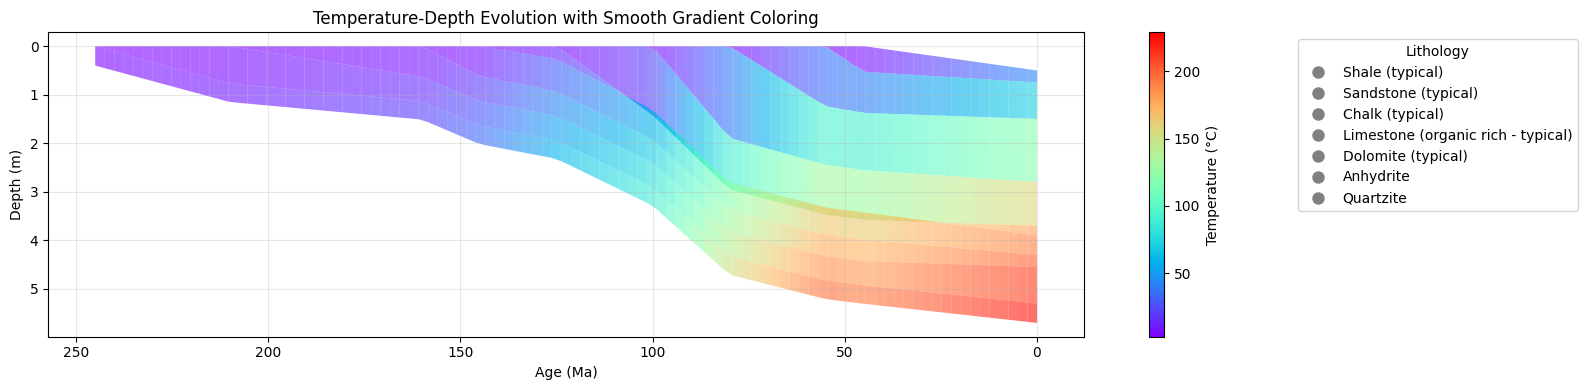

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from scipy.interpolate import interp1d

plt.figure(figsize=(16, 4))

# Data preparation
ages = np.array(np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce')))
temp_cmap = plt.cm.rainbow  # Better for temperature than gist_rainbow
norm = plt.Normalize(vmin=T_with_rad.values.min(), vmax=T_with_rad.values.max())

# --- 1. Create interpolated temperature fields ---
def create_interpolated_grid(layer_idx, n_interp=100):
    """Returns interpolated ages, depths and temps for smoother plotting"""
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])
    temp_values = T_with_rad.loc[layer_idx].values

    # Filter valid points
    valid_mask = ~np.isnan(depth_values)
    valid_ages = ages[valid_mask]
    valid_depths = depth_values[valid_mask]
    valid_temps = temp_values[valid_mask]

    if len(valid_ages) < 2:
        return None, None, None

    # Create interpolation functions
    depth_interp = interp1d(valid_ages, valid_depths, kind='linear', fill_value="interpolate")
    temp_interp = interp1d(valid_ages, valid_temps, kind='linear', fill_value="interpolate")

    # New finer grid
    interp_ages = np.linspace(ages.min(), ages.max(), n_interp)
    interp_depths = depth_interp(interp_ages)
    interp_temps = temp_interp(interp_ages)

    return interp_ages, interp_depths, interp_temps

# --- 2. Plot with smooth temperature coloring ---
for i in range(len(T_with_rad) - 1):
    # Get interpolated data for both layers
    ages1, depths1, temps1 = create_interpolated_grid(T_with_rad.index[i])
    ages2, depths2, temps2 = create_interpolated_grid(T_with_rad.index[i+1])

    if ages1 is None or ages2 is None:
        continue

    # Create vertices for each segment with interpolated temps
    polygons = []
    color_values = []

    for j in range(len(ages1)-1):
        # Calculate average temperature between points
        avg_temp = (temps1[j] + temps1[j+1] + temps2[j] + temps2[j+1]) / 4

        # Define quadrilateral vertices
        poly_verts = [
            (ages1[j], depths1[j]),
            (ages1[j+1], depths1[j+1]),
            (ages2[j+1], depths2[j+1]),
            (ages2[j], depths2[j])
        ]

        polygons.append(poly_verts)
        color_values.append(avg_temp)

    # Create the collection with smooth colors
    poly_collection = PolyCollection(
        polygons,
        array=np.array(color_values),
        cmap=temp_cmap,
        norm=norm,
        alpha=0.6,  # Slightly more opaque for better visibility
        # edgecolor='none'  # Remove edge lines for smoother appearance
    )
    plt.gca().add_collection(poly_collection)

# --- 3. Plot original scatter points (optional) ---
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])
    sc = plt.scatter(ages, depth_values, c=layer_row.values, cmap=temp_cmap,
                     s=0,
                     edgecolor='k', linewidth=0.5, zorder=3
                     )

# --- 4. Final plot adjustments ---
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Depth (m)')
plt.title('Temperature-Depth Evolution with Smooth Gradient Coloring')

cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)')

# Lithology legend
handles = []
for lithology in valid_layers['Lithology_type'].unique():
    handles.append(plt.Line2D([0], [0],
                              marker='o', color='w',
                            markerfacecolor='gray', markersize=10, label=lithology))
plt.legend(handles=handles, bbox_to_anchor=(1.2, 1), loc='upper left', title='Lithology')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Using column '0.0' for present-day depths


<ipython-input-150-3373052647>:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


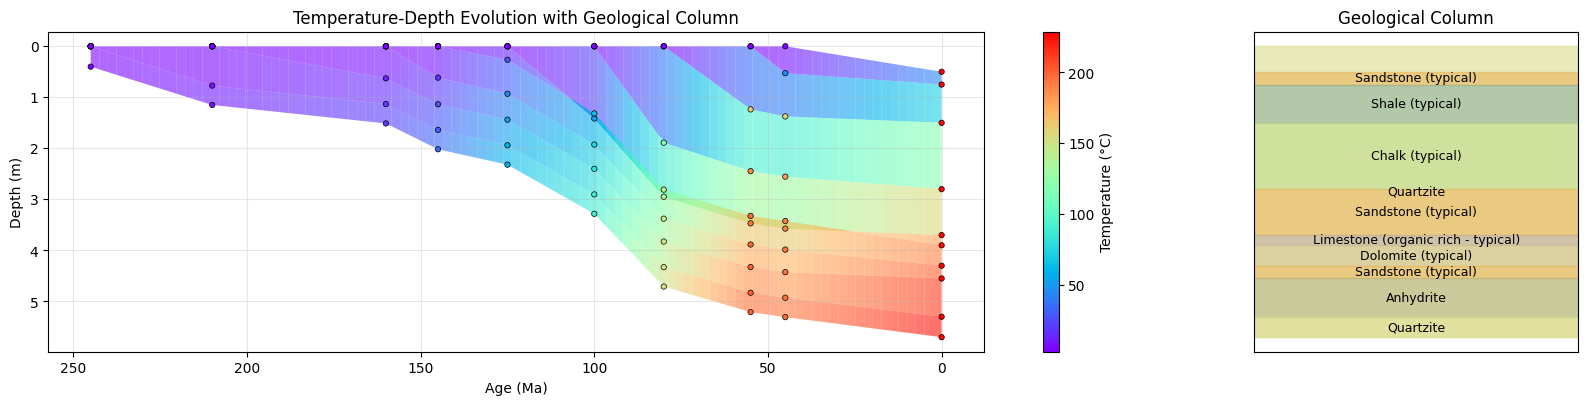

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from scipy.interpolate import interp1d

plt.figure(figsize=(18, 4))  # Increased width to accommodate geological column

# Data preparation
ages = np.array(np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce')))
temp_cmap = plt.cm.rainbow
norm = plt.Normalize(vmin=T_with_rad.values.min(), vmax=T_with_rad.values.max())

# Create main plot area (leave space on right for geological column)
ax_main = plt.axes([0.1, 0.1, 0.65, 0.8])  # [left, bottom, width, height]

# --- 1. Create interpolated temperature fields ---
def create_interpolated_grid(layer_idx, n_interp=100):
    """Returns interpolated ages, depths and temps for smoother plotting"""
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])
    temp_values = T_with_rad.loc[layer_idx].values

    # Filter valid points
    valid_mask = ~np.isnan(depth_values)
    valid_ages = ages[valid_mask]
    valid_depths = depth_values[valid_mask]
    valid_temps = temp_values[valid_mask]

    if len(valid_ages) < 2:
        return None, None, None

    # Create interpolation functions
    depth_interp = interp1d(valid_ages, valid_depths, kind='linear', fill_value="interpolate")
    temp_interp = interp1d(valid_ages, valid_temps, kind='linear', fill_value="interpolate")

    # New finer grid
    interp_ages = np.linspace(ages.min(), ages.max(), n_interp)
    interp_depths = depth_interp(interp_ages)
    interp_temps = temp_interp(interp_ages)

    return interp_ages, interp_depths, interp_temps

# --- 2. Plot with smooth temperature coloring ---
for i in range(len(T_with_rad) - 1):
    # Get interpolated data for both layers
    ages1, depths1, temps1 = create_interpolated_grid(T_with_rad.index[i])
    ages2, depths2, temps2 = create_interpolated_grid(T_with_rad.index[i+1])

    if ages1 is None or ages2 is None:
        continue

    # Create vertices for each segment with interpolated temps
    polygons = []
    color_values = []

    for j in range(len(ages1)-1):
        avg_temp = (temps1[j] + temps1[j+1] + temps2[j] + temps2[j+1]) / 4
        poly_verts = [
            (ages1[j], depths1[j]),
            (ages1[j+1], depths1[j+1]),
            (ages2[j+1], depths2[j+1]),
            (ages2[j], depths2[j])
        ]
        polygons.append(poly_verts)
        color_values.append(avg_temp)

    poly_collection = PolyCollection(
        polygons,
        array=np.array(color_values),
        cmap=temp_cmap,
        norm=norm,
        alpha=0.6,
        edgecolor='none'
    )
    ax_main.add_collection(poly_collection)

# --- 3. Plot original scatter points ---
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])
    sc = ax_main.scatter(ages, depth_values, c=layer_row.values, cmap=temp_cmap,
                       s=15, edgecolor='k', linewidth=0.5, zorder=3)

# --- 4. Create geological column ---
ax_geo = plt.axes([0.77, 0.1, 0.18, 0.8], sharey=ax_main)  # Right side column
ax_geo.set_xlim(0, 1)
ax_geo.set_xticks([])  # Remove x-axis ticks
ax_geo.set_xticklabels([])
ax_geo.set_title('Geological Column')
ax_geo.grid(False)

# Get unique lithologies and their colors
lithologies = valid_layers['Lithology_type'].unique()
litho_colors = {lith: plt.cm.tab20(i/len(lithologies)) for i, lith in enumerate(lithologies)}

# Find the column name closest to present day (age=0)
present_col = None
min_diff = float('inf')
for col in decompaction_corrected_df.columns:
    try:
        age = float(col)
        if abs(age) < min_diff:
            min_diff = abs(age)
            present_col = col
    except ValueError:
        continue

if present_col is None:
    present_col = decompaction_corrected_df.columns[-1]  # Fallback to youngest age

print(f"Using column '{present_col}' for present-day depths")  # Debug output

# Plot geological column with connecting lines
prev_depth = None
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    try:
        current_depth = decompaction_corrected_df.loc[layer_idx, present_col]
        if np.isnan(current_depth):
            continue

        lithology = valid_layers.loc[layer_idx, 'Lithology_type']
        color = litho_colors[lithology]

        # Draw connecting line from main plot to geological column
        ax_main.plot([float(present_col), float(present_col)],
                    [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)
        ax_main.plot([float(present_col), 0.77], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)

        # Draw layer in geological column
        if prev_depth is not None:
            ax_geo.fill_betweenx([prev_depth, current_depth], 0, 1,
                                color=color, alpha=0.6)
            ax_geo.text(0.5, (prev_depth + current_depth)/2,
                       lithology, ha='center', va='center', fontsize=9)

        prev_depth = current_depth

    except KeyError:
        continue

# Draw the topmost layer if needed
if prev_depth is not None:
    ax_geo.fill_betweenx([0, prev_depth], 0, 1,
                        color=litho_colors[valid_layers.iloc[-1]['Lithology_type']],
                        alpha=0.6)
    ax_geo.text(0.5, prev_depth/2,
               valid_layers.iloc[-1]['Lithology_type'],
               ha='center', va='center', fontsize=9)

# --- 5. Final adjustments ---

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax_main.invert_xaxis()
ax_main.invert_yaxis()
ax.xaxis.set_label_position('top')
ax_main.set_xlabel('Age (Ma)')
ax_main.set_ylabel('Depth (m)')
ax_main.set_title('Temperature-Depth Evolution with Geological Column')
ax_main.grid(True, alpha=0.3)
plt.xticks(fontsize=14)  # Increase x-axis tick label size
plt.yticks(fontsize=14)  # Increase y-axis tick label size

# Add colorbar to main plot
cbar = plt.colorbar(sc, ax=ax_main)
cbar.set_label('Temperature (°C)')

# Remove y-axis from geological column
ax_geo.yaxis.set_visible(False)

# # Lithology legend
# handles = []
# for lithology in valid_layers['Lithology_type'].unique():
#     handles.append(plt.Line2D([0], [0], marker='o', color='w',
#                             markerfacecolor=litho_colors[lithology], markersize=10, label=lithology))
# plt.legend(handles=handles, bbox_to_anchor=(1.35, 1), loc='upper left', title='Lithology')

plt.tight_layout()
plt.show()

#### Present day heat flow (a) and temperature (b)

In [181]:
decompaction_corrected_df[str(0.0)] * 1000

,0.0
0,500.0
1,750.0
2,1500.0
3,2800.0
4,3700.0
5,3900.0
6,4300.0
7,4550.0
8,5300.0
9,5700.0


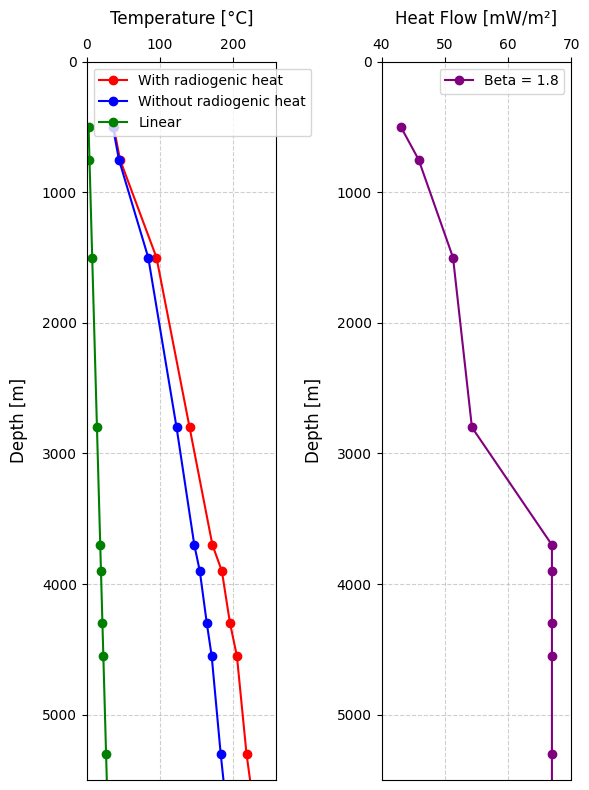

In [162]:
# Create figure with two vertical subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 8), gridspec_kw={'width_ratios': [1, 1]})

# --- Plot 1: Temperature vs Depth ---
x_values = decompaction_corrected_df[str(0.0)] * 1000  # Depth values

ax1.plot(T_with_rad[str(0.0)], x_values, 'r-o', label='With radiogenic heat')
ax1.plot(T_without_rad[str(0.0)], x_values, 'b-o', label='Without radiogenic heat')
ax1.plot(T_linear[str(0.0)], x_values, 'g-o', label='Linear')

ax1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Temperature [°C]', fontsize=12, labelpad=10)
ax1.set_ylabel('Depth [m]', fontsize=12, labelpad=10)

ax1.set_ylim(0, 5500)
ax1.set_xlim(0, 260)
ax1.invert_yaxis()  # Surface at top
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=10)


# --- Plot 2: Heat Flow vs Time ---
ax2.plot([x * 10**3 for x in Qm_array[::-1][1::]], x_values, label=f'Beta = {beta}', marker='o', color='purple')

ax2.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Heat Flow [mW/m²]', fontsize=12, labelpad=10)
ax2.set_ylabel('Depth [m]', labelpad=10, fontsize=12)

ax2.set_xlim(40, 70)
ax2.set_ylim(0, 5500)
ax2.invert_yaxis()  # Surface at top
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=10)

# Adjust layout and save
plt.tight_layout()
# plt.savefig('Combined_Plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [201]:
decompaction_corrected_df.columns

Index(['0.0', '45.0', '55.0', '80.0', '100.0', '125.0', '145.0', '160.0',
       '210.0', '245.0', '260.0', 'Event_name', 'Lithology_type'],
      dtype='object')

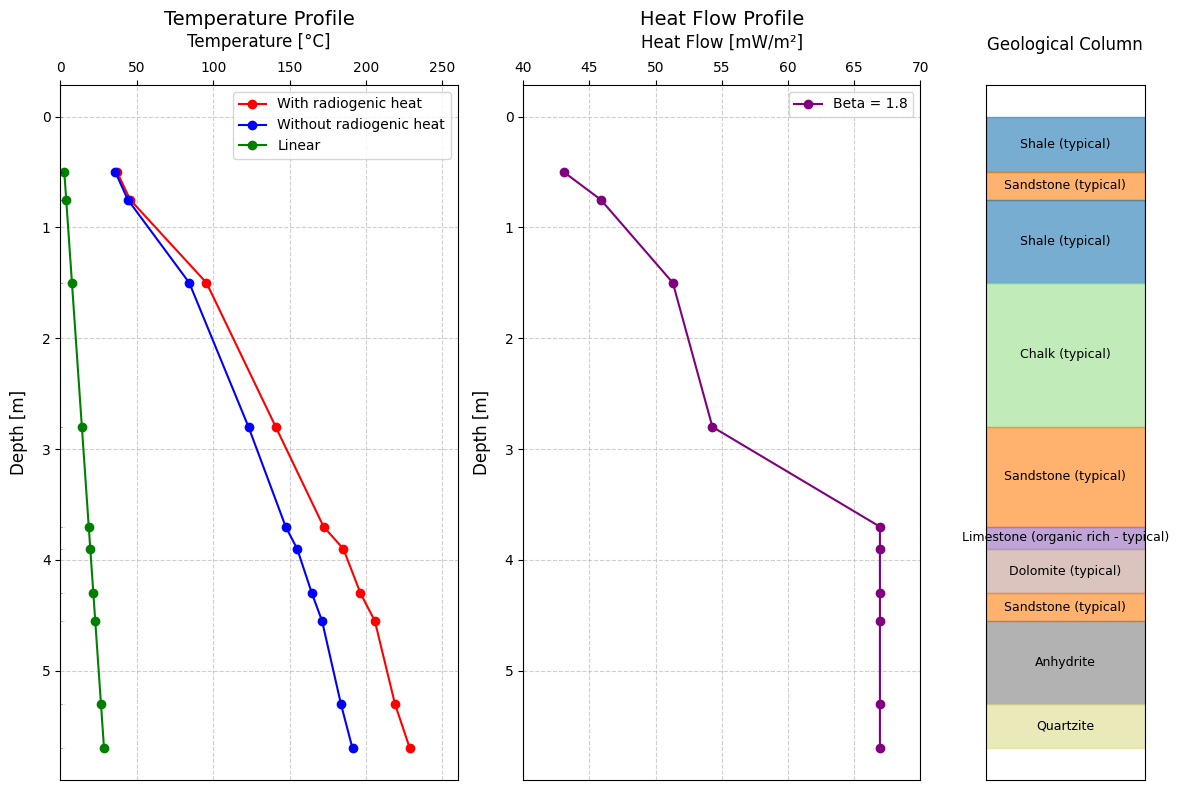

In [204]:
# Create figure with three subplots (temperature, heat flow, and geological column)
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.4])  # Adjust ratios as needed

ax1 = fig.add_subplot(gs[0])  # Temperature vs Depth
ax2 = fig.add_subplot(gs[1])  # Heat Flow vs Depth
ax_geo = fig.add_subplot(gs[2])  # Geological column

# --- Plot 1: Temperature vs Depth ---
x_values = decompaction_corrected_df[str(0.0)]   # Depth values in meters

ax1.plot(T_with_rad[str(0.0)], x_values, 'r-o', label='With radiogenic heat')
ax1.plot(T_without_rad[str(0.0)], x_values, 'b-o', label='Without radiogenic heat')
ax1.plot(T_linear[str(0.0)], x_values, 'g-o', label='Linear')

ax1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Temperature [°C]', fontsize=12, labelpad=10)
ax1.set_ylabel('Depth [m]', fontsize=12, labelpad=10)
ax1.set_title('Temperature Profile', fontsize=14)

ax1.set_xlim(0, 260)
ax1.invert_yaxis()  # Surface at top
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=10)

# --- Plot 2: Heat Flow vs Depth ---
ax2.plot([x * 10**3 for x in Qm_array[::-1][1::]], x_values, label=f'Beta = {beta}', marker='o', color='purple')

ax2.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Heat Flow [mW/m²]', fontsize=12, labelpad=10)
ax2.set_ylabel('Depth [m]', labelpad=10, fontsize=12)

ax2.set_xlim(40, 70)
ax2.invert_yaxis()  # Surface at top
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=10)
ax2.set_title('Heat Flow Profile', fontsize=14)

# --- Geological Column ---
ax_geo.set_xlim(0, 1)
ax_geo.set_xticks([])
ax_geo.set_xticklabels([])
ax_geo.xaxis.set_label_position('top')
ax_geo.set_xlabel('Geological Column', fontsize=12, labelpad=25)
ax_geo.grid(False)

# Get unique lithologies and their colors
lithologies = valid_layers['Lithology_type'].unique()
litho_colors = {lith: plt.cm.tab20(i/len(lithologies)) for i, lith in enumerate(lithologies)}

# Use present-day (0 Myr) depths only
present_col = '0.0'

# Plot connecting line for surface layer
for ax in [ax1, ax2]:
    ax.plot([0, 0], [0, 0], 'k--', lw=0.5, alpha=0.5)  # Surface at 0m
    ax.plot([0, 0.87], [0, 0], 'k--', lw=0.5, alpha=0.5)

# Plot the geological layers using only present-day depths
prev_depth = 0  # Start from surface (0m)
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    try:
        current_depth = decompaction_corrected_df.loc[layer_idx, present_col]
        if np.isnan(current_depth):
            continue

        lithology = valid_layers.loc[layer_idx, 'Lithology_type']
        color = litho_colors[lithology]

        # Draw connecting lines from both plots to geological column
        for ax in [ax1, ax2]:
            ax.plot([0, 0], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)
            ax.plot([0, 2.4], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)

        # Draw layer in geological column
        ax_geo.fill_betweenx([prev_depth, current_depth], 0, 1,
                           color=color, alpha=0.6)
        ax_geo.text(0.5, (prev_depth + current_depth)/2,
                   lithology, ha='center', va='center', fontsize=9)

        prev_depth = current_depth

    except KeyError:
        continue

# Remove y-axis from geological column and ensure surface is at top
ax_geo.yaxis.set_visible(False)
ax_geo.invert_yaxis()  # This ensures surface stays at top

# Adjust layout and save
plt.tight_layout()
plt.savefig('Combined_Plot_with_Geology.png', dpi=300, bbox_inches='tight')
plt.show()

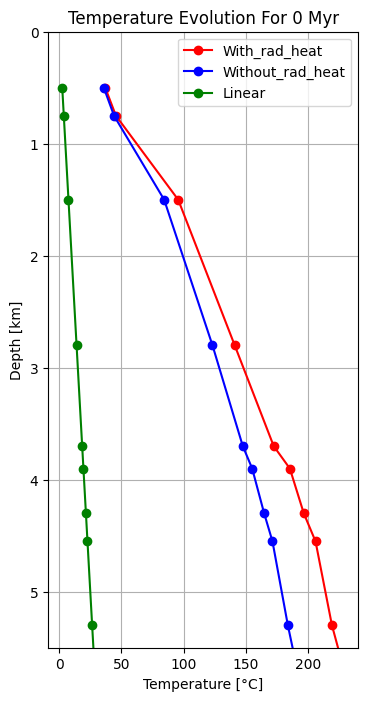

In [138]:
# Plot heat flow curve
plt.figure(figsize=(4, 8))

x_values = decompaction_corrected_df[str(0.0)]

plt.plot(T_with_rad[str(0.0)], x_values, 'r-o', label=f'With_rad_heat')
plt.plot(T_without_rad[str(0.0)], x_values, 'b-o', label=f'Without_rad_heat')
plt.plot(T_linear[str(0.0)], x_values, 'g-o', label=f'Linear')
plt.ylim(0, 5.5)
plt.gca().invert_yaxis()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [km]')
plt.title('Temperature Evolution For 0 Myr')
plt.grid(True)
plt.legend()
plt.show()

#### Tempreture during burial history and SWI temperature trend with radioctivity

<ipython-input-137-3004551497>:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


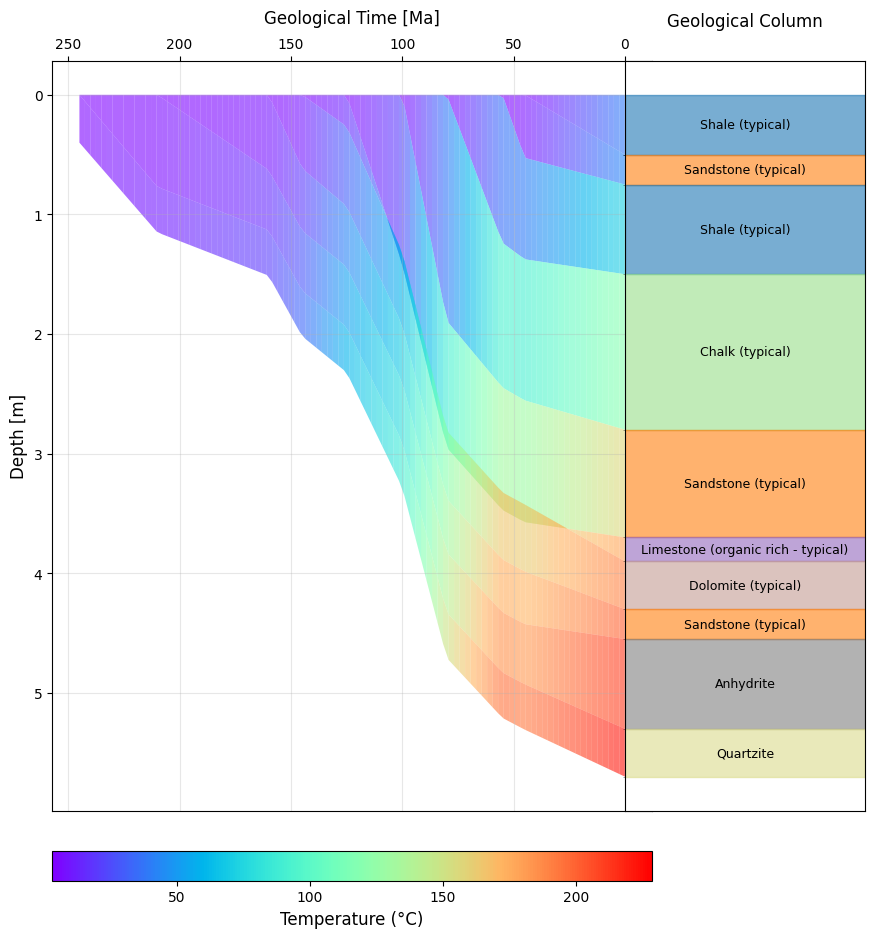

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from scipy.interpolate import interp1d

plt.figure(figsize=(8, 10))  # Increased width to accommodate geological column

# Data preparation
ages = np.array(np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce')))
temp_cmap = plt.cm.rainbow
norm = plt.Normalize(vmin=T_with_rad.values.min(), vmax=T_with_rad.values.max())

# Create main plot area (leave space on right for geological column)
ax_main = plt.axes([0.1, 0.15, 0.75, 0.75])  # [left, bottom, width, height]

# --- 1. Create interpolated temperature fields ---
def create_interpolated_grid(layer_idx, n_interp=100):
    """Returns interpolated ages, depths and temps for smoother plotting"""
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])
    temp_values = T_with_rad.loc[layer_idx].values

    # Filter valid points
    valid_mask = ~np.isnan(depth_values)
    valid_ages = ages[valid_mask]
    valid_depths = depth_values[valid_mask]
    valid_temps = temp_values[valid_mask]

    if len(valid_ages) < 2:
        return None, None, None

    # Create interpolation functions
    depth_interp = interp1d(valid_ages, valid_depths, kind='linear', fill_value="interpolate")
    temp_interp = interp1d(valid_ages, valid_temps, kind='linear', fill_value="interpolate")

    # New finer grid
    interp_ages = np.linspace(ages.min(), ages.max(), n_interp)
    interp_depths = depth_interp(interp_ages)
    interp_temps = temp_interp(interp_ages)

    return interp_ages, interp_depths, interp_temps

# --- 2. Plot with smooth temperature coloring ---

# First handle the surface layer (0-0.5m)
surface_depth = 0.5  # Your surface layer thickness

# Get temperature data for surface (use first layer's temperature)
surface_temp = T_with_rad.iloc[0].values
surface_temp_func = interp1d(ages, surface_temp, kind='linear', fill_value="extrapolate")

# Get data for first subsurface layer (0.5m+)
ages1, depths1, temps1 = create_interpolated_grid(T_with_rad.index[0])

if ages1 is not None:
    polygons = []
    color_values = []

    # Create matching time points for surface and subsurface
    interp_ages = np.linspace(ages.min(), ages.max(), len(ages1))

    # Get interpolated temperatures for surface at these time points
    surface_temps_interp = surface_temp_func(interp_ages)

    for j in range(len(interp_ages)-1):
        # Calculate average temperature between surface and first subsurface layer
        avg_temp = (surface_temps_interp[j] + surface_temps_interp[j+1] +
                   temps1[j] + temps1[j+1]) / 4

        poly_verts = [
            (interp_ages[j], 0),  # Surface at 0m
            (interp_ages[j+1], 0),  # Surface at 0m
            (interp_ages[j+1], depths1[j+1]),  # First subsurface layer
            (interp_ages[j], depths1[j])  # First subsurface layer
        ]
        polygons.append(poly_verts)
        color_values.append(avg_temp)

    # Add the surface layer polygons
    if polygons:  # Only add if we have valid polygons
        poly_collection = PolyCollection(
            polygons,
            array=np.array(color_values),
            cmap=temp_cmap,
            norm=norm,
            alpha=0.6,
            edgecolor='none'
        )
        ax_main.add_collection(poly_collection)

# Then plot the remaining layers as before
for i in range(len(T_with_rad) - 1):
    ages1, depths1, temps1 = create_interpolated_grid(T_with_rad.index[i])
    ages2, depths2, temps2 = create_interpolated_grid(T_with_rad.index[i+1])

    if ages1 is None or ages2 is None:
        continue

    polygons = []
    color_values = []

    for j in range(len(ages1)-1):
        avg_temp = (temps1[j] + temps1[j+1] + temps2[j] + temps2[j+1]) / 4
        poly_verts = [
            (ages1[j], depths1[j]),
            (ages1[j+1], depths1[j+1]),
            (ages2[j+1], depths2[j+1]),
            (ages2[j], depths2[j])
        ]
        polygons.append(poly_verts)
        color_values.append(avg_temp)

    poly_collection = PolyCollection(
        polygons,
        array=np.array(color_values),
        cmap=temp_cmap,
        norm=norm,
        alpha=0.6,
        edgecolor='none'
    )
    ax_main.add_collection(poly_collection)

# --- 3. Plot original scatter points ---
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages])
    sc = ax_main.scatter(ages, depth_values, c=layer_row.values, cmap=temp_cmap,
                       s=0, edgecolor='k', linewidth=0.5, zorder=3)

# --- 4. Create geological column ---
ax_geo = plt.axes([0.816, 0.15, 0.3, 0.75], sharey=ax_main)
ax_geo.set_xlim(0, 1)
ax_geo.set_xticks([])
ax_geo.set_xticklabels([])
ax_geo.xaxis.set_label_position('top')  # Move x-axis label to top
ax_geo.set_xlabel('Geological Column', fontsize=12, labelpad=25)  # Changed 'pad' to 'labelpad'
# ax_geo.set_title('Geological Column', fontsize=12, labelpad=10)
ax_geo.grid(False)

# Get unique lithologies and their colors
lithologies = valid_layers['Lithology_type'].unique()
litho_colors = {lith: plt.cm.tab20(i/len(lithologies)) for i, lith in enumerate(lithologies)}

# Find the column name closest to present day (age=0)
present_col = None
min_diff = float('inf')
for col in decompaction_corrected_df.columns:
    try:
        age = float(col)
        if abs(age) < min_diff:
            min_diff = abs(age)
            present_col = col
    except ValueError:
        continue

if present_col is None:
    present_col = decompaction_corrected_df.columns[-1]

# First draw the surface layer (0 to 0.5m)
# surface_lithology = valid_layers.iloc[0]['Lithology_type']  # Assuming first layer is surface
# print(surface_lithology)
# ax_geo.fill_betweenx([0, 0.5], 0, 1,
#                     color=litho_colors[surface_lithology],
#                     alpha=0.6)
# ax_geo.text(0.5, 0.25, surface_lithology,
#            ha='center', va='center', fontsize=9)

# Plot connecting line for surface layer
ax_main.plot([float(present_col), float(present_col)], [0.5, 0.5], 'k--', lw=0.5, alpha=0.5)
ax_main.plot([float(present_col), 0.87], [0.5, 0.5], 'k--', lw=0.5, alpha=0.5)

# Now plot the remaining layers
prev_depth = 0  # Start from the bottom of the surface layer
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    try:
        current_depth = decompaction_corrected_df.loc[layer_idx, present_col]
        if np.isnan(current_depth):
            continue

        lithology = valid_layers.loc[layer_idx, 'Lithology_type']
        color = litho_colors[lithology]

        # Draw connecting line from main plot to geological column
        ax_main.plot([float(present_col), float(present_col)],
                   [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)
        ax_main.plot([float(present_col), 0.87], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)

        # Draw layer in geological column
        ax_geo.fill_betweenx([prev_depth, current_depth], 0, 1,
                           color=color, alpha=0.6)
        ax_geo.text(0.5, (prev_depth + current_depth)/2,
                   lithology, ha='center', va='center', fontsize=9)

        prev_depth = current_depth

    except KeyError:
        continue

# --- 5. Final adjustments ---
ax_main.invert_xaxis()
ax_main.invert_yaxis()
ax_main.xaxis.set_label_position('top')  # Move x-axis label to top
ax_main.set_xlabel('Geological Time [Ma]', fontsize=12, labelpad=10)  # Changed 'pad' to 'labelpad'
ax_main.set_ylabel('Depth [m]', fontsize=12)
ax_main.grid(True, alpha=0.3)
ax_main.tick_params(axis='both', which='major', labelsize=10, bottom=False, top=True, labelbottom=False, labeltop=True)

# Add horizontal colorbar below main plot
cax = plt.axes([0.1, 0.08, 0.75, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('Temperature (°C)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Remove y-axis from geological column
ax_geo.yaxis.set_visible(False)

plt.savefig('HeatFlow.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

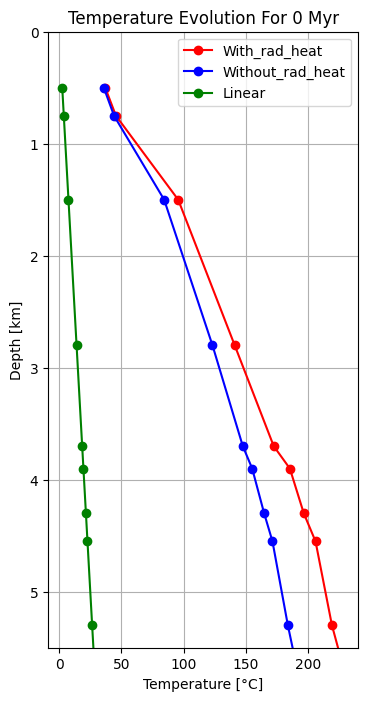

In [112]:
# Plot heat flow curve
plt.figure(figsize=(4, 8))

x_values = decompaction_corrected_df[str(0.0)]

plt.plot(T_with_rad[str(0.0)], x_values, 'r-o', label=f'With_rad_heat')
plt.plot(T_without_rad[str(0.0)], x_values, 'b-o', label=f'Without_rad_heat')
plt.plot(T_linear[str(0.0)], x_values, 'g-o', label=f'Linear')
plt.ylim(0, 5.5)
plt.gca().invert_yaxis()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [km]')
plt.title('Temperature Evolution For 0 Myr')
plt.grid(True)
plt.legend()
plt.show()

# Left part of heat flow

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar
from scipy.special import erf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

# Physical constants
a = 125e3       # lithosphere thickness [m]
k = 3.5       # thermal conductivity [W/m/K]
T1 = 1333       # asthenosphere temperature [°C]
# kappa = 8.04e-7 # thermal diffusivity [m²/s]
kappa = 1e-6 # thermal diffusivity [m²/s]

SECONDS_PER_MYR = 1e6 * 365.25 * 24 * 3600  # seconds in 1 million years

class EnhancedThermalModel:
    def __init__(self, G_prime, n_eigenvalues=5, z_resolution=1000):
        self.G_prime = G_prime
        self.n_eigenvalues = n_eigenvalues
        self.z_resolution = z_resolution
        self.eigenvalues = None
        self.eigenfunctions = None
        self.dtheta_n = None
        self.coefficients = None
        self.z_points = np.linspace(0, 1, z_resolution)

    def diff_eq(self, z, y, K):
        theta, dtheta = y
        return [dtheta,
                -self.G_prime*(1-z)*dtheta - K*theta]

    def propagator_matrix(self, K):
        sol = solve_ivp(
            fun=lambda z, y: self.diff_eq(z, y, K),
            t_span=(0, 1),
            y0=[0, 1],
            method='RK45',
            dense_output=True
        )
        return sol.sol(1)[0]

    def find_eigenvalues(self):
        print(f"Finding {self.n_eigenvalues} eigenvalues...")
        self.eigenvalues = []

        def equation(K):
            return self.propagator_matrix(K)

        K_guesses = [(n+1)**2 * np.pi**2 + self.G_prime/2 for n in range(self.n_eigenvalues)]

        for i, guess in enumerate(tqdm(K_guesses)):
            try:
                res = root_scalar(
                    equation,
                    x0=guess,
                    method='newton',
                    fprime=lambda K: (equation(K+1e-6) - equation(K-1e-6))/2e-6,
                    rtol=1e-6
                )
                if res.converged:
                    self.eigenvalues.append(res.root)
            except Exception as e:
                print(f"Warning: Could not find eigenvalue {i}: {str(e)}")
                continue

        self.eigenvalues = sorted(self.eigenvalues)[:self.n_eigenvalues]
        return self.eigenvalues

    def compute_eigenfunctions(self):
        if self.eigenvalues is None:
            self.find_eigenvalues()

        self.eigenfunctions = []
        print("Computing eigenfunctions...")

        for K in tqdm(self.eigenvalues):
            sol = solve_ivp(
                fun=lambda z, y: self.diff_eq(z, y, K),
                t_span=(0, 1),
                y0=[0, 1],
                t_eval=self.z_points,
                method='RK45'
            )
            self.eigenfunctions.append(sol.y[0])

        return self.z_points, self.eigenfunctions

    def compute_derivatives(self):
        self.dtheta_n = []
        print("Computing derivatives...")

        for K in tqdm(self.eigenvalues):
            sol = solve_ivp(
                fun=lambda z, y: self.diff_eq(z, y, K),
                t_span=(0, 1),
                y0=[0, 1],
                t_eval=[1],
                method='RK45'
            )
            self.dtheta_n.append(sol.y[1][0])

        return self.dtheta_n

    def _compute_normalization(self, theta_n):
        integrand = lambda z: (np.exp((z-1)**2 * self.G_prime/2) *
                             np.interp(z, self.z_points, theta_n)**2)
        return quad(integrand, 0, 1, limit=200)[0]

    def _compute_coefficient(self, initial_condition, theta_n, norm):
        integrand = lambda z: (initial_condition(z) *
                              np.interp(z, self.z_points, theta_n) *
                              np.exp((z-1)**2 * self.G_prime/2))
        return quad(integrand, 0, 1, limit=200)[0] / norm

    def compute_coefficients(self, initial_condition):
        if self.eigenfunctions is None:
            self.compute_eigenfunctions()

        self.coefficients = []
        print("Computing expansion coefficients...")

        for theta_n in tqdm(self.eigenfunctions):
            try:
                norm = self._compute_normalization(theta_n)
                an = self._compute_coefficient(initial_condition, theta_n, norm)
                self.coefficients.append(an)
            except Exception as e:
                print(f"Warning: Coefficient calculation failed: {str(e)}")
                self.coefficients.append(0)

        return self.coefficients

    def thermal_flux(self, t_myr):
        if None in [self.eigenvalues, self.coefficients, self.dtheta_n]:
            raise ValueError("Model not fully initialized")

        t_sec = t_myr * SECONDS_PER_MYR

        steady_term = (2/np.pi) * erf(np.sqrt(self.G_prime/2))

        transient_term = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            exponent = -Kn * kappa * t_sec / a**2
            transient_term += an * np.exp(exponent) * dtheta

        return (k * T1 / a) * (steady_term + transient_term) * 1000

    def compute_flux_history(self, time_range):
        if self.dtheta_n is None:
            self.compute_derivatives()
        return np.array([self.thermal_flux(t) for t in tqdm(time_range)])

    def save_results(self, time_range, flux_values, prefix=""):
        flux_filename = f"{prefix}thermal_flux_Gprime_{self.G_prime:.1f}.dat"
        np.savetxt(flux_filename,
                  np.column_stack((time_range, flux_values)),
                  header=f"Thermal flux output (G'={self.G_prime:.1f})\nTime(Myr) Flux(mW/m2)",
                  fmt='%.4f')

        eigen_filename = f"{prefix}eigenvalues_Gprime_{self.G_prime:.1f}.dat"
        np.savetxt(eigenfilename,
                  np.column_stack((range(len(self.eigenvalues)),
                                 self.eigenvalues,
                                 self.coefficients)),
                  header="Eigenvalues and coefficients\nn K_n a_n",
                  fmt=['%d', '%.6f', '%.6f'])

        print(f"Results saved to {flux_filename} and {eigen_filename}")

def initial_condition(z):
    return np.sin(np.pi*z)

def plot_results(model, time_range, flux_values):
    plt.figure(figsize=(16, 12))
    plt.suptitle(f"Lithospheric Thermal Model (G' = {model.G_prime})", fontsize=16)
    gs = GridSpec(3, 2, width_ratios=[1.2, 1], height_ratios=[1, 1, 1])

    # 1. Eigenfunctions plot
    ax1 = plt.subplot(gs[0, 0])
    for i, (K, theta) in enumerate(zip(model.eigenvalues[:5], model.eigenfunctions[:5])):
        ax1.plot(model.z_points*a/1e3, theta, label=f'Mode {i+1} (K={K:.1f})')
    ax1.set_title('First 5 Eigenfunctions')
    ax1.set_xlabel('Depth (km)')
    ax1.set_ylabel('θ(z)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Thermal flux evolution
    ax2 = plt.subplot(gs[0, 1])
    # ax2.semilogx(time_range, flux_values, 'r-', linewidth=2)
    ax2.plot(time_range, flux_values, 'r-', linewidth=2)
    ax2.set_title('Thermal Flux Evolution')
    ax2.set_xlabel('Time (Myr)')
    ax2.set_ylabel('Heat Flux (mW/m²)')
    ax2.grid(True, which='both', alpha=0.3)

    # 3. Expansion coefficients
    ax3 = plt.subplot(gs[1, 0])
    n_values = np.arange(len(model.coefficients))
    ax3.bar(n_values, np.abs(model.coefficients), alpha=0.7)
    ax3.set_title('Expansion Coefficients Magnitude')
    ax3.set_xlabel('Mode Number (n)')
    ax3.set_ylabel('|aₙ|')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # 4. Mode decay
    ax4 = plt.subplot(gs[1, 1])
    for i in range(min(3, len(model.eigenvalues))):
        decay = np.exp(-model.eigenvalues[i]*kappa*time_range*SECONDS_PER_MYR/a**2)
        ax4.semilogx(time_range, decay, label=f'Mode {i+1} (K={model.eigenvalues[i]:.1f})')
    ax4.set_title('Mode Decay Over Time')
    ax4.set_xlabel('Time (Myr)')
    ax4.set_ylabel('exp(-Kₙt)')
    ax4.legend()
    ax4.grid(True, which='both', alpha=0.3)

    # 5. Initial temperature distribution
    ax5 = plt.subplot(gs[2, 0])
    initial_temp = initial_condition(model.z_points)
    ax5.plot(model.z_points*a/1e3, initial_temp, 'b-')
    ax5.set_title('Initial Temperature Distribution')
    ax5.set_xlabel('Depth (km)')
    ax5.set_ylabel('Dimensionless Temperature')
    ax5.grid(True, alpha=0.3)

    # 6. Parameter space info
    ax6 = plt.subplot(gs[2, 1])
    ax6.axis('off')
    info_text = (
        f"Model Parameters:\n"
        f"G' = {model.G_prime:.1f}\n"
        f"Lithosphere Thickness = {a/1e3:.0f} km\n"
        f"Asthenosphere Temp = {T1:.0f} °C\n"
        f"Thermal Conductivity = {k:.3f} W/m/K\n"
        f"Thermal Diffusivity = {kappa:.2e} m²/s\n"
        f"Number of Eigenvalues = {model.n_eigenvalues}\n"
        f"Final Flux Value = {flux_values[-1]:.2f} mW/m²"
    )
    ax6.text(0.1, 0.5, info_text, fontfamily='monospace', va='center')

    plt.tight_layout()
    plt.show()

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


Initializing thermal model...

Computing model components...
Finding 5 eigenvalues...


100%|██████████| 5/5 [00:00<00:00, 44.93it/s]


Computing eigenfunctions...


100%|██████████| 5/5 [00:00<00:00, 410.35it/s]


Computing derivatives...


100%|██████████| 5/5 [00:00<00:00, 491.90it/s]


Computing expansion coefficients...


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-142-100570516>:109: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0]
<ipython-input-142-100570516>:115: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0] / norm
100%|██████████| 5/5 [00:00<00:00, 71.76it/s]



Calculating thermal flux history...


100%|██████████| 100/100 [00:00<00:00, 7441.33it/s]


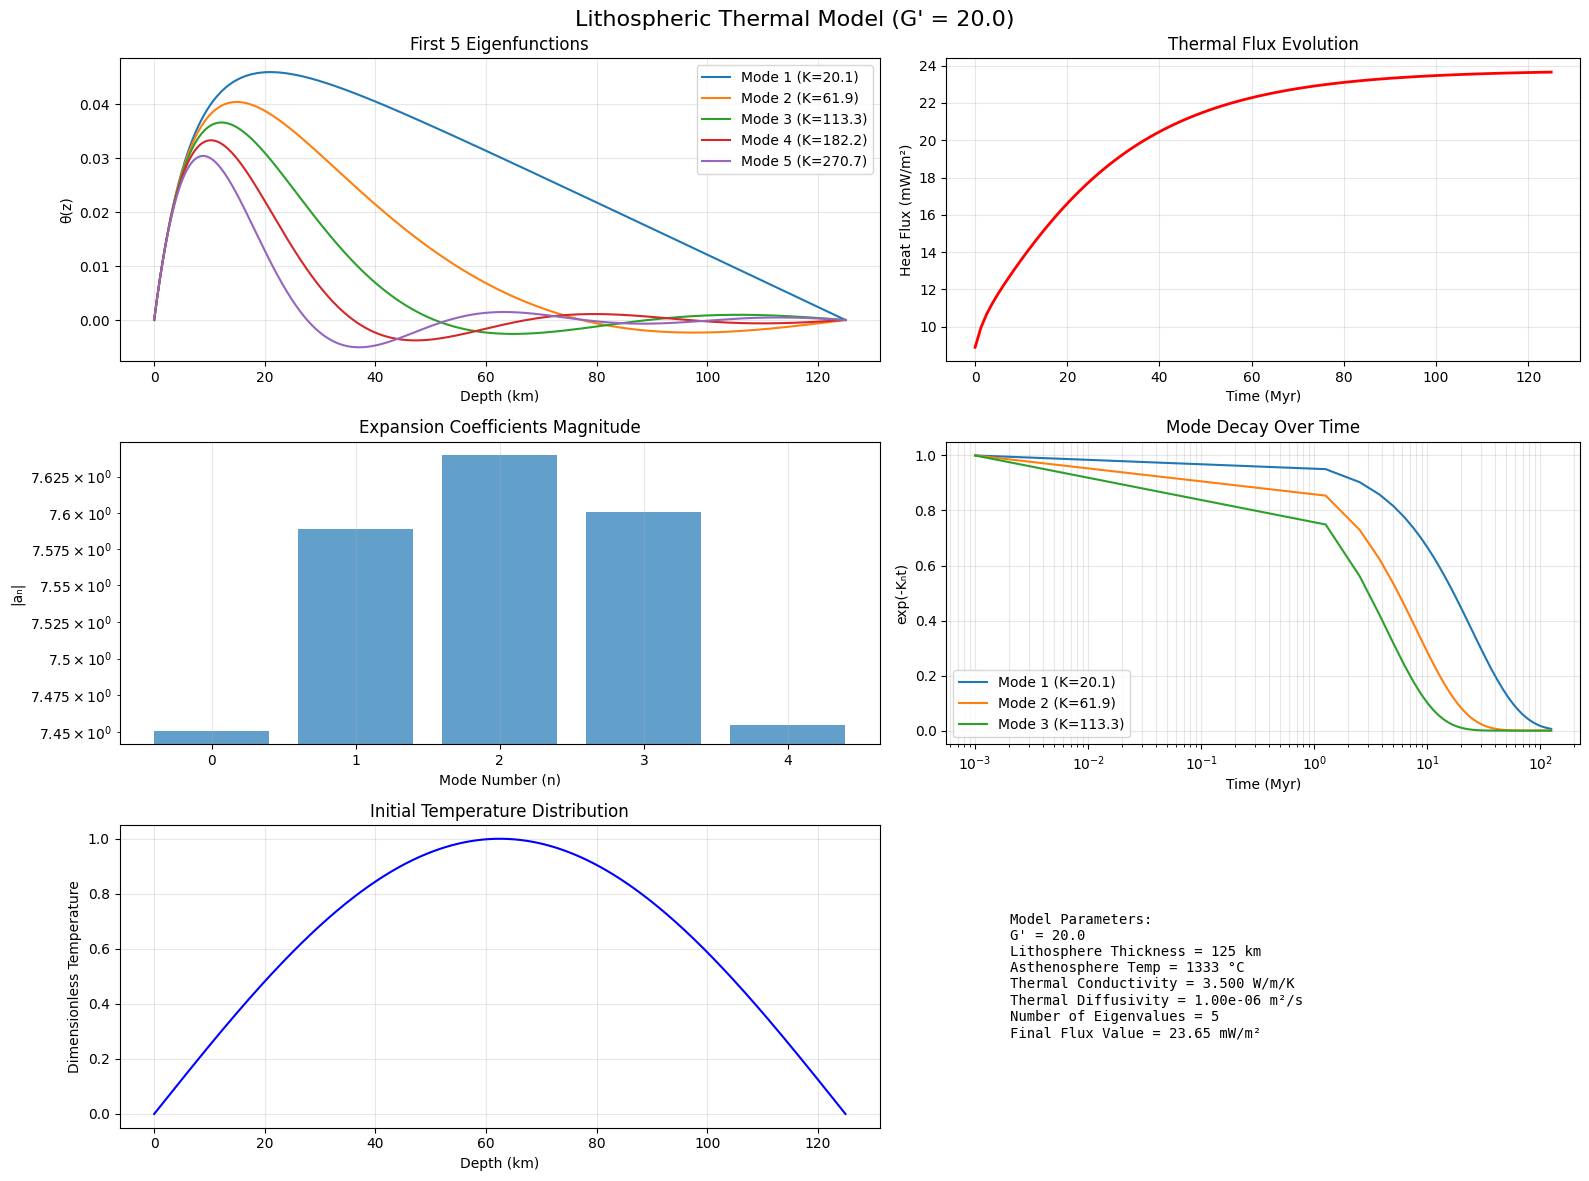

NameError: name 'eigenfilename' is not defined

In [ ]:
def main():
    G_prime = 20.0
    # time_range = np.logspace(-2, 2, 500)  # 0.01 to 100 Myr (logarithmic)
    time_range = np.linspace(1e-3, 125, 100)  # 0.01 to 100 Myr (logarithmic)

    print("Initializing thermal model...")
    model = EnhancedThermalModel(G_prime, n_eigenvalues=5)

    print("\nComputing model components...")
    model.find_eigenvalues()  # Changed from _find_eigenvalues()
    model.compute_eigenfunctions()  # Changed from _compute_eigenfunctions()
    model.compute_derivatives()  # Added this missing call
    model.compute_coefficients(initial_condition)

    print("\nCalculating thermal flux history...")
    flux_history = model.compute_flux_history(time_range)

    plot_results(model, time_range, flux_history)
    model.save_results(time_range, flux_history)

    print("\nAnalysis complete.")

if __name__ == "__main__":
    main()

In [ ]:
# Create and run the model
model = EnhancedThermalModel(G_prime=10)
model.find_eigenvalues()
model.compute_eigenfunctions()
model.compute_derivatives()
model.compute_coefficients(initial_condition)

# Time range (0-200 Myr in 1 Myr steps)
time_range = np.arange(0, 201, 30)
flux_values = model.compute_flux_history(time_range)


# Create a more robust printing function
def print_heat_flow_data(time_range, flux_values, n=20):
    print("Time (Myr)\tHeat Flow (mW/m²)")
    print("----------------------------------")

    # Print first n entries
    for t, q in zip(time_range[:n], flux_values[:n]):
        print(f"{float(t):.1f}\t\t{q:.6f}")  # Using 6 decimal places

    print("...\t\t...")

    # Print last n entries
    for t, q in zip(time_range[-n:], flux_values[-n:]):
        print(f"{float(t):.1f}\t\t{q:.6f}")

# Print the data
print_heat_flow_data(time_range, flux_values)



Finding 20 eigenvalues...


100%|██████████| 20/20 [00:01<00:00, 17.14it/s]


Computing eigenfunctions...


100%|██████████| 20/20 [00:00<00:00, 112.15it/s]


Computing derivatives...


100%|██████████| 20/20 [00:00<00:00, 157.88it/s]


Computing expansion coefficients...


  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-144-1505102452>:109: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0]
<ipython-input-144-1505102452>:115: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0] / norm
100%|██████████| 7/7 [00:00<00:00, 7057.72it/s]

Time (Myr)	Heat Flow (mW/m²)
----------------------------------
0.0		-1.271488
30.0		5.138556
60.0		13.528578
90.0		18.513984
120.0		21.089710
150.0		22.394150
180.0		23.052819
...		...
0.0		-1.271488
30.0		5.138556
60.0		13.528578
90.0		18.513984
120.0		21.089710
150.0		22.394150
180.0		23.052819


In [ ]:
import pandas as pd
df = pd.DataFrame({'Time (Myr)': time_range, 'Heat Flow (mW/m²)': flux_values})
df.to_csv('heat_flow_results.csv', index=False)

Finding 20 eigenvalues...


100%|██████████| 20/20 [00:01<00:00, 14.45it/s]


Computing eigenfunctions...


100%|██████████| 20/20 [00:00<00:00, 92.38it/s] 


Computing derivatives...


100%|██████████| 20/20 [00:00<00:00, 135.89it/s]


Computing expansion coefficients...


  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-137-3439423165>:107: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0]
<ipython-input-137-3439423165>:113: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0] / norm
100%|██████████| 300/300 [00:00<00:00, 13866.69it/s]


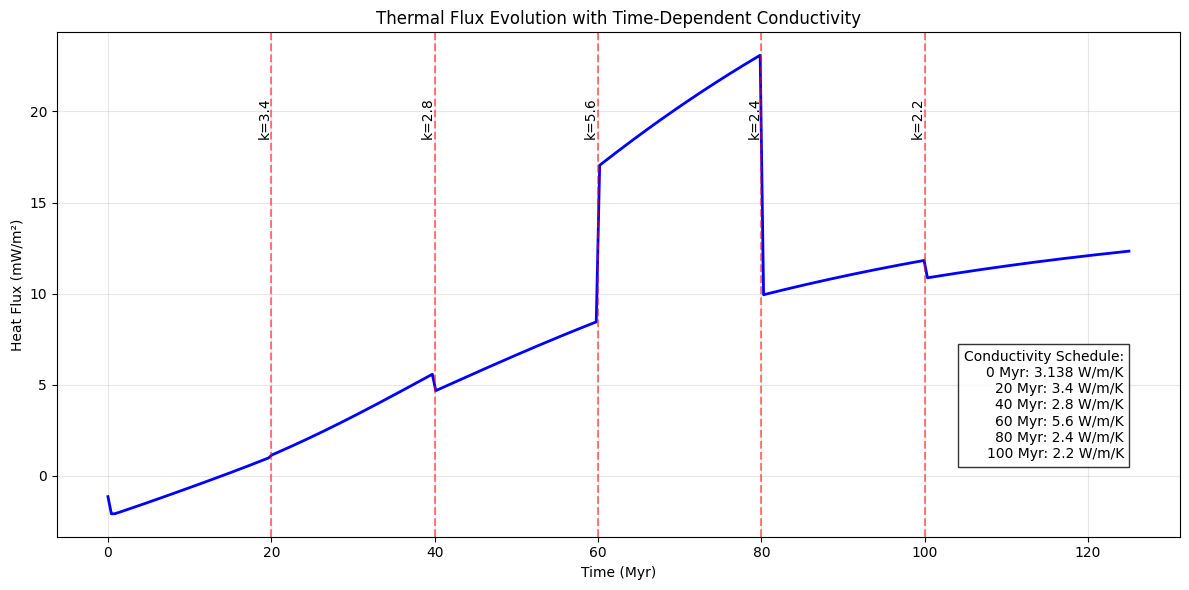

In [ ]:
class TimeDependentConductivityModel(EnhancedThermalModel):
    def __init__(self, G_prime, conductivity_schedule, n_eigenvalues=20, z_resolution=1000):
        """
        conductivity_schedule: dictionary of {time_myr: conductivity_value}
        """
        super().__init__(G_prime, n_eigenvalues, z_resolution)
        self.conductivity_schedule = conductivity_schedule
        self.sorted_times = sorted(conductivity_schedule.keys())

    def get_conductivity(self, t_myr):
        """Get conductivity for a given time"""
        # Find the largest time in schedule that is <= t_myr
        for time in reversed(self.sorted_times):
            if t_myr >= time:
                return self.conductivity_schedule[time]
        return self.conductivity_schedule[self.sorted_times[0]]

    def thermal_flux(self, t_myr):
        if None in [self.eigenvalues, self.coefficients, self.dtheta_n]:
            raise ValueError("Model not fully initialized")

        t_sec = t_myr * SECONDS_PER_MYR
        current_k = self.get_conductivity(t_myr)

        steady_term = (2/np.pi) * erf(np.sqrt(self.G_prime/2))

        transient_term = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            exponent = -Kn * kappa * t_sec / a**2
            transient_term += an * np.exp(exponent) * dtheta

        return (current_k * T1 / a) * (steady_term + transient_term) * 1000

def run_time_dependent_simulation():
    # Define conductivity schedule (time in Myr: conductivity in W/m/K)
    conductivity_schedule = {
        0: 3.138,    # Initial conductivity
        20: 3.4,     # Changed at 20 Myr
        40: 2.8,     # Changed at 40 Myr
        60: 5.6,     # Changed at 60 Myr
        80: 2.4,     # Changed at 80 Myr
        100: 2.2     # Changed at 100 Myr
    }

    # Create model
    model = TimeDependentConductivityModel(
        G_prime=10,
        conductivity_schedule=conductivity_schedule,
        n_eigenvalues=20
    )

    # Initialize model components
    model.find_eigenvalues()
    model.compute_eigenfunctions()
    model.compute_derivatives()
    model.compute_coefficients(initial_condition)

    # Time range for simulation
    time_range = np.linspace(0, 125, 300)  # 0-150 Myr

    # Compute flux history
    flux_values = model.compute_flux_history(time_range)

    # Plot results
    plt.figure(figsize=(12, 6))

    # Plot flux evolution
    plt.plot(time_range, flux_values, 'b-', linewidth=2)

    # Mark conductivity change points
    for t in conductivity_schedule:
        if t > 0:  # Don't mark t=0
            plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)
            plt.text(t, np.max(flux_values)*0.9, f'k={conductivity_schedule[t]}',
                    rotation=90, va='top', ha='right')

    plt.title('Thermal Flux Evolution with Time-Dependent Conductivity')
    plt.xlabel('Time (Myr)')
    plt.ylabel('Heat Flux (mW/m²)')
    plt.grid(True, alpha=0.3)

    # Add conductivity schedule info
    plt.text(0.95, 0.15, "Conductivity Schedule:\n" +
             "\n".join([f"{t} Myr: {k} W/m/K"
                       for t, k in conductivity_schedule.items()]),
             transform=plt.gca().transAxes, ha='right', va='bottom',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Run the simulation
run_time_dependent_simulation()

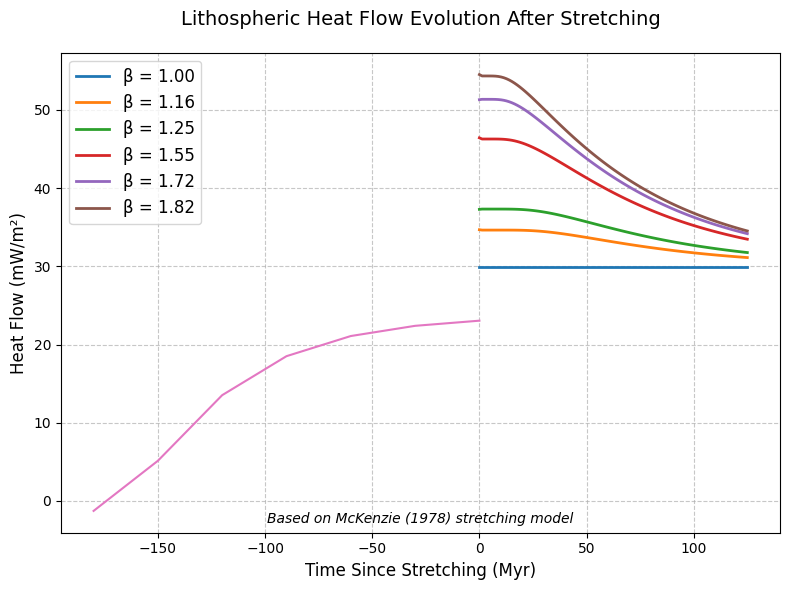

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union

def calculate_heat_flux(
    beta: Union[float, List[float]],
    time_myr: Union[float, np.ndarray],
    lithosphere_thickness_km: float = 125,
    thermal_time_constant_myr: float = 62.8,
    thermal_conductivity_wmk: float = 3.5,
    mantle_temperature_c: float = 1333,
    n_terms: int = 100
) -> np.ndarray:
    """
    Calculate heat flux for lithospheric stretching models using McKenzie's approach.

    Parameters:
        beta: Stretching factor(s) (float or list of floats)
        time_myr: Time since stretching event in million years (float or array)
        lithosphere_thickness_km: Thickness of lithosphere in km (default 125)
        thermal_time_constant_myr: Thermal time constant in Myr (default 62.8)
        thermal_conductivity_wmk: Thermal conductivity in W/m·K (default 3.5)
        mantle_temperature_c: Mantle temperature in °C (default 1333)
        n_terms: Number of terms in the series expansion (default 100)

    Returns:
        Array of heat flux values in mW/m²
    """

    beta_arr = np.atleast_1d(beta)
    time_arr = np.atleast_1d(time_myr)

    heat_flux = np.zeros((len(beta_arr), len(time_arr)))


    for i, b in enumerate(beta_arr):
        series_sum = 0.0
        for n in range(1, n_terms + 1):
            term = (b / (n * np.pi) * np.sin(n * np.pi / b) * np.exp(-n**2 * time_arr / thermal_time_constant_myr))
            series_sum += term

        # Calculate dimensionless temperature ratio
        T_over_Tm = 0.8 * (1 + 2 * series_sum)

        # Convert to heat flux (mW/m²)
        # heat_flux[i] = T_over_Tm * 60 * 697 *1e-3  # W/m² to mW/m², the factor 60*697*1e-3 from the original code
        heat_flux[i] = T_over_Tm * (thermal_conductivity_wmk * mantle_temperature_c /
                                   (lithosphere_thickness_km * 1000)) * 1e3  # W/m² to mW/m²

    return heat_flux.squeeze()  # Remove single-dimensional entries

# Parameters
beta_values = [1, 1.16, 1.25, 1.55, 1.72, 1.82]
time_values = np.linspace(0, 125, 100)

# Calculate heat flux
flux = calculate_heat_flux(beta_values, time_values)

# Plotting
plt.figure(figsize=(8, 6))
for i, b in enumerate(np.atleast_1d(beta_values)):
    plt.plot(time_values, flux[i] if len(np.atleast_1d(beta_values)) > 1 else flux,
             label=f'β = {b:.2f}',
             linewidth=2)


plt.plot(df['Time (Myr)'][::-1]*-1, df['Heat Flow (mW/m²)'])

plt.xlabel('Time Since Stretching (Myr)', fontsize=12)
plt.ylabel('Heat Flow (mW/m²)', fontsize=12)
plt.title('Lithospheric Heat Flow Evolution After Stretching', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.annotate('Based on McKenzie (1978) stretching model',
             xy=(0.5, 0.02), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['Time (Myr)', 'Heat Flow (mW/m²)'], dtype='object')